## Instalação e Importação das Dependências

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q -U keras_sequential_ascii
!pip install -q -U wandb

from keras_sequential_ascii import keras2ascii
from wandb.keras import WandbCallback


     |████████████████████████████████| 1.8 MB 15.6 MB/s 
     |████████████████████████████████| 145 kB 92.3 MB/s 
     |████████████████████████████████| 181 kB 100.3 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 


In [ ]:
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import backend as B
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import LayerNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.preprocessing import image
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2D, Conv2DTranspose
import keras.layers.convolutional as conv
import glob
import cv2
import plotly.graph_objs as go
import keras
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix, precision_recall_fscore_support, accuracy_score


## Binarização / Limiarização por Segmentação

In [ ]:
base_treino = '/content/drive/MyDrive/Documentação - CNN Coluna/dataset/train/normal/*'
lista_imagens = glob.glob(base_treino)


In [ ]:
def exibe_imagem(imagem, titulo, tamanho):
  fig, axis = plt.subplots(figsize = tamanho)
  axis.imshow(imagem, 'gray')
  axis.set_title(titulo, fontdict = {'fontsize':22, 'fontweight':'medium'})
  plt.show()


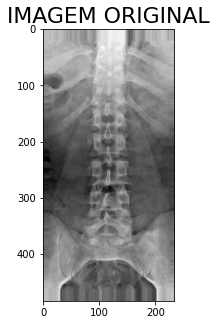

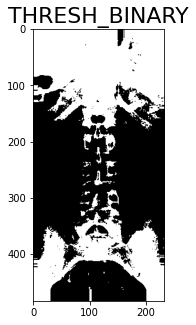

In [ ]:
# Limiarização via THRESH_BINARY da biblioteca OpenCV

imagem = lista_imagens[2]

img = cv2.imread(imagem)
thresh, img_thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY) # Parâmetros da binarização, todos pixels com valor acima de 127 ficarão brancos, todos com valor abaixo de 127 ficarão pretos

exibe_imagem(img, 'IMAGEM ORIGINAL', (5,5))
exibe_imagem(img_thresh, 'THRESH_BINARY', (5,5))


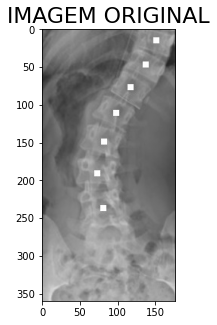

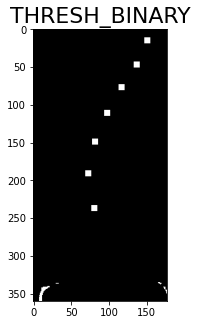

In [ ]:
# Limiarização via THRESH_BINARY da biblioteca OpenCV

imagem = '/content/drive/MyDrive/Documentação - CNN Coluna/PATOLOGICA(6748).jpg'

img = cv2.imread(imagem)
thresh, img_thresh = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY) # Parâmetros da binarização, todos pixels com valor acima de 127 ficarão brancos, todos com valor abaixo de 127 ficarão pretos

exibe_imagem(img, 'IMAGEM ORIGINAL', (5,5))
exibe_imagem(img_thresh, 'THRESH_BINARY', (5,5))


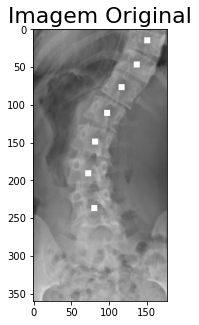

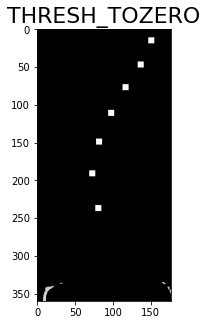

In [ ]:
# Limiarização via THRESH_TOZERO da biblioteca OpenCV

imagem = '/content/drive/MyDrive/Documentação - CNN Coluna/PATOLOGICA(6748).jpg'

img = cv2.imread(imagem)
thresh, img_thresh = cv2.threshold(img, 200, 255, cv2.THRESH_TOZERO) # Parâmetros da binarização, todos pixels com valor acima de 127 ficarão brancos, todos com valor abaixo de 127 ficarão pretos

exibe_imagem(img, 'Imagem Original', (5,5))
exibe_imagem(img_thresh, 'THRESH_TOZERO', (5,5))


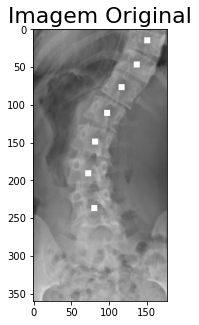

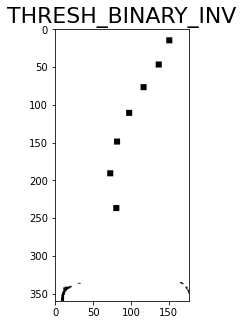

In [ ]:
# Limiarização via THRESH_BINARY da biblioteca OpenCV

imagem = '/content/drive/MyDrive/Documentação - CNN Coluna/PATOLOGICA(6748).jpg'

img = cv2.imread(imagem)
thresh, img_thresh = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY_INV) # Parâmetros da binarização, todos pixels com valor acima de 127 ficarão brancos, todos com valor abaixo de 127 ficarão pretos

exibe_imagem(img, 'Imagem Original', (5,5))
exibe_imagem(img_thresh, 'THRESH_BINARY_INV', (5,5))


## Classificador Base

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

N_epocas = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
            21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
            41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,
            61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,
            81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100]

In [ ]:
gerador_treino = ImageDataGenerator(rescale = 1.0/255)
gerador_teste = ImageDataGenerator(rescale = 1.0/255)

base_treino = gerador_treino.flow_from_directory('/content/drive/MyDrive/Documentação - CNN Coluna/dataset/train/',
                                                 target_size = (128,128),
                                                 batch_size = 1,
                                                 class_mode = 'binary',
                                                 shuffle = True)

base_teste = gerador_teste.flow_from_directory('/content/drive/MyDrive/Documentação - CNN Coluna/dataset/test/',
                                               target_size = (128,128),
                                               batch_size = 1,
                                               class_mode = 'binary',
                                               shuffle = True)

classificador = Sequential()
classificador.add(Conv2D(128,
                         kernel_size = (3,3),
                         input_shape = (128,128,3),
                         activation = 'relu'))
classificador.add(Flatten())
classificador.add(Dense(units = 128,
                        activation = 'relu'))
classificador.add(Dense(units = 1,
                        activation = 'sigmoid'))
classificador.compile(optimizer = 'Adam',
                      loss = 'binary_crossentropy',
                      metrics = METRICS)

epochs = 100

learning_rate = ReduceLROnPlateau()

h_0 = classificador.fit(base_treino,
                        steps_per_epoch = 100,
                        epochs = epochs,
                        validation_data = base_teste,
                        callbacks = [learning_rate],
                        verbose = 1,
                        validation_steps = 25)


Found 2392 images belonging to 2 classes.
Found 505 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 65s 537ms/step - loss: 5.2858 - tp: 8.0000 - fp: 7.0000 - tn: 55.0000 - fn: 30.0000 - accuracy: 0.6300 - precision: 0.5333 - recall: 0.2105 - auc: 0.5314 - val_loss: 1.9599 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 14.0000 - val_fn: 11.0000 - val_accuracy: 0.5600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1558 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 43s 429ms/step - loss: 0.8440 - tp: 15.0000 - fp: 2.0000 - tn: 62.0000 - fn: 21.0000 - accuracy: 0.7700 - precision: 0.8824 - recall: 0.4167 - auc: 0.6847 - val_loss: 0.5778 - val_tp: 7.0000 - val_fp: 7.0000 - val_tn: 9.0000 - val_fn: 2.0000 - val_accuracy: 0.6400 - val_precision: 0.5000 - val_recall: 0.7778 - val_auc: 0.8646 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 39s 383ms/step - loss: 0.6245 - tp: 34.0000 - fp: 8.0

In [ ]:
classificador.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     3584      
                                                                 
 flatten (Flatten)           (None, 2032128)           0         
                                                                 
 dense (Dense)               (None, 128)               260112512 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 260,116,225
Trainable params: 260,116,225
Non-trainable params: 0
_________________________________________________________________


In [ ]:
keras2ascii(classificador)


           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####    128  128    3
              Conv2D    \|/  -------------------      3584     0.0%
                relu   #####    126  126  128
             Flatten   ||||| -------------------         0     0.0%
                       #####     2032128
               Dense   XXXXX ------------------- 260112512   100.0%
                relu   #####         128
               Dense   XXXXX -------------------       129     0.0%
             sigmoid   #####           1


In [ ]:
print('Acuracia do treino: {0:.2f}%'.format(max(h_0.history['accuracy']) * 100))
print('Acuracia da validacao: {0:.2f}%'.format(max(h_0.history['val_accuracy']) * 100))


Acuracia do treino: 99.00%
Acuracia da validacao: 92.00%


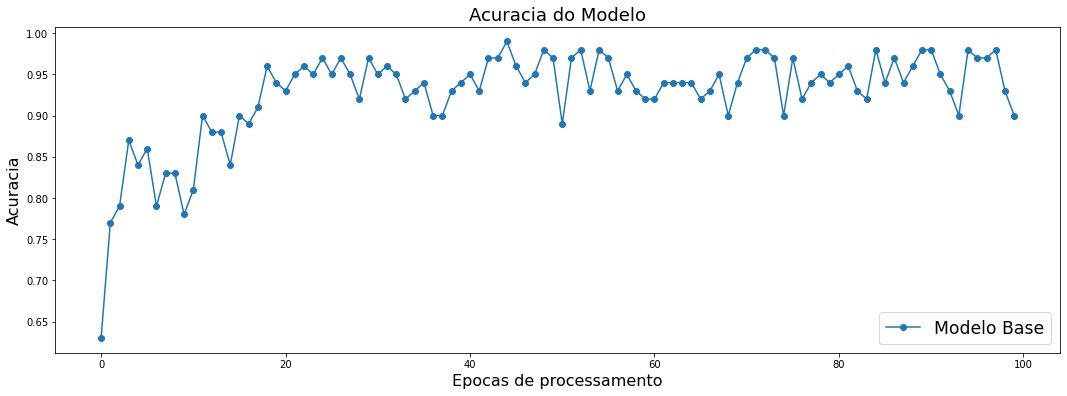

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_0.history['accuracy'], '-o')
plt.legend(['Modelo Base'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Acuracia do Modelo', fontsize=18)
plt.show()


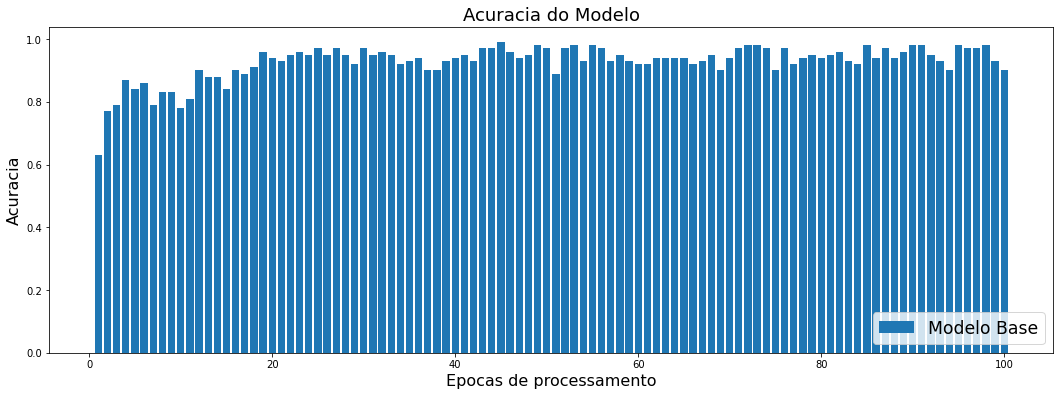

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas, h_0.history['accuracy'])
plt.legend(['Modelo Base'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Acuracia do Modelo', fontsize=18)
plt.show()

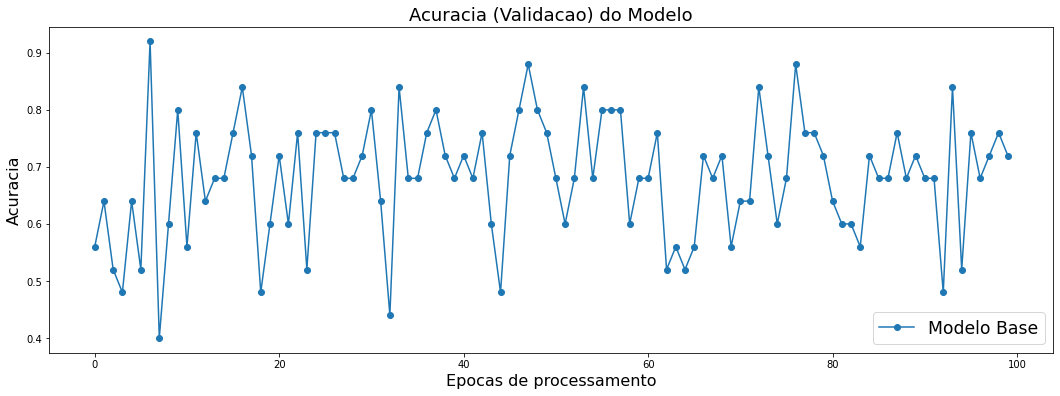

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_0.history['val_accuracy'], '-o')
plt.legend(['Modelo Base'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Acuracia (Validacao) do Modelo', fontsize=18)
plt.show()


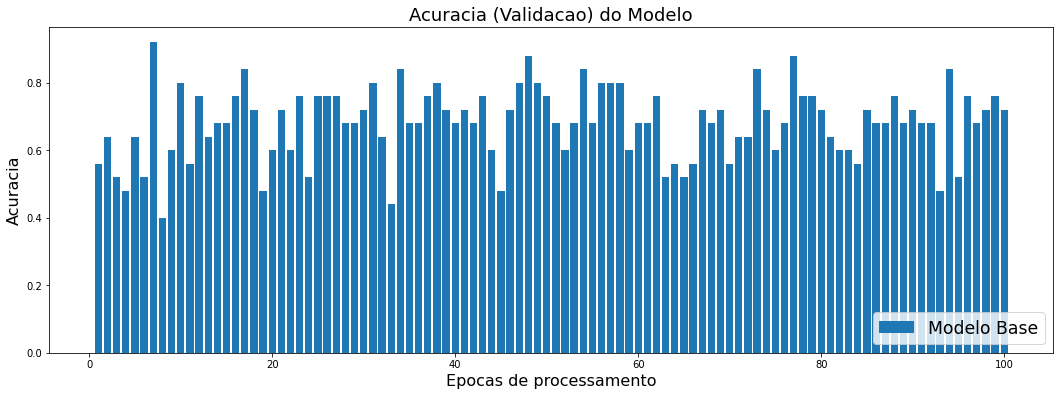

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas, h_0.history['val_accuracy'])
plt.legend(['Modelo Base'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Acuracia (Validacao) do Modelo', fontsize=18)
plt.show()


<function matplotlib.pyplot.show>

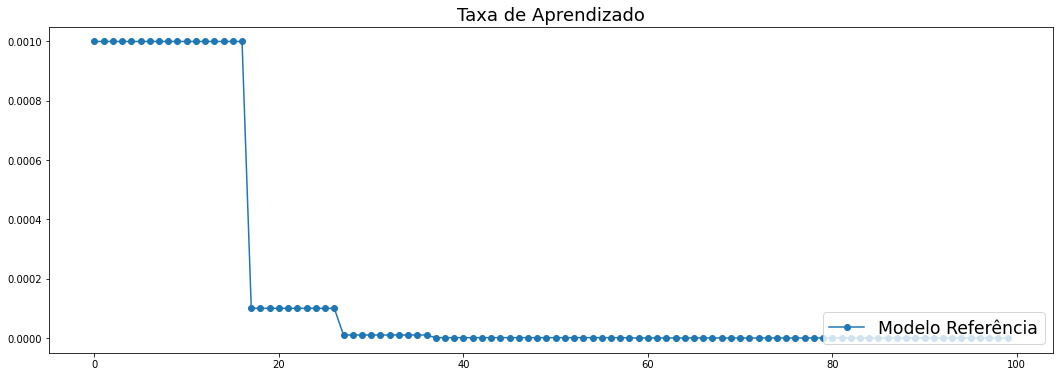

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_0.history['lr'], '-o')
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Taxa de Aprendizado', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

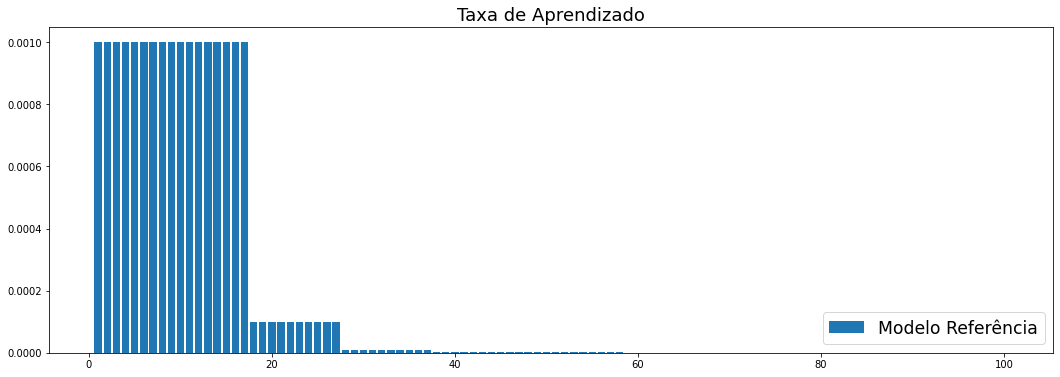

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_0.history['lr'])
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Taxa de Aprendizado', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

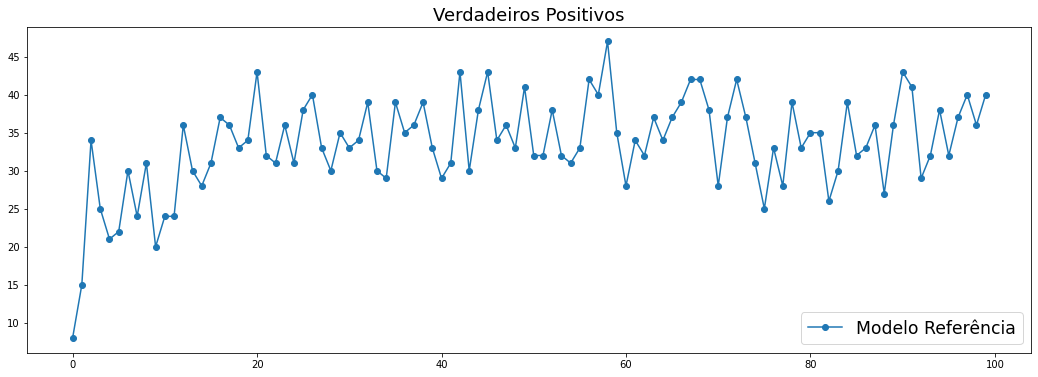

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_0.history['tp'], '-o')
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Verdadeiros Positivos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

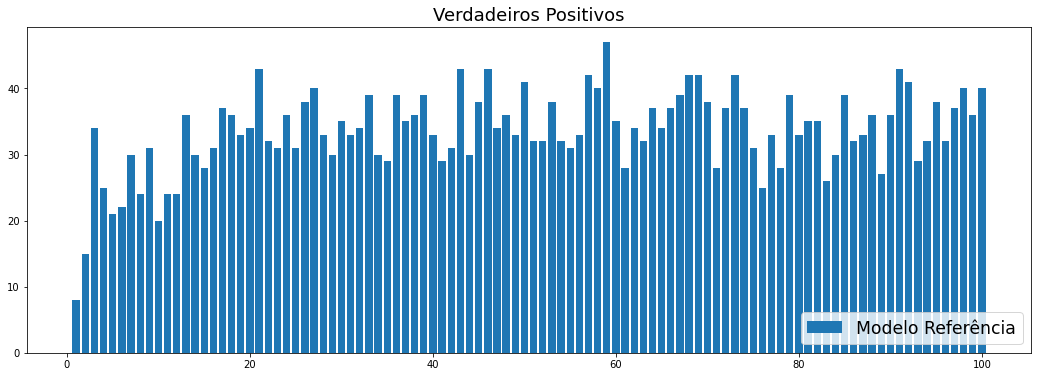

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_0.history['tp'])
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Verdadeiros Positivos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

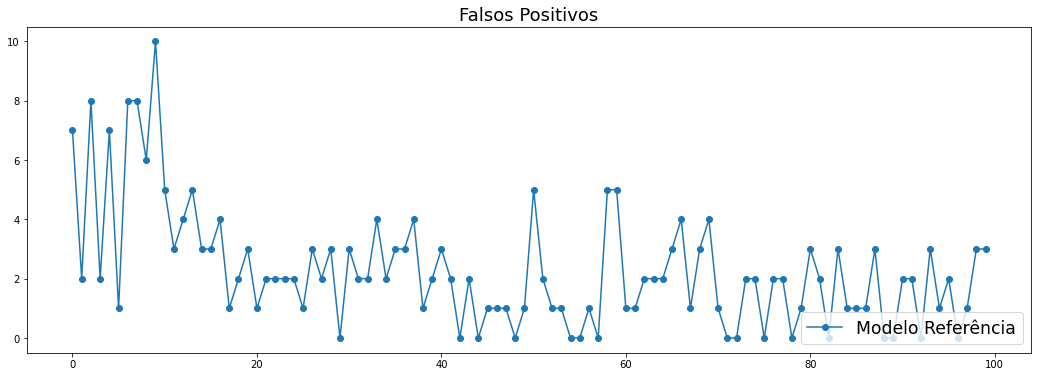

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_0.history['fp'], '-o')
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Falsos Positivos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

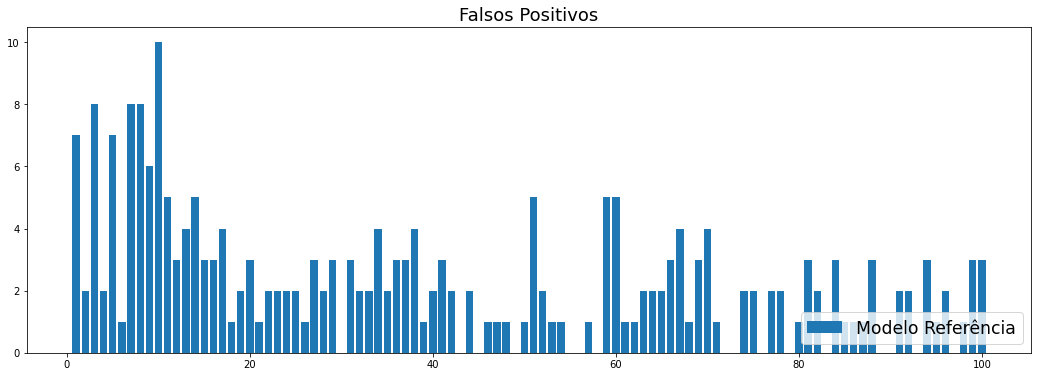

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_0.history['fp'])
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Falsos Positivos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

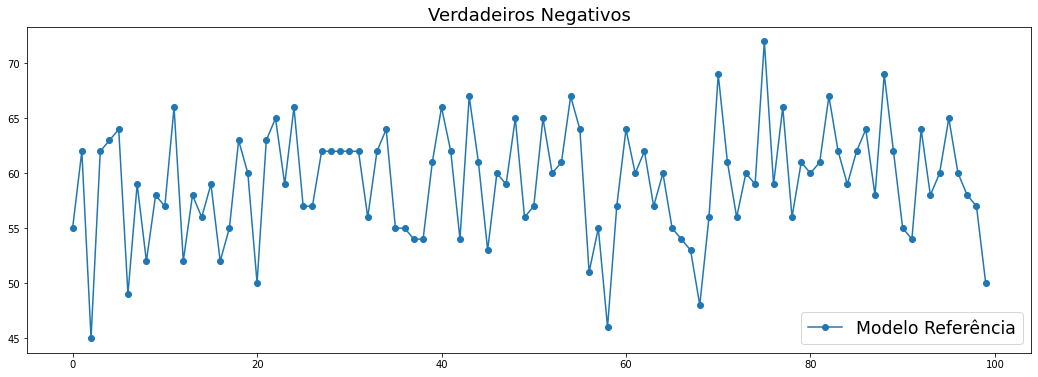

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_0.history['tn'], '-o')
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Verdadeiros Negativos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

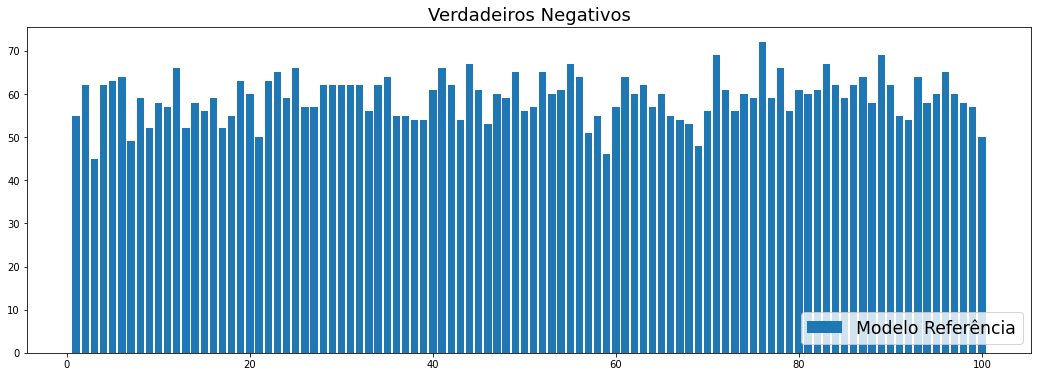

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_0.history['tn'])
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Verdadeiros Negativos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

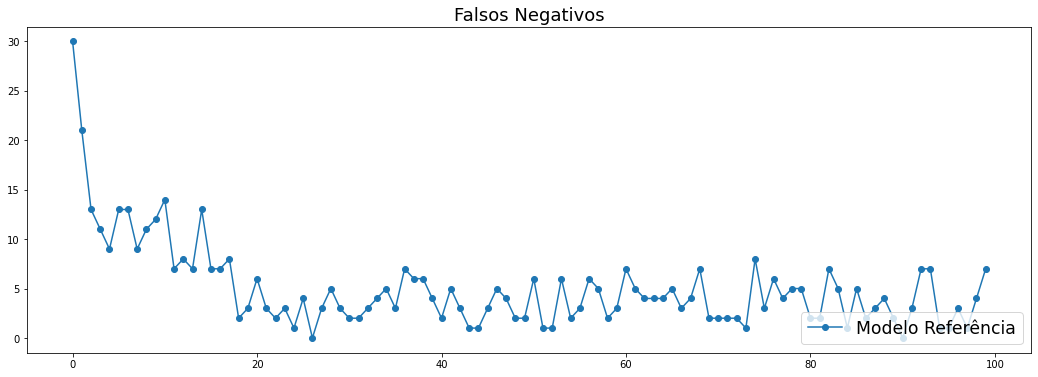

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_0.history['fn'], '-o')
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Falsos Negativos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

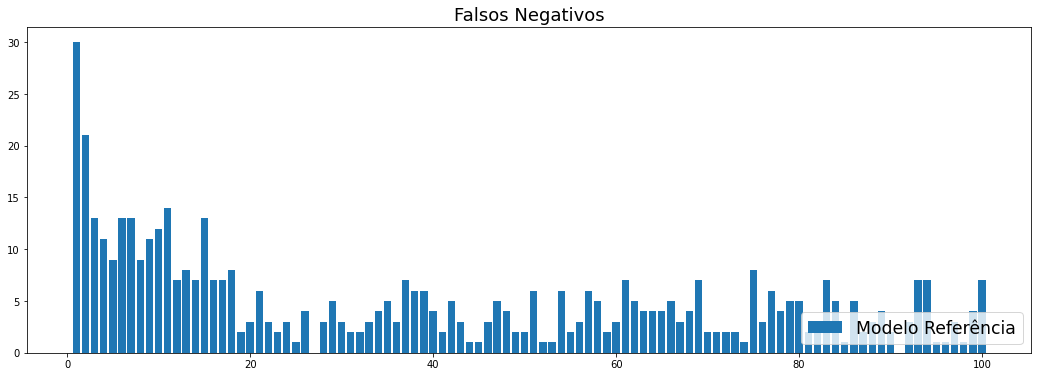

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_0.history['fn'])
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Falsos Negativos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

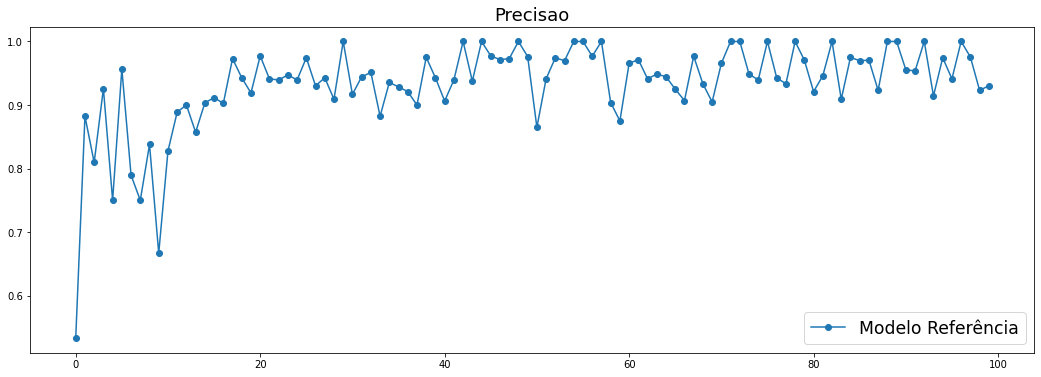

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_0.history['precision'], '-o')
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Precisao', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

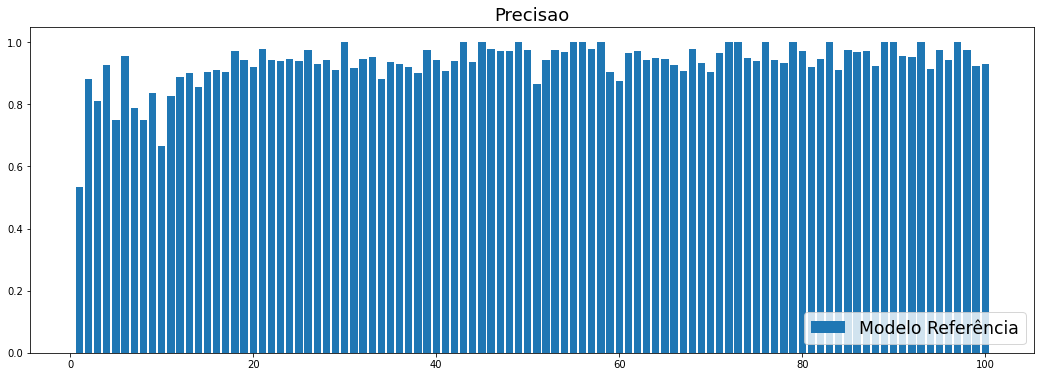

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_0.history['precision'])
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Precisao', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

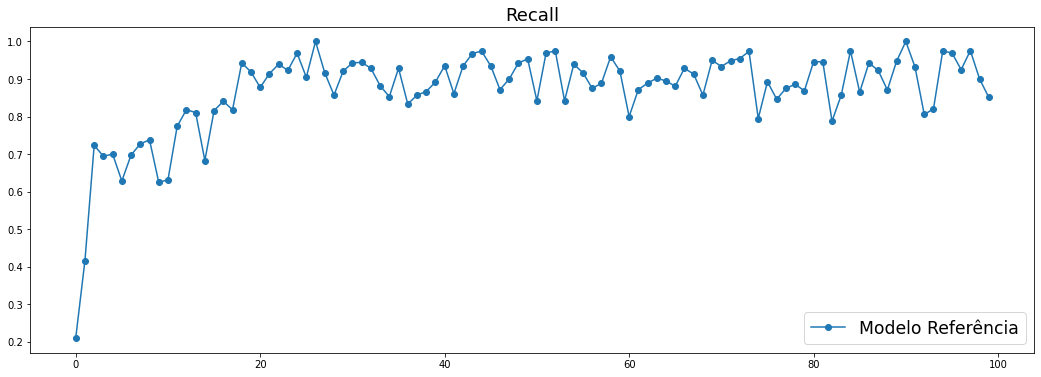

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_0.history['recall'], '-o')
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Recall', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

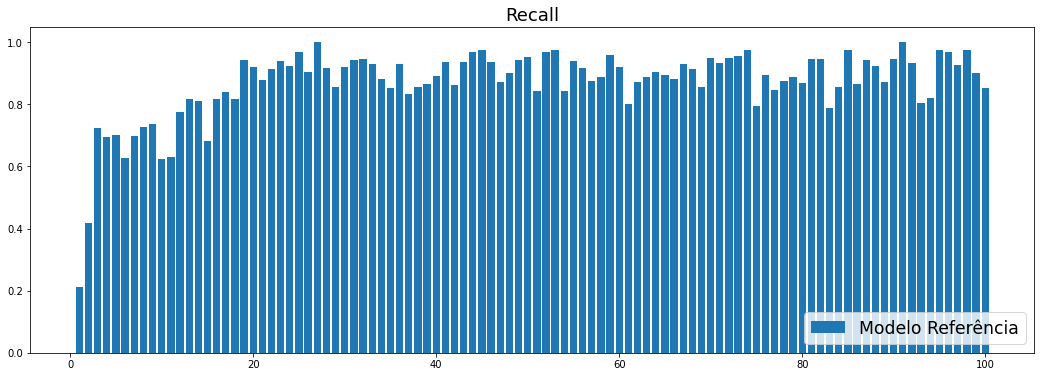

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_0.history['recall'])
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Recall', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

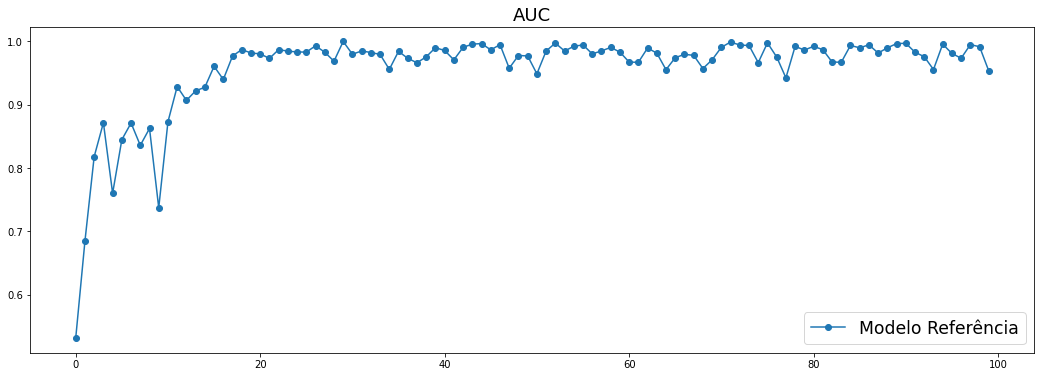

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_0.history['auc'], '-o')
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('AUC', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

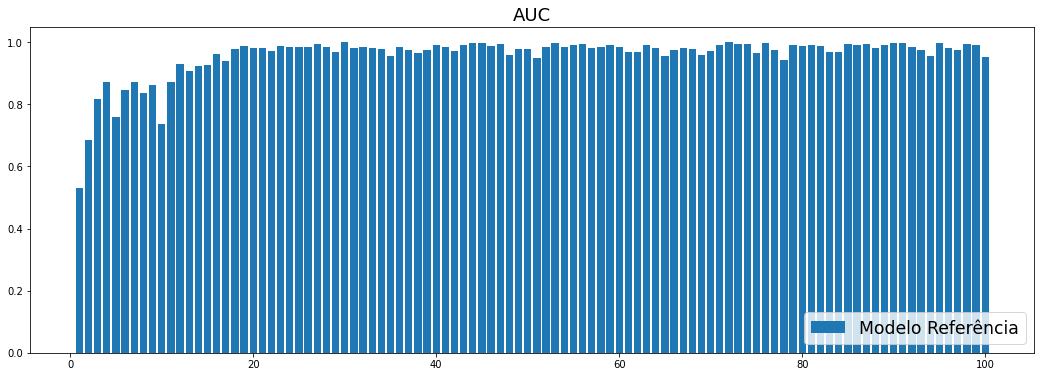

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_0.history['auc'])
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('AUC', fontsize=18)
plt.show


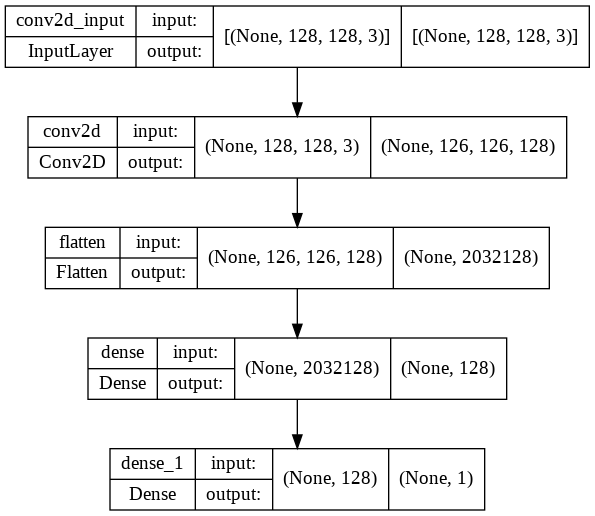

In [ ]:
plot_model(classificador,
           to_file='/content/drive/MyDrive/classificador.png',
           show_shapes=True,
           show_layer_names=True)


In [ ]:
FP = h_0.history['fp'][-1]
FN = h_0.history['fn'][-1]
TP = h_0.history['tp'][-1]
TN = h_0.history['tn'][-1]
LOSS = h_0.history['loss'][-1]
ACC = h_0.history['accuracy'][-1]
PRE = h_0.history['precision'][-1]
REC = h_0.history['recall'][-1]
AUC = h_0.history['auc'][-1]
LR = h_0.history['lr'][-1]

TPR = TP/(TP+FN) # Sensitivity, hit rate, recall, or true positive rate
TNR = TN/(TN+FP) # Specificity or true negative rate
PPV = TP/(TP+FP) # Precision or positive predictive value
NPV = TN/(TN+FN) # Negative predictive value
FPR = FP/(FP+TN) # Fall out or false positive rate
FNR = FN/(TP+FN) # False negative rate
FDR = FP/(TP+FP) # False discovery rate

OACC = (TP+TN)/(TP+FP+FN+TN) # Overall accuracy / F1-score

print("Confusion Matrix : ")
print(f"[{TP}] [{FP}]")
print(f"[{FN}] [{TN}]")

print(f'Accuracy: {ACC}')
print(f'Loss: {LOSS}')
print(f'Precision: {PRE}')
print(f'Recall: {REC}')
print(f'F1 Score: {OACC}%')
print(f'AUC: {AUC}')
print(f'Learning Rate: {LR}')
print(f'Sensitivity, hit rate, recall, or true positive rate: {TPR}%')
print(f'Specificity or true negative rate: {TNR}%')
print(f'Precision or positive predictive value: {PPV}%')
print(f'Negative predictive value: {NPV}%')
print(f'Fall out or false positive rate: {FPR}%')
print(f'False negative rate: {FNR}%')
print(f'False discovery rate: {FDR}%')


Confusion Matrix : 
[40.0] [3.0]
[7.0] [50.0]
Accuracy: 0.8999999761581421
Loss: 0.276264488697052
Precision: 0.930232584476471
Recall: 0.8510638475418091
F1 Score: 0.9%
AUC: 0.9532316327095032
Learning Rate: 1.000000082740371e-10
Sensitivity, hit rate, recall, or true positive rate: 0.851063829787234%
Specificity or true negative rate: 0.9433962264150944%
Precision or positive predictive value: 0.9302325581395349%
Negative predictive value: 0.8771929824561403%
Fall out or false positive rate: 0.05660377358490566%
False negative rate: 0.14893617021276595%
False discovery rate: 0.06976744186046512%


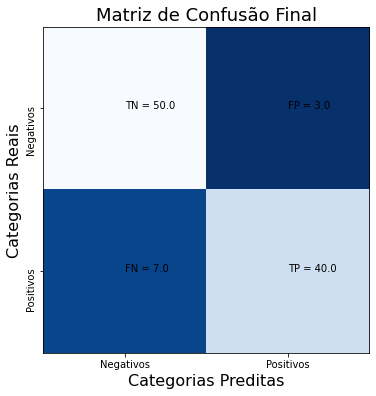

In [ ]:
data = [[TN, FP],[FN,TP]]

plt.clf()
plt.imshow(data, cmap = plt.cm.Blues_r)
classNames = ['Negativos','Positivos']
plt.title('Matriz de Confusão Final', fontsize=18)
plt.ylabel('Categorias Reais', fontsize=16)
plt.xlabel('Categorias Preditas', fontsize=16)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames, rotation=90)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(data[i][j]))
plt.show()


## Classificador Referência

In [ ]:
gerador_treino = ImageDataGenerator(rescale = 1.0/255,
                                    rotation_range = 5,
                                    horizontal_flip = True,
                                    shear_range = 0.2,
                                    height_shift_range = 0.07,
                                    zoom_range = 0.2)
gerador_teste = ImageDataGenerator(rescale = 1.0/255)

base_treino = gerador_treino.flow_from_directory('/content/drive/MyDrive/Documentação - CNN Coluna/dataset/train/',
                                                 target_size = (128,128),
                                                 batch_size = 16,
                                                 class_mode = 'binary')
base_teste = gerador_teste.flow_from_directory('/content/drive/MyDrive/Documentação - CNN Coluna/dataset/test/',
                                               target_size = (128,128),
                                               batch_size = 16,
                                               class_mode = 'binary')

classificador = Sequential()
classificador.add(Conv2D(128,
                         kernel_size = (3,3),
                         input_shape = (128,128,3),
                         activation = 'relu'))
classificador.add(BatchNormalization())
classificador.add(MaxPooling2D(pool_size = (2,2)))
classificador.add(Conv2D(32,
                         (3,3),
                         activation = 'relu'))
classificador.add(BatchNormalization())
classificador.add(MaxPooling2D(pool_size = (2,2)))
classificador.add(Flatten())
classificador.add(Dense(units = 128,
                        activation = 'relu'))
classificador.add(Dense(units = 128,
                        activation = 'relu'))
classificador.add(Dense(units = 1,
                        activation = 'sigmoid'))
optimizer = RMSprop(lr=0.001,
                    rho=0.9,
                    epsilon=1e-08,
                    decay=0.0)
classificador.compile(optimizer = optimizer,
                      loss = 'binary_crossentropy',
                      metrics = METRICS)

epochs = 100

learning_rate = ReduceLROnPlateau(monitor='accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

h_1 = classificador.fit(base_treino,
                        steps_per_epoch = 100,
                        epochs = epochs,
                        validation_data = base_teste,
                        callbacks = [learning_rate],
                        verbose = 1,
                        validation_steps = 25)

classificador.save_weights('/content/drive/MyDrive/classificador_weights.h5')
classificador.save('/content/drive/MyDrive/classificador_model.h5')


Found 2392 images belonging to 2 classes.
Found 505 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/100
100/100 [==============================] - 20s 161ms/step - loss: 2.0010 - tp: 448.0000 - fp: 204.0000 - tn: 768.0000 - fn: 197.0000 - accuracy: 0.7520 - precision: 0.6871 - recall: 0.6946 - auc: 0.7864 - val_loss: 0.4181 - val_tp: 201.0000 - val_fp: 139.0000 - val_tn: 60.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.6525 - val_precision: 0.5912 - val_recall: 1.0000 - val_auc: 0.9989 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 15s 146ms/step - loss: 0.7526 - tp: 465.0000 - fp: 113.0000 - tn: 876.0000 - fn: 138.0000 - accuracy: 0.8423 - precision: 0.8045 - recall: 0.7711 - auc: 0.8843 - val_loss: 0.9188 - val_tp: 208.0000 - val_fp: 192.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5200 - val_precision: 0.5200 - val_recall: 1.0000 - val_auc: 0.2902 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 14s 141ms/step - loss: 0.6392 - tp: 521.0000 - fp: 95.0000 - tn: 862.0000 - fn: 114.0000 - accuracy: 0.8687 - precision: 0

In [ ]:
classificador.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 126, 126, 128)     3584      
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 32)        36896     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 32)       128       
 hNormalization)                                                 
                                                      

In [ ]:
keras2ascii(classificador)


           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####    128  128    3
              Conv2D    \|/  -------------------      3584     0.1%
                relu   #####    126  126  128
  BatchNormalization    μ|σ  -------------------       512     0.0%
                       #####    126  126  128
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     63   63  128
              Conv2D    \|/  -------------------     36896     1.0%
                relu   #####     61   61   32
  BatchNormalization    μ|σ  -------------------       128     0.0%
                       #####     61   61   32
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     30   30   32
             Flatten   ||||| -------------------         0     0.0%
                       #####       28800
               Dense   XXXXX -------------------   3686528    98.5%
                rel

In [ ]:
print('Acuracia do treino: {0:.2f}%'.format(max(h_1.history['accuracy']) * 100))
print('Acuracia da validacao: {0:.2f}%'.format(max(h_1.history['val_accuracy']) * 100))


Acuracia do treino: 95.75%
Acuracia da validacao: 99.25%


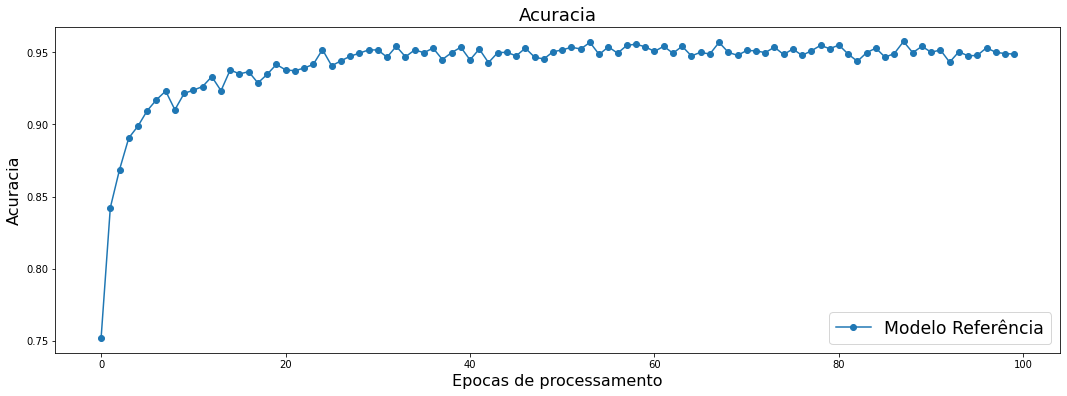

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_1.history['accuracy'], '-o')
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Acuracia', fontsize=18)
plt.show()


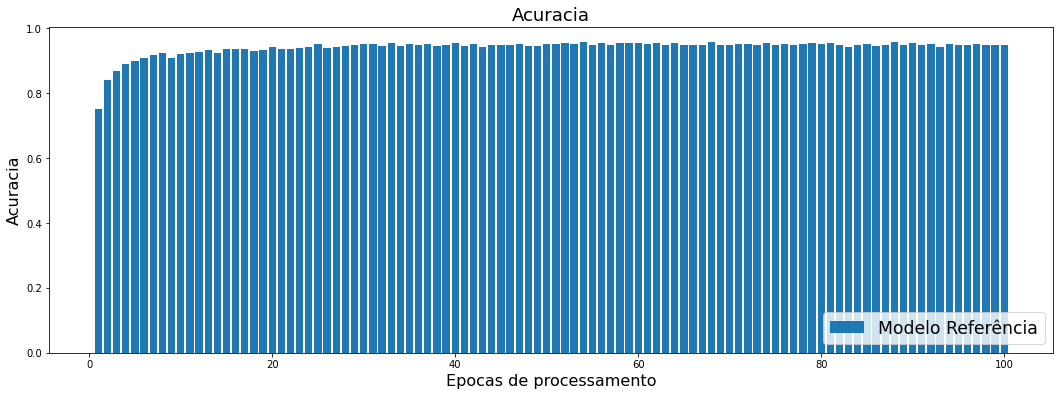

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_1.history['accuracy'])
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Acuracia', fontsize=18)
plt.show()


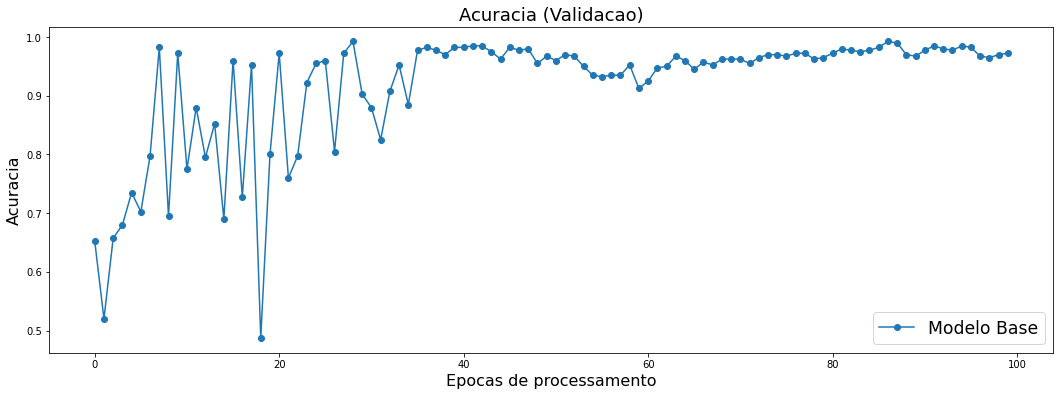

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_1.history['val_accuracy'], '-o')
plt.legend(['Modelo Base'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Acuracia (Validacao)', fontsize=18)
plt.show()


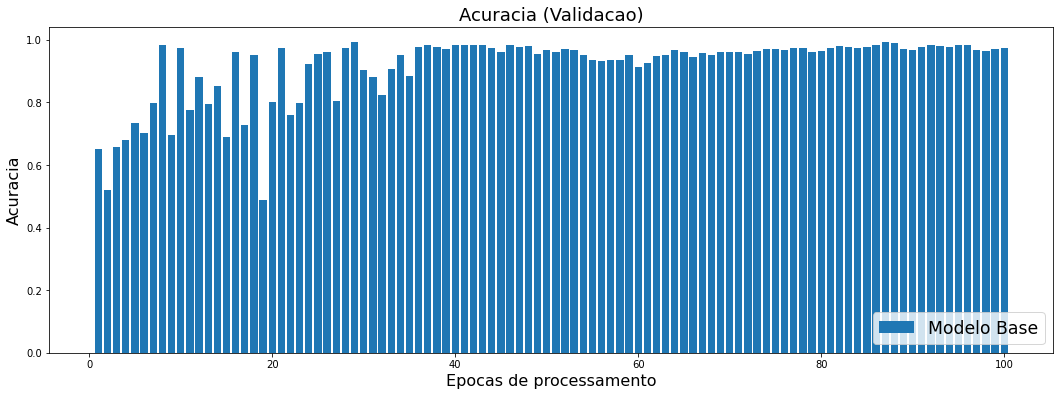

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_1.history['val_accuracy'])
plt.legend(['Modelo Base'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Acuracia (Validacao)', fontsize=18)
plt.show()


<function matplotlib.pyplot.show>

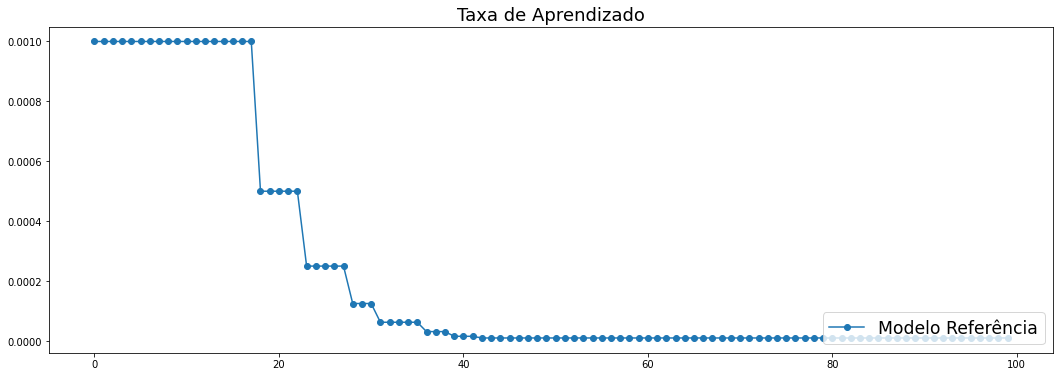

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_1.history['lr'], '-o')
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Taxa de Aprendizado', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

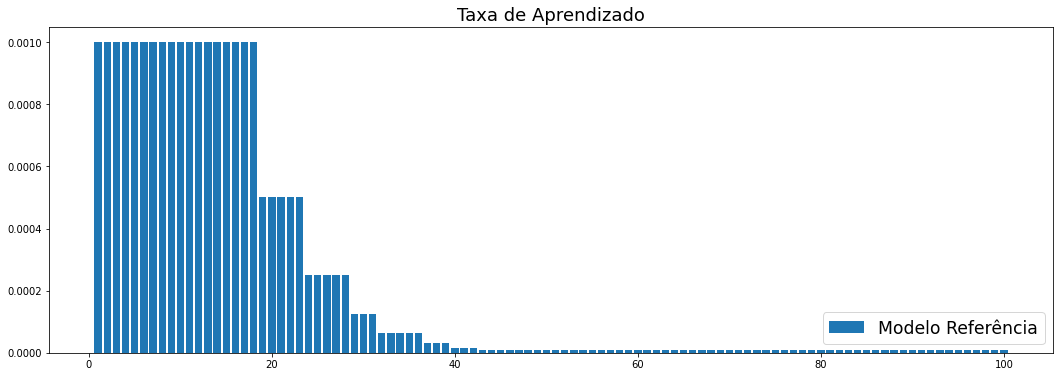

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_1.history['lr'])
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Taxa de Aprendizado', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

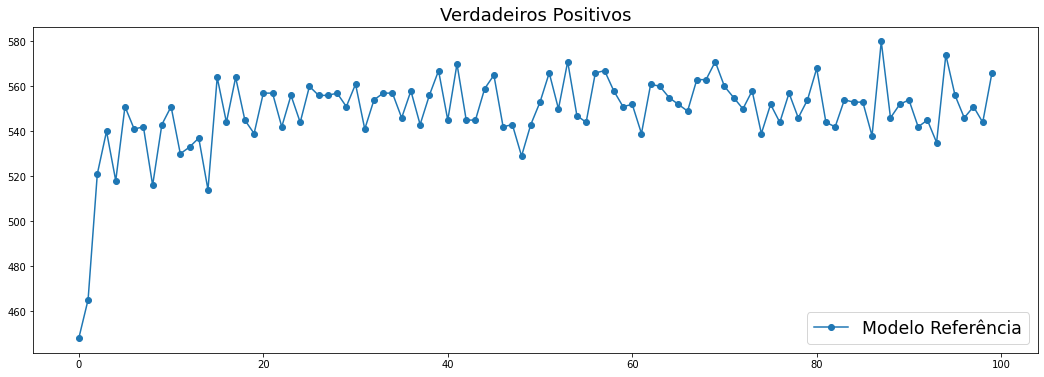

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_1.history['tp'], '-o')
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Verdadeiros Positivos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

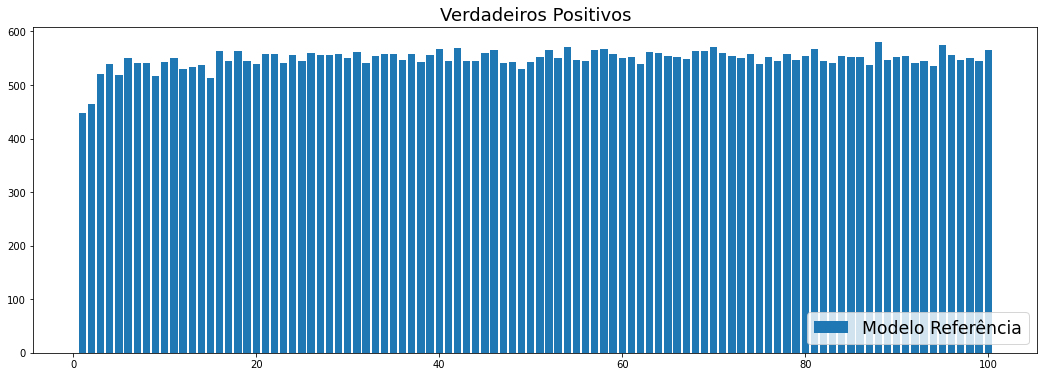

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_1.history['tp'])
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Verdadeiros Positivos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

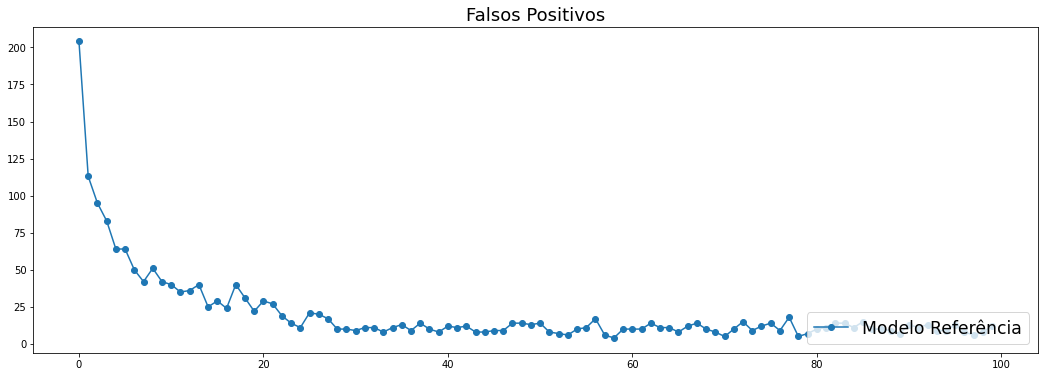

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_1.history['fp'], '-o')
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Falsos Positivos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

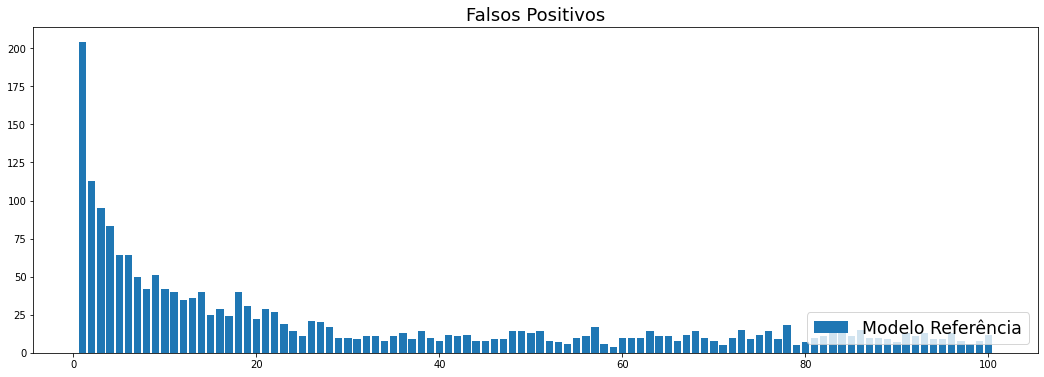

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_1.history['fp'])
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Falsos Positivos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

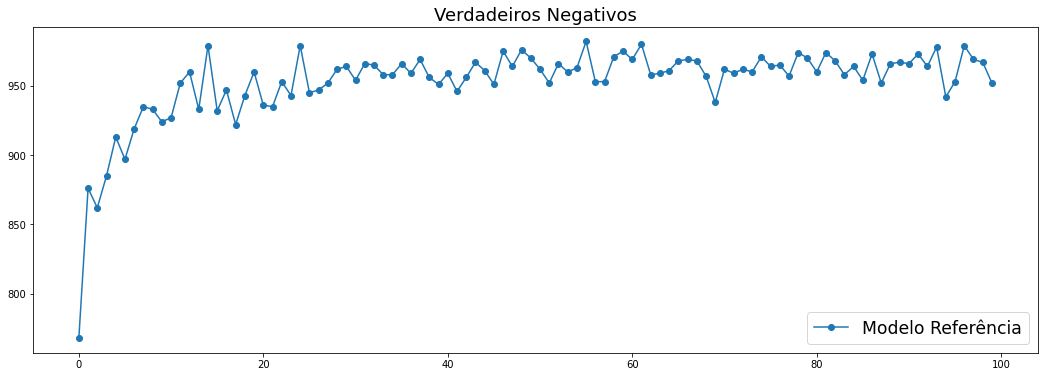

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_1.history['tn'], '-o')
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Verdadeiros Negativos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

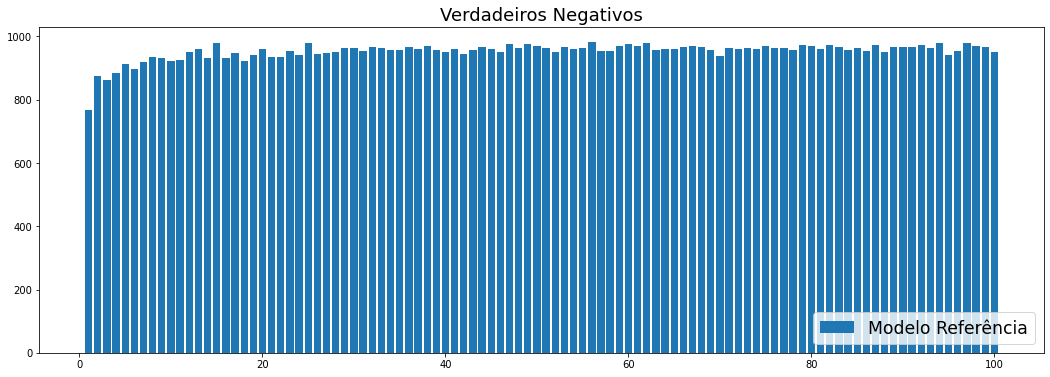

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_1.history['tn'])
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Verdadeiros Negativos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

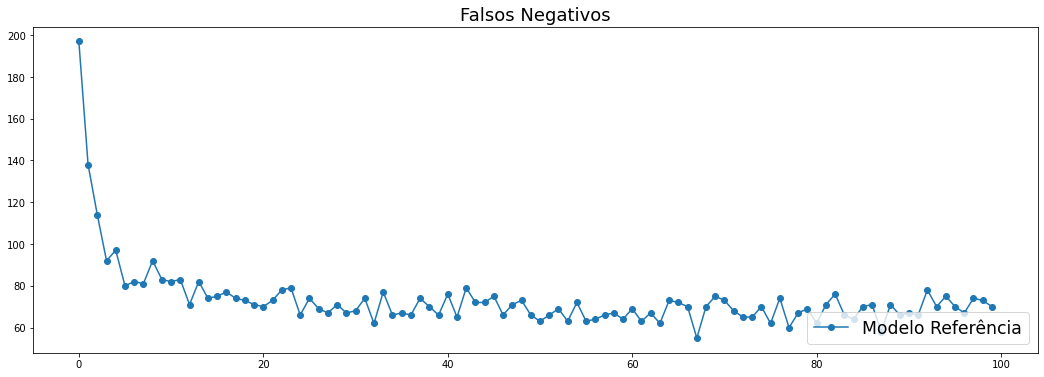

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_1.history['fn'], '-o')
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Falsos Negativos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

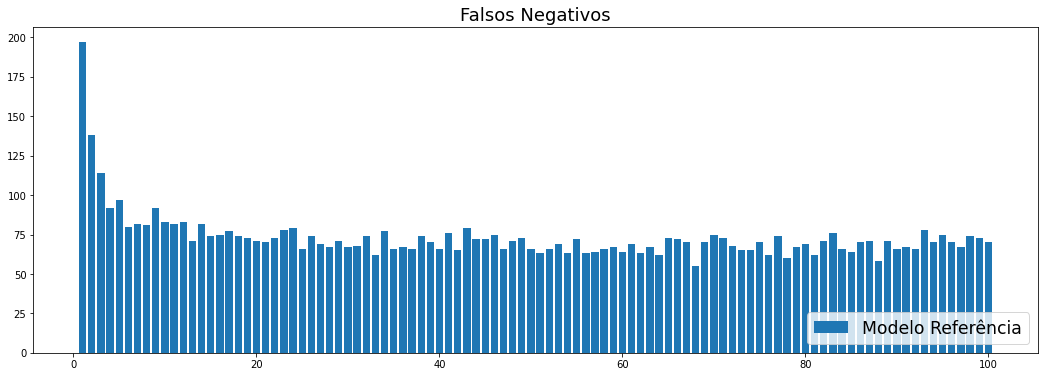

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_1.history['fn'])
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Falsos Negativos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

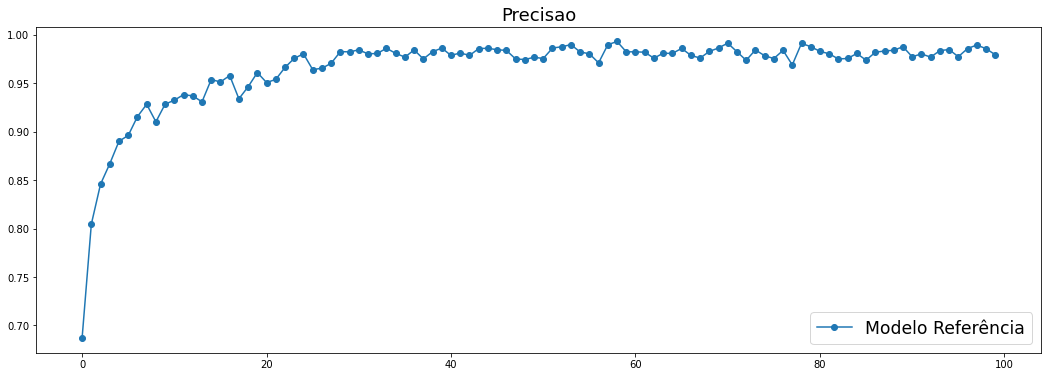

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_1.history['precision'], '-o')
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Precisao', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

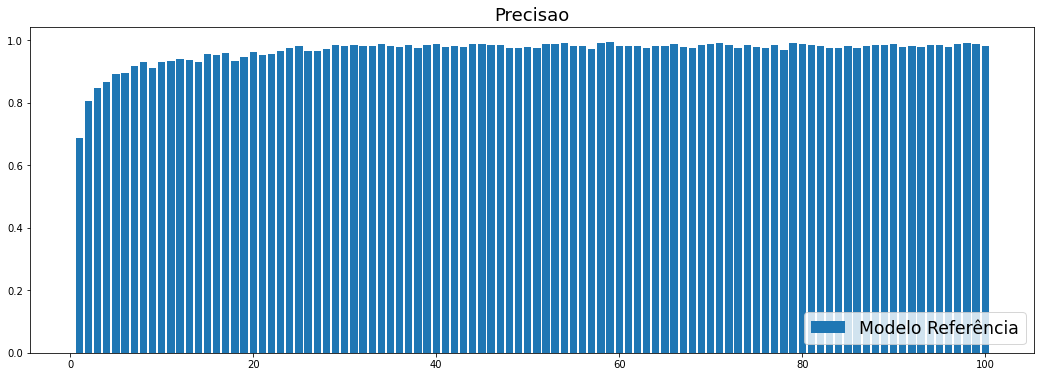

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_1.history['precision'])
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Precisao', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

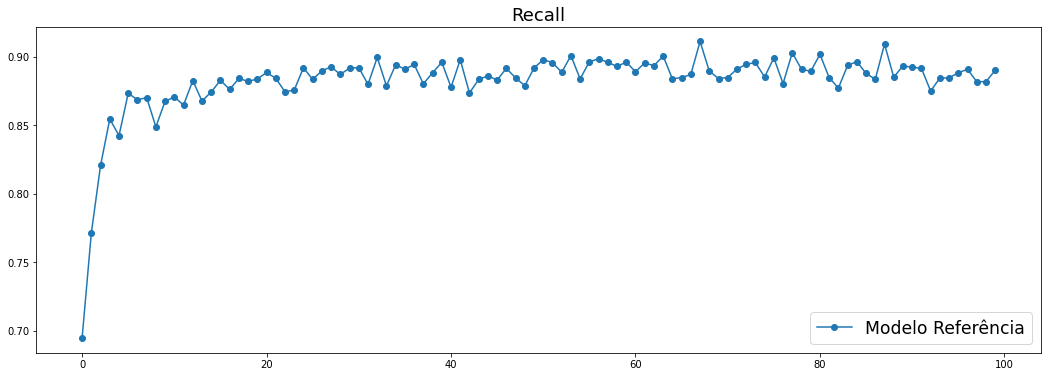

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_1.history['recall'], '-o')
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Recall', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

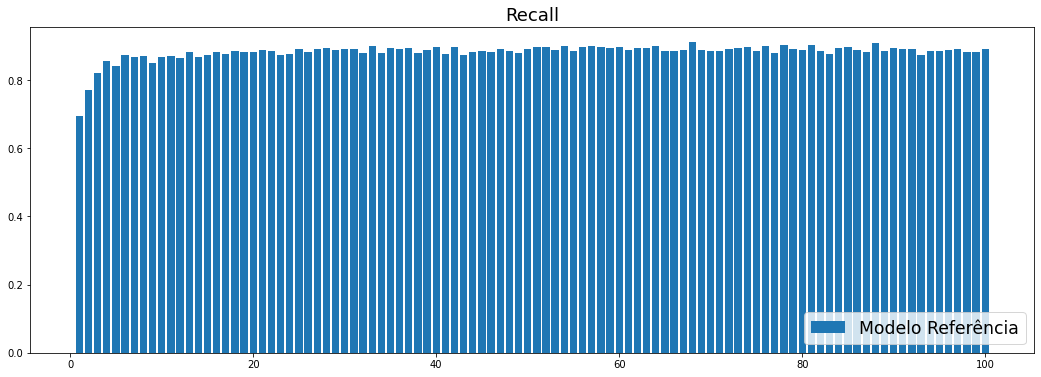

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_1.history['recall'])
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Recall', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

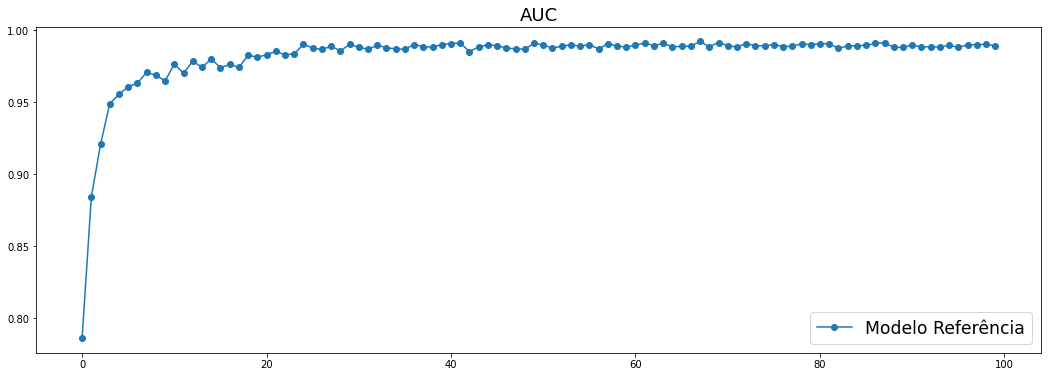

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_1.history['auc'], '-o')
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('AUC', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

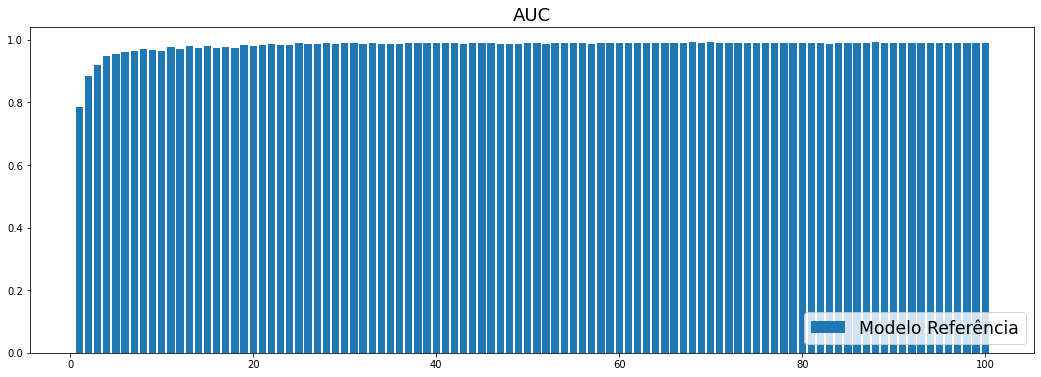

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_1.history['auc'])
plt.legend(['Modelo Referência'], loc = 'lower right', fontsize = 'xx-large')
plt.title('AUC', fontsize=18)
plt.show


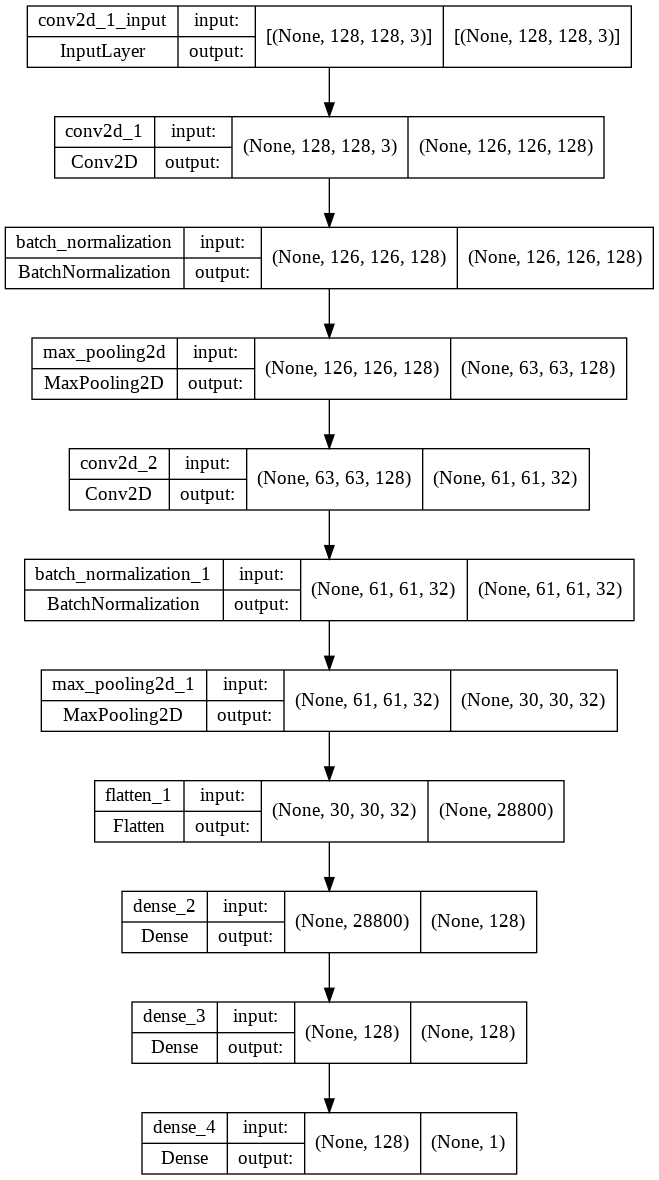

In [ ]:
plot_model(classificador,
           to_file='/content/drive/MyDrive/classificador.png',
           show_shapes=True,
           show_layer_names=True)


In [ ]:
FP = h_1.history['fp'][-1]
FN = h_1.history['fn'][-1]
TP = h_1.history['tp'][-1]
TN = h_1.history['tn'][-1]
LOSS = h_1.history['loss'][-1]
ACC = h_1.history['accuracy'][-1]
PRE = h_1.history['precision'][-1]
REC = h_1.history['recall'][-1]
AUC = h_1.history['auc'][-1]
LR = h_1.history['lr'][-1]

TPR = TP/(TP+FN) # Sensitivity, hit rate, recall, or true positive rate
TNR = TN/(TN+FP) # Specificity or true negative rate
PPV = TP/(TP+FP) # Precision or positive predictive value
NPV = TN/(TN+FN) # Negative predictive value
FPR = FP/(FP+TN) # Fall out or false positive rate
FNR = FN/(TP+FN) # False negative rate
FDR = FP/(TP+FP) # False discovery rate

OACC = (TP+TN)/(TP+FP+FN+TN) # Overall accuracy / F1-score

print("Confusion Matrix : ")
print(f"[{TP}] [{FP}]")
print(f"[{FN}] [{TN}]")

print(f'Accuracy: {ACC}')
print(f'Loss: {LOSS}')
print(f'Precision: {PRE}')
print(f'Recall: {REC}')
print(f'F1 Score: {OACC}%')
print(f'AUC: {AUC}')
print(f'Learning Rate: {LR}')
print(f'Sensitivity, hit rate, recall, or true positive rate: {TPR}%')
print(f'Specificity or true negative rate: {TNR}%')
print(f'Precision or positive predictive value: {PPV}%')
print(f'Negative predictive value: {NPV}%')
print(f'Fall out or false positive rate: {FPR}%')
print(f'False negative rate: {FNR}%')
print(f'False discovery rate: {FDR}%')


Confusion Matrix : 
[566.0] [12.0]
[70.0] [952.0]
Accuracy: 0.9487500190734863
Loss: 0.10879213362932205
Precision: 0.979238748550415
Recall: 0.8899371027946472
F1 Score: 0.94875%
AUC: 0.9893493056297302
Learning Rate: 9.999999747378752e-06
Sensitivity, hit rate, recall, or true positive rate: 0.889937106918239%
Specificity or true negative rate: 0.9875518672199171%
Precision or positive predictive value: 0.9792387543252595%
Negative predictive value: 0.9315068493150684%
Fall out or false positive rate: 0.012448132780082987%
False negative rate: 0.11006289308176101%
False discovery rate: 0.020761245674740483%


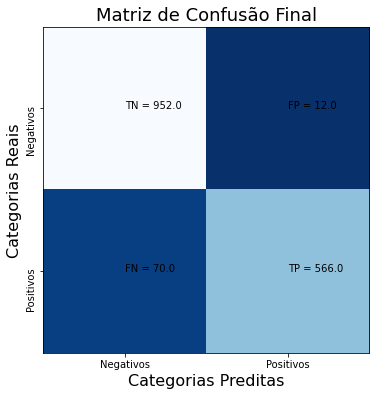

In [ ]:
data = [[TN, FP],[FN,TP]]

plt.clf()
plt.imshow(data, cmap = plt.cm.Blues_r)
classNames = ['Negativos','Positivos']
plt.title('Matriz de Confusão Final', fontsize=18)
plt.ylabel('Categorias Reais', fontsize=16)
plt.xlabel('Categorias Preditas', fontsize=16)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames, rotation=90)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(data[i][j]))
plt.show()


## Classificador x1

In [ ]:
gerador_treino = ImageDataGenerator(rescale = 1.0/255,
                                    rotation_range = 5,
                                    horizontal_flip = True,
                                    shear_range = 0.2,
                                    height_shift_range = 0.07,
                                    zoom_range = 0.2)
gerador_teste = ImageDataGenerator(rescale = 1.0/255)

base_treino = gerador_treino.flow_from_directory('/content/drive/MyDrive/Documentação - CNN Coluna/dataset/train/',
                                                 target_size = (128,128),
                                                 batch_size = 16,
                                                 class_mode = 'binary')
base_teste = gerador_teste.flow_from_directory('/content/drive/MyDrive/Documentação - CNN Coluna/dataset/test/',
                                               target_size = (128,128),
                                               batch_size = 16,
                                               class_mode = 'binary')

classificadorx1 = Sequential()
classificadorx1.add(Conv2D(128,
                         kernel_size = (6,6),
                         padding = 'same',
                         input_shape = (128,128,3),
                         activation = 'relu'))
classificadorx1.add(BatchNormalization())
classificadorx1.add(MaxPooling2D(pool_size = (2,2)))
classificadorx1.add(Flatten())
classificadorx1.add(Dense(units = 128,
                        activation = 'relu'))
classificadorx1.add(Dropout(0.2))
classificadorx1.add(Dense(units = 128,
                        activation = 'relu'))
classificadorx1.add(Dropout(0.2))
classificadorx1.add(Dense(units = 1,
                        activation = 'sigmoid'))
optimizer = RMSprop(learning_rate=0.001,
                    rho=0.9,
                    epsilon=1e-08,
                    decay=0.0)
classificadorx1.compile(optimizer = optimizer,
                      loss = 'binary_crossentropy',
                      metrics = METRICS)

epochs = 100

learning_rate = ReduceLROnPlateau(monitor='accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

h_x1 = classificadorx1.fit(base_treino,
                        steps_per_epoch = 100,
                        epochs = epochs,
                        validation_data = base_teste,
                        callbacks = [learning_rate],
                        verbose = 1,
                        validation_steps = 25)

classificadorx1.save_weights('/content/drive/MyDrive/classificador_x1_weights.h5')
classificadorx1.save('/content/drive/MyDrive/classificador_x1_model.h5')


Found 2392 images belonging to 2 classes.
Found 505 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 18s 154ms/step - loss: 5.1043 - tp: 583.0000 - fp: 199.0000 - tn: 978.0000 - fn: 240.0000 - accuracy: 0.7805 - precision: 0.7455 - recall: 0.7084 - auc: 0.8156 - val_loss: 1.4365 - val_tp: 217.0000 - val_fp: 179.0000 - val_tn: 4.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5525 - val_precision: 0.5480 - val_recall: 1.0000 - val_auc: 0.7993 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 15s 149ms/step - loss: 1.2542 - tp: 424.0000 - fp: 172.0000 - tn: 798.0000 - fn: 198.0000 - accuracy: 0.7676 - precision: 0.7114 - recall: 0.6817 - auc: 0.7995 - val_loss: 0.8292 - val_tp: 204.0000 - val_fp: 133.0000 - val_tn: 63.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.6675 - val_precision: 0.6053 - val_recall: 1.0000 - val_auc: 0.9255 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 15s 150ms/step - loss: 1.1244 - tp: 438.000

In [ ]:
classificadorx1.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 128)     13952     
                                                                 
 batch_normalization_2 (Batc  (None, 128, 128, 128)    512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 524288)            0         
                                                                 
 dense_5 (Dense)             (None, 128)               67108992  
                                                                 
 dropout (Dropout)           (None, 128)              

In [ ]:
keras2ascii(classificadorx1)


           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####    128  128    3
              Conv2D    \|/  -------------------     13952     0.0%
                relu   #####    128  128  128
  BatchNormalization    μ|σ  -------------------       512     0.0%
                       #####    128  128  128
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     64   64  128
             Flatten   ||||| -------------------         0     0.0%
                       #####      524288
               Dense   XXXXX -------------------  67108992   100.0%
                relu   #####         128
             Dropout    | || -------------------         0     0.0%
                       #####         128
               Dense   XXXXX -------------------     16512     0.0%
                relu   #####         128
             Dropout    | || -------------------         0     0.0%
                       #####      

In [ ]:
print('Acuracia do treino: {0:.2f}%'.format(max(h_x1.history['accuracy']) * 100))
print('Acuracia da validacao: {0:.2f}%'.format(max(h_x1.history['val_accuracy']) * 100))


Acuracia do treino: 95.04%
Acuracia da validacao: 100.00%


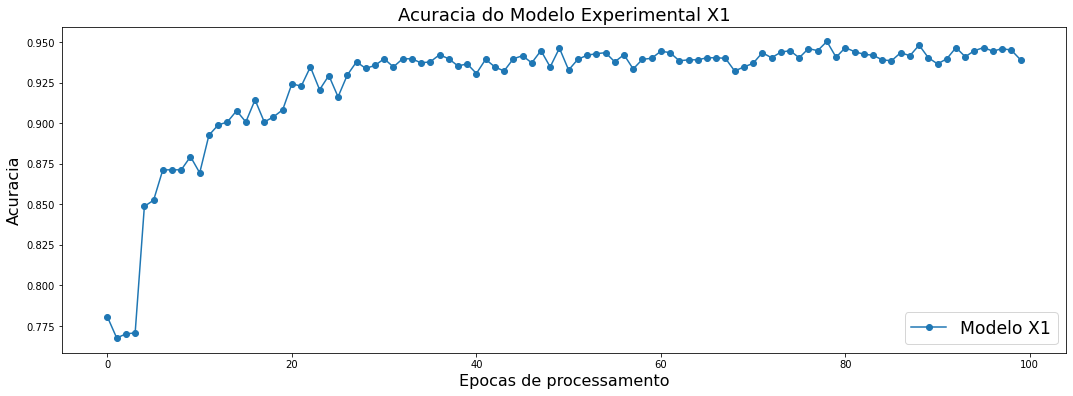

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x1.history['accuracy'], '-o')
plt.legend(['Modelo X1'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Acuracia do Modelo Experimental X1', fontsize=18)
plt.show()


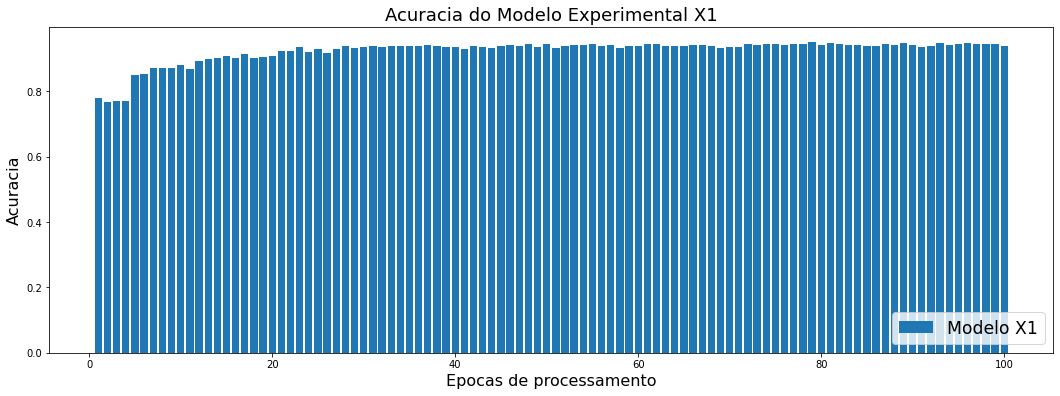

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x1.history['accuracy'])
plt.legend(['Modelo X1'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Acuracia do Modelo Experimental X1', fontsize=18)
plt.show()


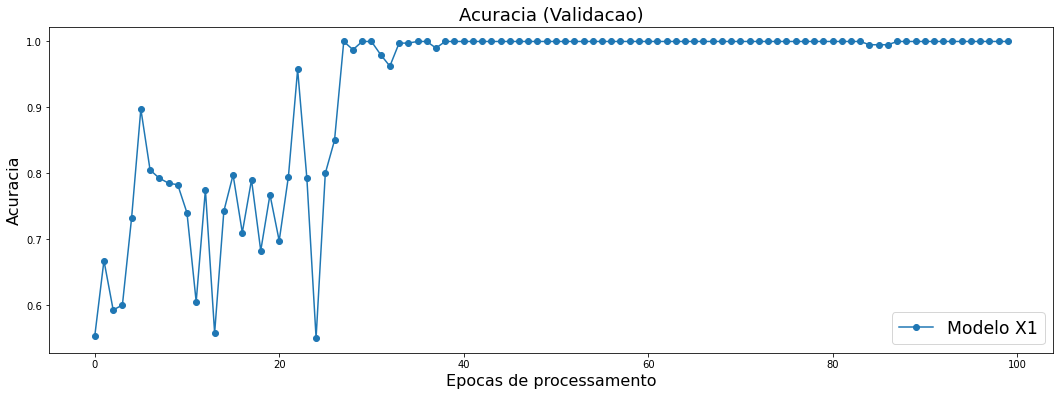

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x1.history['val_accuracy'], '-o')
plt.legend(['Modelo X1'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Acuracia (Validacao)', fontsize=18)
plt.show()


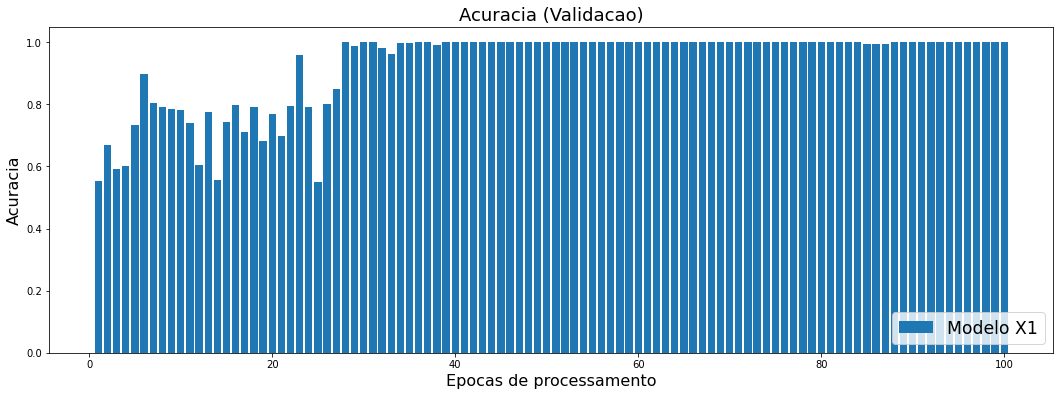

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x1.history['val_accuracy'])
plt.legend(['Modelo X1'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Acuracia (Validacao)', fontsize=18)
plt.show()


<function matplotlib.pyplot.show>

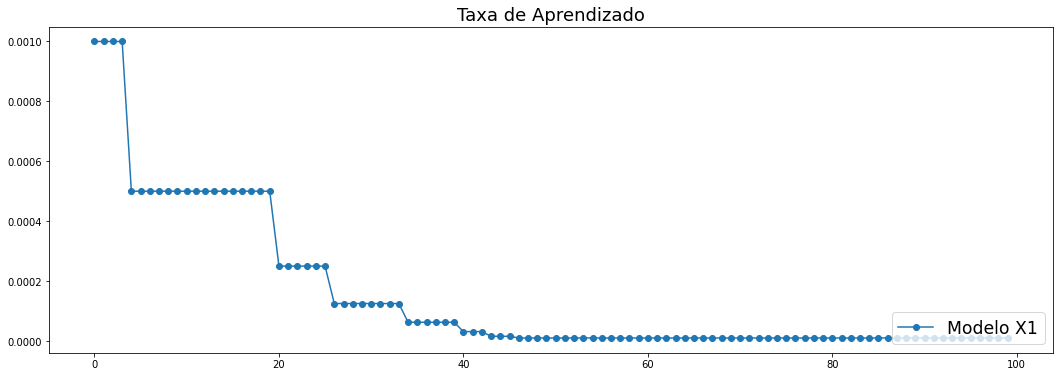

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x1.history['lr'], '-o')
plt.legend(['Modelo X1'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Taxa de Aprendizado', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

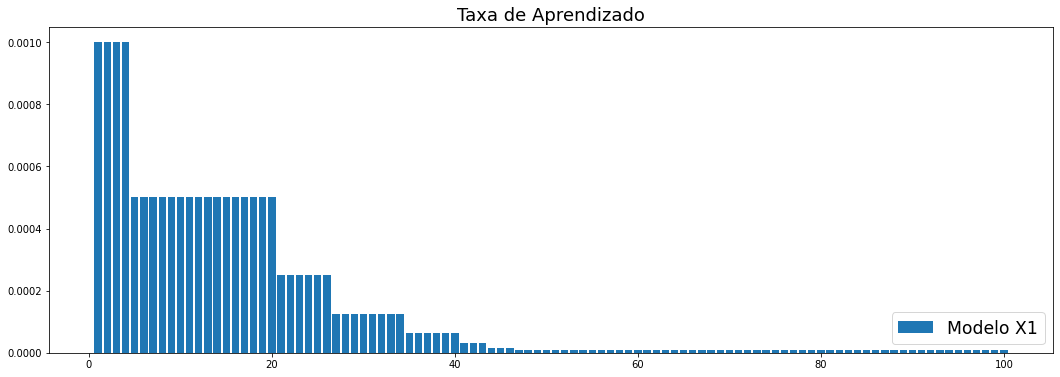

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x1.history['lr'])
plt.legend(['Modelo X1'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Taxa de Aprendizado', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

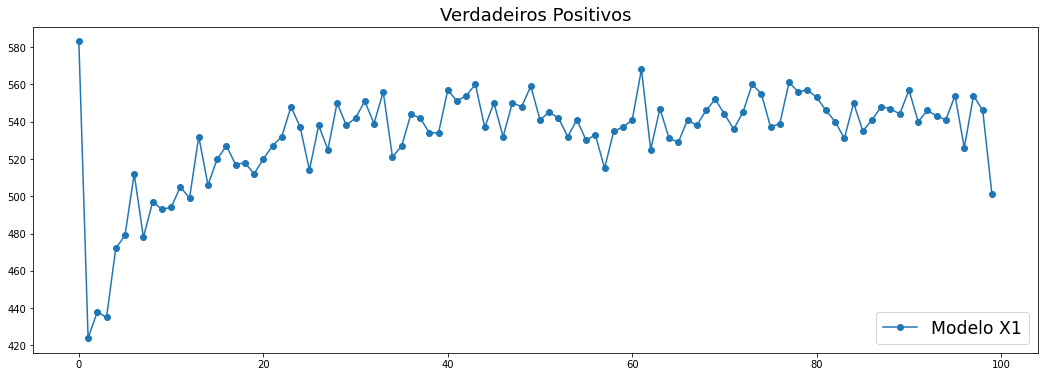

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x1.history['tp'], '-o')
plt.legend(['Modelo X1'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Verdadeiros Positivos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

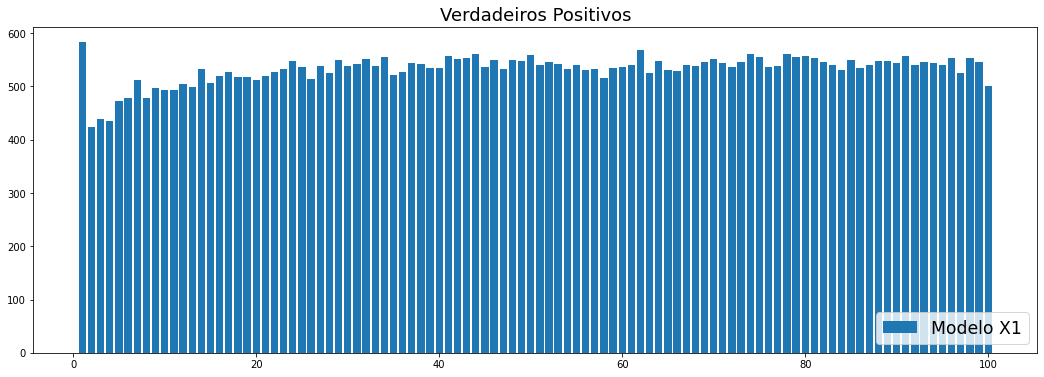

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x1.history['tp'])
plt.legend(['Modelo X1'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Verdadeiros Positivos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

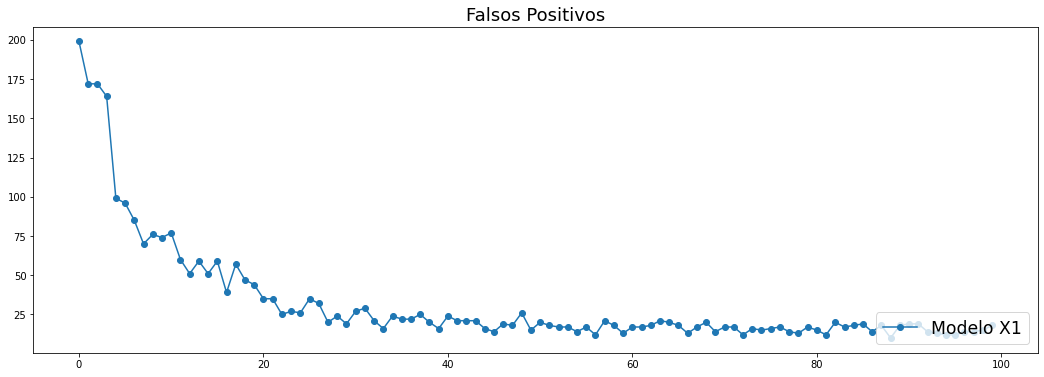

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x1.history['fp'], '-o')
plt.legend(['Modelo X1'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Falsos Positivos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

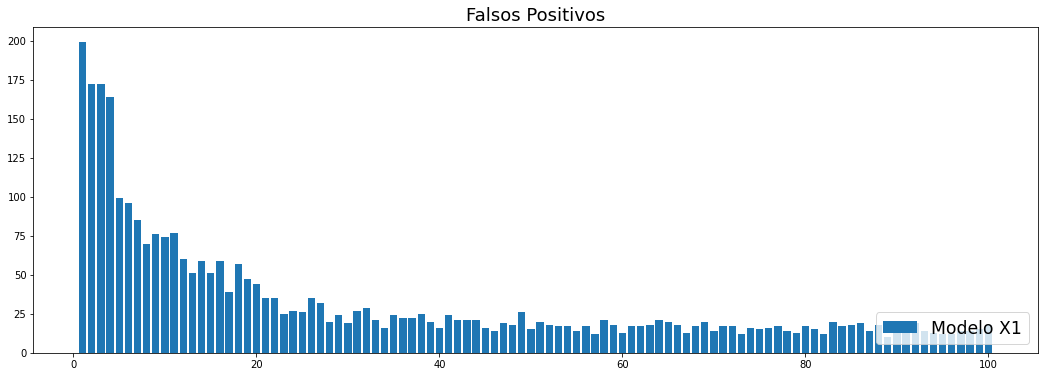

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x1.history['fp'])
plt.legend(['Modelo X1'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Falsos Positivos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

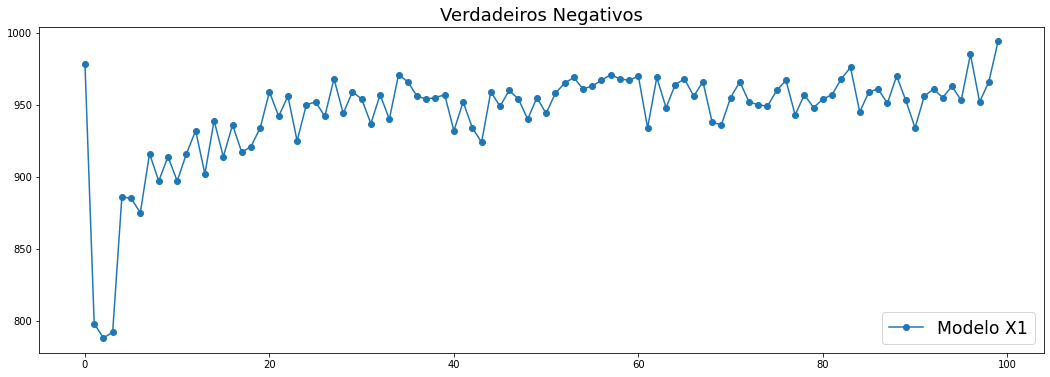

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x1.history['tn'], '-o')
plt.legend(['Modelo X1'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Verdadeiros Negativos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

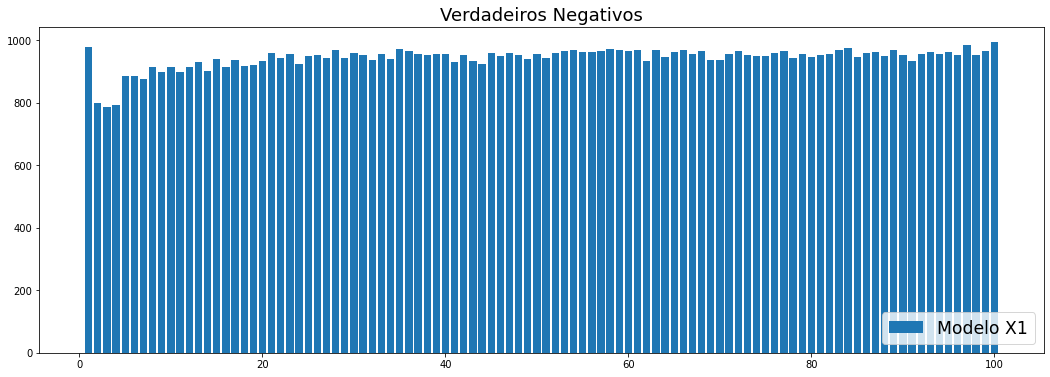

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x1.history['tn'])
plt.legend(['Modelo X1'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Verdadeiros Negativos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

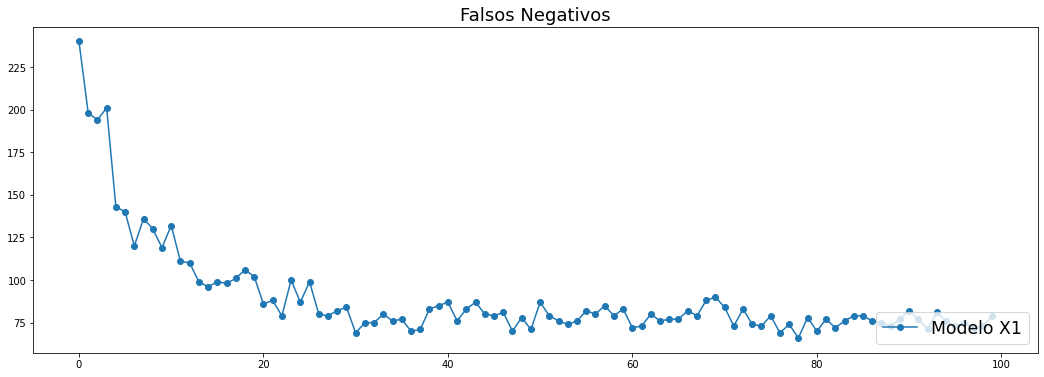

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x1.history['fn'], '-o')
plt.legend(['Modelo X1'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Falsos Negativos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

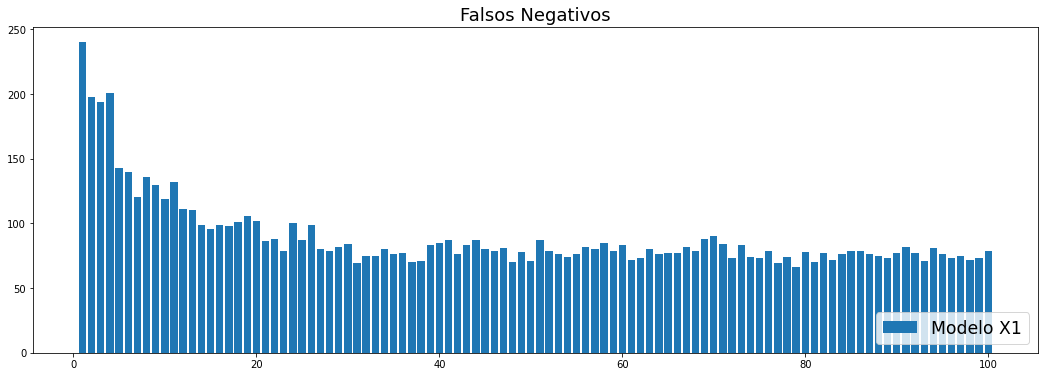

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x1.history['fn'])
plt.legend(['Modelo X1'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Falsos Negativos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

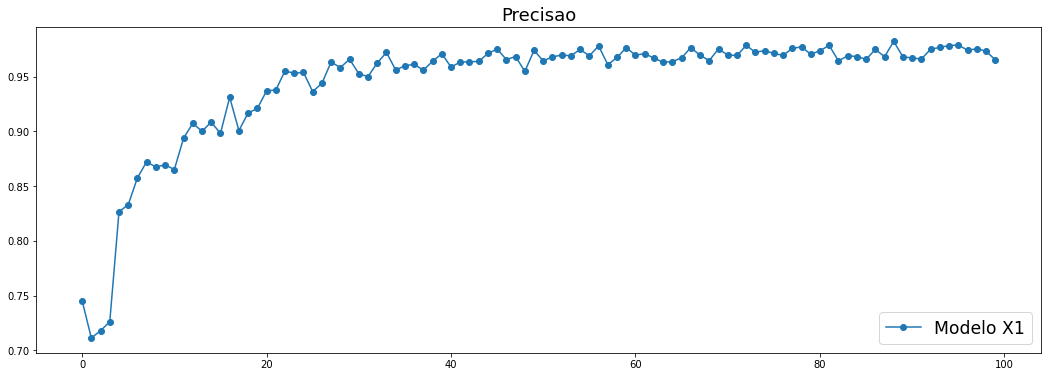

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x1.history['precision'], '-o')
plt.legend(['Modelo X1'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Precisao', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

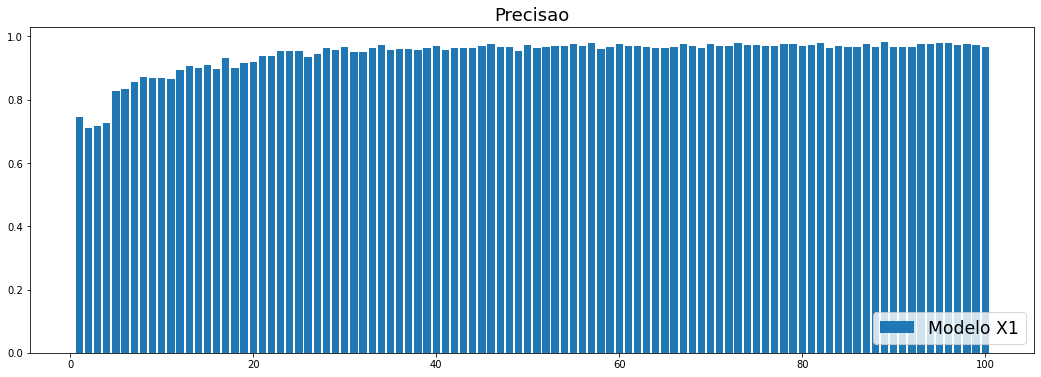

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x1.history['precision'])
plt.legend(['Modelo X1'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Precisao', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

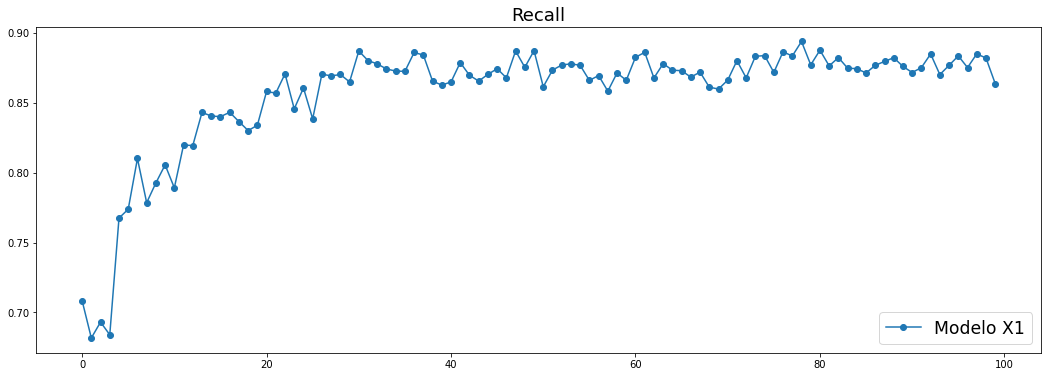

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x1.history['recall'], '-o')
plt.legend(['Modelo X1'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Recall', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

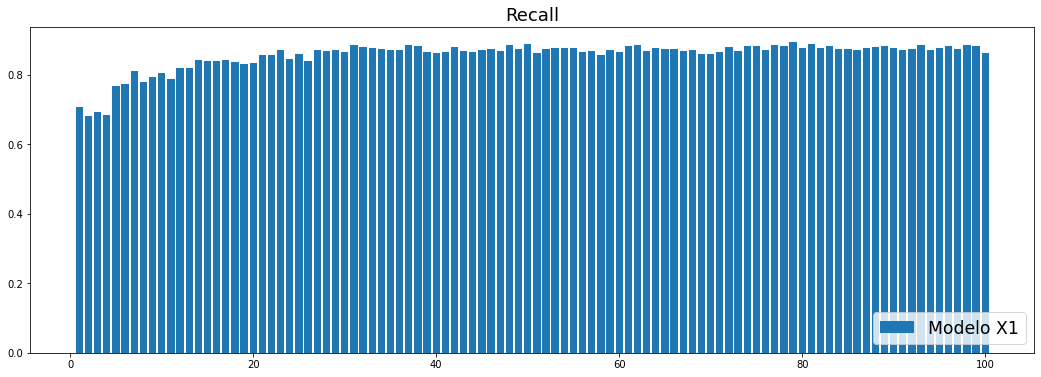

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x1.history['recall'])
plt.legend(['Modelo X1'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Recall', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

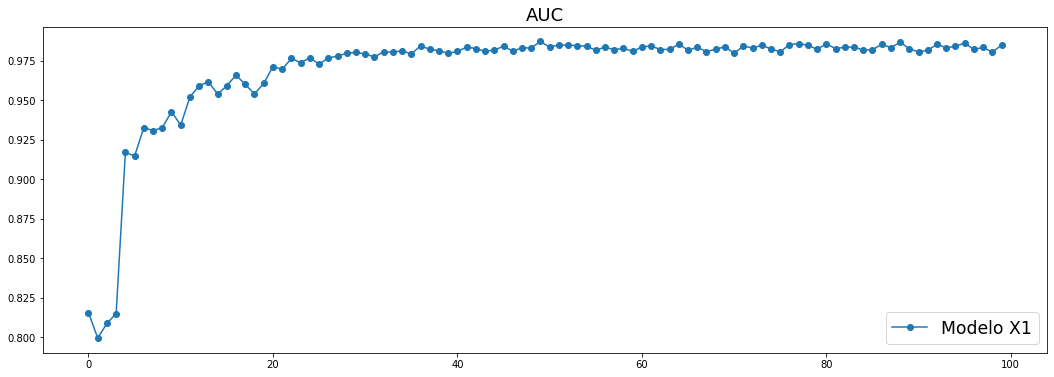

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x1.history['auc'], '-o')
plt.legend(['Modelo X1'], loc = 'lower right', fontsize = 'xx-large')
plt.title('AUC', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

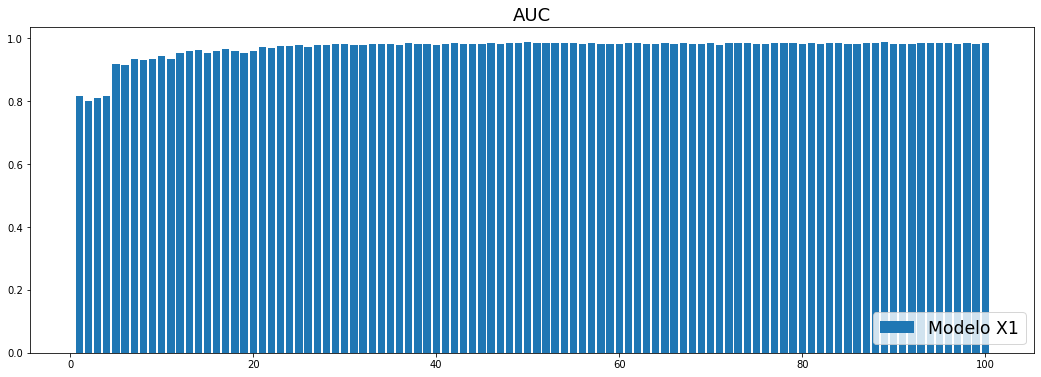

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x1.history['auc'])
plt.legend(['Modelo X1'], loc = 'lower right', fontsize = 'xx-large')
plt.title('AUC', fontsize=18)
plt.show


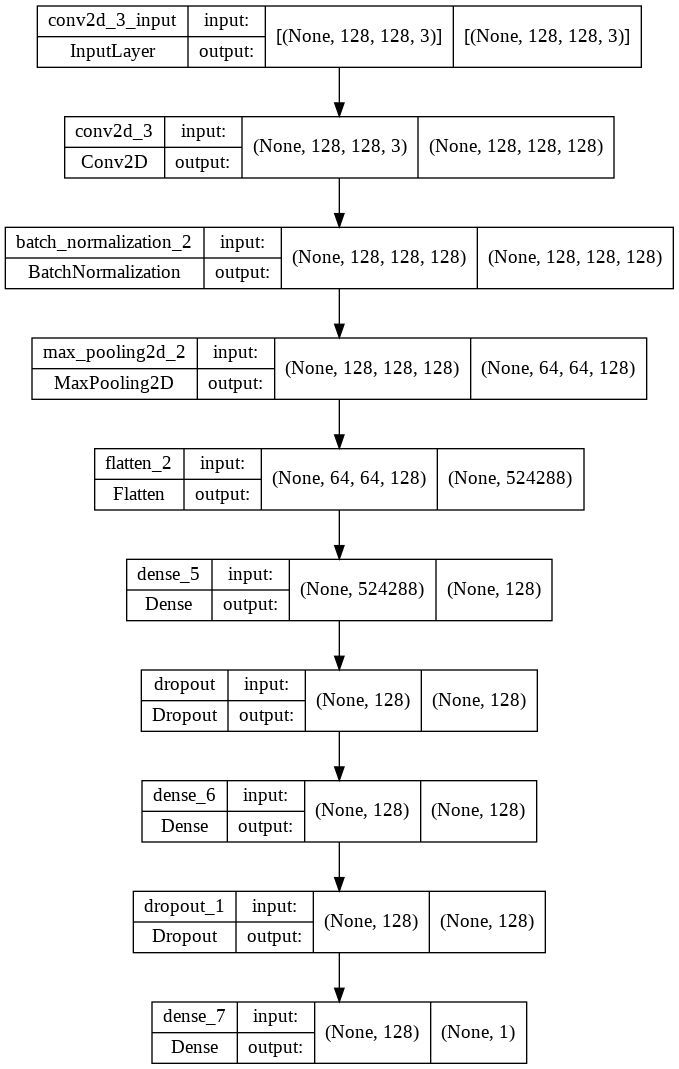

In [ ]:
plot_model(classificadorx1,
           to_file='/content/drive/MyDrive/classificador_x1.png',
           show_shapes=True,
           show_layer_names=True)


In [ ]:
FP = h_x1.history['fp'][-1]
FN = h_x1.history['fn'][-1]
TP = h_x1.history['tp'][-1]
TN = h_x1.history['tn'][-1]
LOSS = h_x1.history['loss'][-1]
ACC = h_x1.history['accuracy'][-1]
PRE = h_x1.history['precision'][-1]
REC = h_x1.history['recall'][-1]
AUC = h_x1.history['auc'][-1]
LR = h_x1.history['lr'][-1]

TPR = TP/(TP+FN) # Sensitivity, hit rate, recall, or true positive rate
TNR = TN/(TN+FP) # Specificity or true negative rate
PPV = TP/(TP+FP) # Precision or positive predictive value
NPV = TN/(TN+FN) # Negative predictive value
FPR = FP/(FP+TN) # Fall out or false positive rate
FNR = FN/(TP+FN) # False negative rate
FDR = FP/(TP+FP) # False discovery rate

OACC = (TP+TN)/(TP+FP+FN+TN) # Overall accuracy / F1-score

print("Confusion Matrix : ")
print(f"[{TP}] [{FP}]")
print(f"[{FN}] [{TN}]")

print(f'Accuracy: {ACC}')
print(f'Loss: {LOSS}')
print(f'Precision: {PRE}')
print(f'Recall: {REC}')
print(f'F1 Score: {OACC}%')
print(f'AUC: {AUC}')
print(f'Learning Rate: {LR}')
print(f'Sensitivity, hit rate, recall, or true positive rate: {TPR}%')
print(f'Specificity or true negative rate: {TNR}%')
print(f'Precision or positive predictive value: {PPV}%')
print(f'Negative predictive value: {NPV}%')
print(f'Fall out or false positive rate: {FPR}%')
print(f'False negative rate: {FNR}%')
print(f'False discovery rate: {FDR}%')


Confusion Matrix : 
[501.0] [18.0]
[79.0] [994.0]
Accuracy: 0.9390703439712524
Loss: 0.1358804851770401
Precision: 0.9653179049491882
Recall: 0.8637930750846863
F1 Score: 0.9390703517587939%
AUC: 0.9849843978881836
Learning Rate: 9.999999747378752e-06
Sensitivity, hit rate, recall, or true positive rate: 0.8637931034482759%
Specificity or true negative rate: 0.9822134387351779%
Precision or positive predictive value: 0.9653179190751445%
Negative predictive value: 0.9263746505125815%
Fall out or false positive rate: 0.017786561264822136%
False negative rate: 0.13620689655172413%
False discovery rate: 0.03468208092485549%


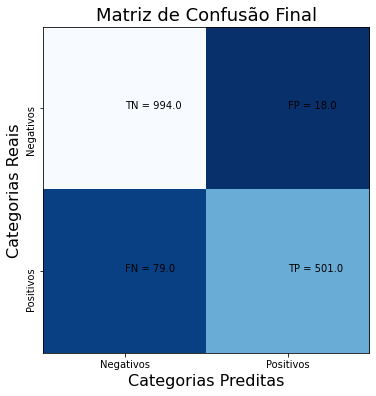

In [ ]:
data = [[TN, FP],[FN,TP]]

plt.clf()
plt.imshow(data, cmap = plt.cm.Blues_r)
classNames = ['Negativos','Positivos']
plt.title('Matriz de Confusão Final', fontsize=18)
plt.ylabel('Categorias Reais', fontsize=16)
plt.xlabel('Categorias Preditas', fontsize=16)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames, rotation=90)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(data[i][j]))
plt.show()


## Classificador x2

In [ ]:
classificadorx2 = Sequential()
classificadorx2.add(Conv2D(128,
                         kernel_size = (3,3),
                         padding = 'same',
                         input_shape = (128,128,3),
                         activation = 'relu'))
classificadorx2.add(BatchNormalization())
classificadorx2.add(MaxPooling2D(pool_size = (2,2)))
classificadorx2.add(Conv2D(32,
                         (3,3),
                         activation = 'relu'))
classificadorx2.add(Conv2D(32,
                         (3,3),
                         activation = 'relu'))
classificadorx2.add(Conv2D(32,
                         (3,3),
                         activation = 'relu'))
classificadorx2.add(BatchNormalization())
classificadorx2.add(MaxPooling2D(pool_size = (2,2)))
classificadorx2.add(Flatten())
classificadorx2.add(Dense(units = 128,
                         activation = 'relu',
                         use_bias=True,
                         kernel_initializer='glorot_uniform',
                         bias_initializer='zeros'))
classificadorx2.add(Dropout(0.2))
classificadorx2.add(Dense(units = 128,
                         activation = 'relu',
                         use_bias=True,
                         kernel_initializer='glorot_uniform',
                         bias_initializer='zeros'))
classificadorx2.add(Dropout(0.2))
classificadorx2.add(Dense(units = 128,
                        activation = 'relu'))
classificadorx2.add(Dropout(0.2))
classificadorx2.add(Dense(units = 1,
                        activation = 'sigmoid'))
optimizer = RMSprop(lr=0.001,
                    rho=0.9,
                    epsilon=1e-08,
                    decay=0.0)
classificadorx2.compile(optimizer = optimizer,
                      loss = 'binary_crossentropy',
                      metrics = METRICS)

epochs = 100

learning_rate = ReduceLROnPlateau(monitor='accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

h_x2 = classificadorx2.fit(base_treino,
                        steps_per_epoch = 100,
                        epochs = epochs,
                        validation_data = base_teste,
                        callbacks = [learning_rate],
                        verbose = 1,
                        validation_steps = 25)

classificadorx2.save_weights('/content/drive/MyDrive/classificador_x2_weights.h5')
classificadorx2.save('/content/drive/MyDrive/classificador_x2_model.h5')


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


100/100 [==============================] - 19s 162ms/step - loss: 1.2052 - tp: 601.0000 - fp: 202.0000 - tn: 974.0000 - fn: 215.0000 - accuracy: 0.7907 - precision: 0.7484 - recall: 0.7365 - auc: 0.8510 - val_loss: 0.9513 - val_tp: 0.0000e+00 - val_fp: 23.0000 - val_tn: 178.0000 - val_fn: 199.0000 - val_accuracy: 0.4450 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6505 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 15s 147ms/step - loss: 0.7206 - tp: 466.0000 - fp: 154.0000 - tn: 819.0000 - fn: 161.0000 - accuracy: 0.8031 - precision: 0.7516 - recall: 0.7432 - auc: 0.8717 - val_loss: 0.6291 - val_tp: 204.0000 - val_fp: 122.0000 - val_tn: 71.0000 - val_fn: 3.0000 - val_accuracy: 0.6875 - val_precision: 0.6258 - val_recall: 0.9855 - val_auc: 0.9024 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 15s 147ms/step - loss: 0.4173 - tp: 517.0000 - fp: 104.0000 - tn: 873.0000 - fn: 106.0000 - accuracy: 0.8687 - precision: 0.8325 - re

In [ ]:
classificadorx2.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 128)     3584      
                                                                 
 batch_normalization_3 (Batc  (None, 128, 128, 128)    512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 62, 62, 32)        36896     
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 conv2d_7 (Conv2D)           (None, 58, 58, 32)       

In [ ]:
keras2ascii(classificadorx2)


           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####    128  128    3
              Conv2D    \|/  -------------------      3584     0.1%
                relu   #####    128  128  128
  BatchNormalization    μ|σ  -------------------       512     0.0%
                       #####    128  128  128
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     64   64  128
              Conv2D    \|/  -------------------     36896     1.0%
                relu   #####     62   62   32
              Conv2D    \|/  -------------------      9248     0.3%
                relu   #####     60   60   32
              Conv2D    \|/  -------------------      9248     0.3%
                relu   #####     58   58   32
  BatchNormalization    μ|σ  -------------------       128     0.0%
                       #####     58   58   32
        MaxPooling2D   Y max -------------------         0     0.0%
              

In [ ]:
print('Acuracia do treino: {0:.2f}%'.format(max(h_x2.history['accuracy']) * 100))
print('Acuracia da validacao: {0:.2f}%'.format(max(h_x2.history['val_accuracy']) * 100))


Acuracia do treino: 95.13%
Acuracia da validacao: 100.00%


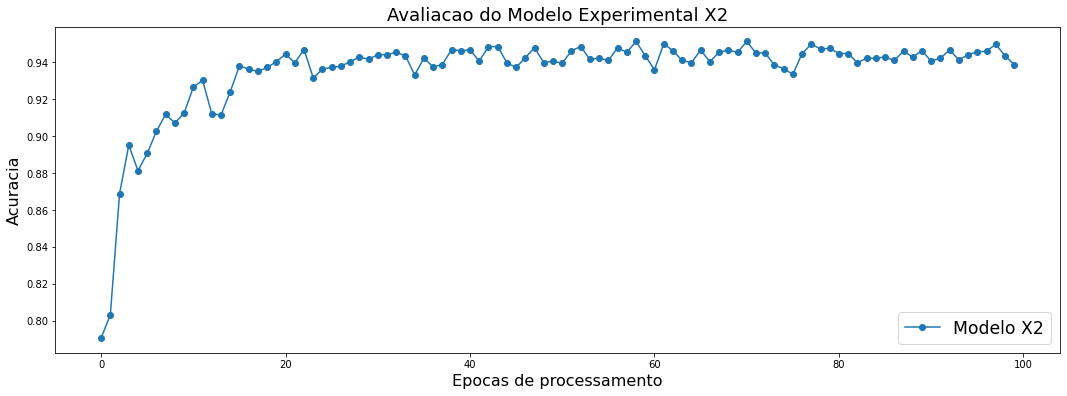

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x2.history['accuracy'], '-o')
plt.legend(['Modelo X2'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Avaliacao do Modelo Experimental X2', fontsize=18)
plt.show()


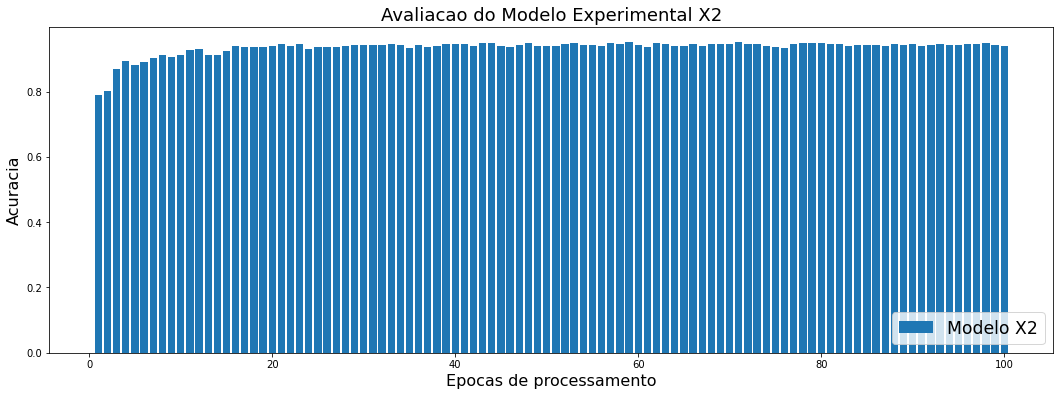

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x2.history['accuracy'])
plt.legend(['Modelo X2'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Avaliacao do Modelo Experimental X2', fontsize=18)
plt.show()


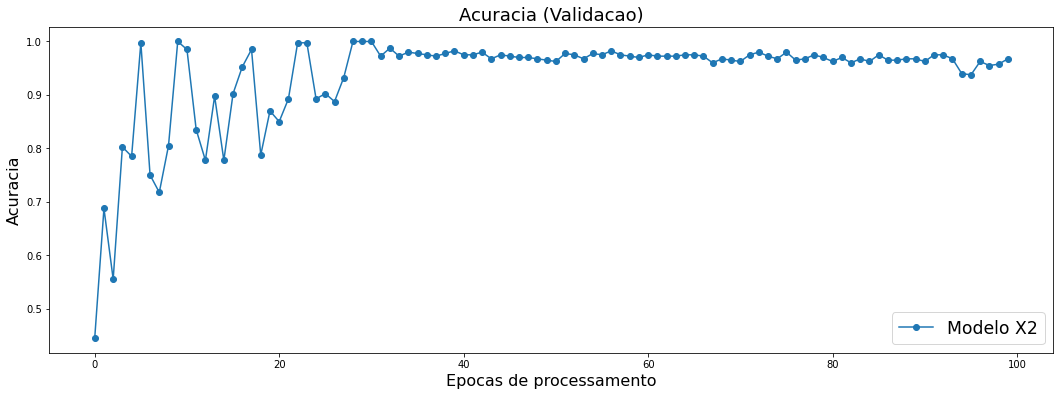

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x2.history['val_accuracy'], '-o')
plt.legend(['Modelo X2'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Acuracia (Validacao)', fontsize=18)
plt.show()


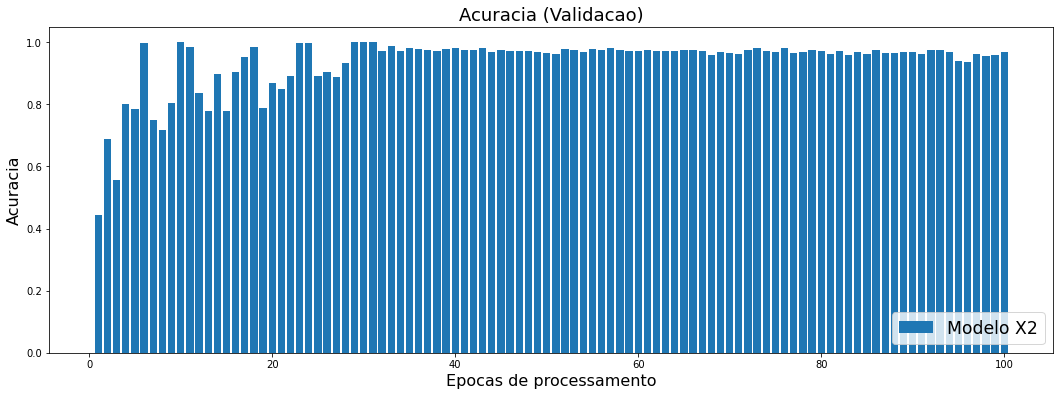

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x2.history['val_accuracy'])
plt.legend(['Modelo X2'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Acuracia (Validacao)', fontsize=18)
plt.show()


<function matplotlib.pyplot.show>

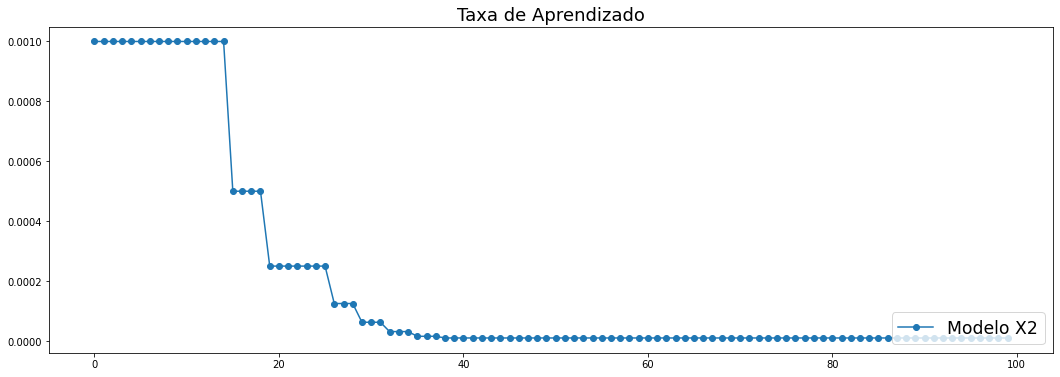

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x2.history['lr'], '-o')
plt.legend(['Modelo X2'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Taxa de Aprendizado', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

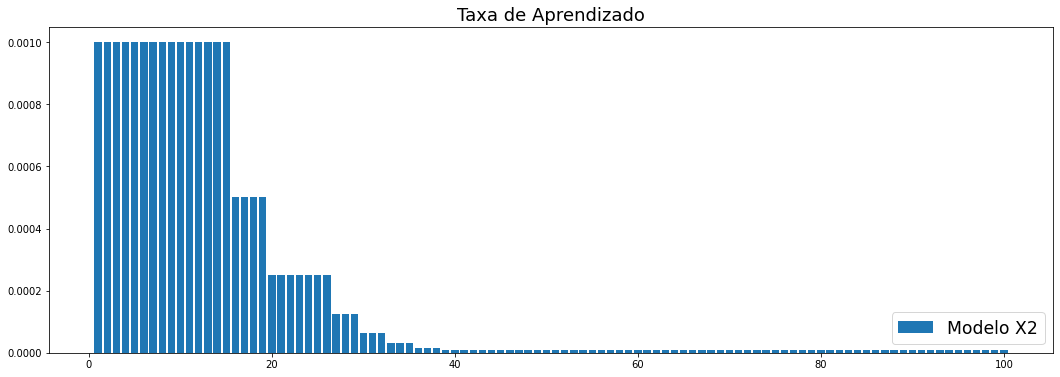

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x2.history['lr'])
plt.legend(['Modelo X2'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Taxa de Aprendizado', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

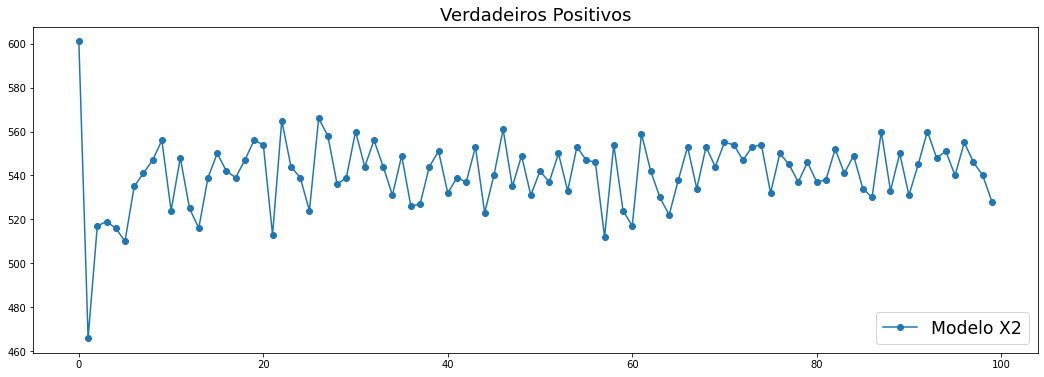

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x2.history['tp'], '-o')
plt.legend(['Modelo X2'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Verdadeiros Positivos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

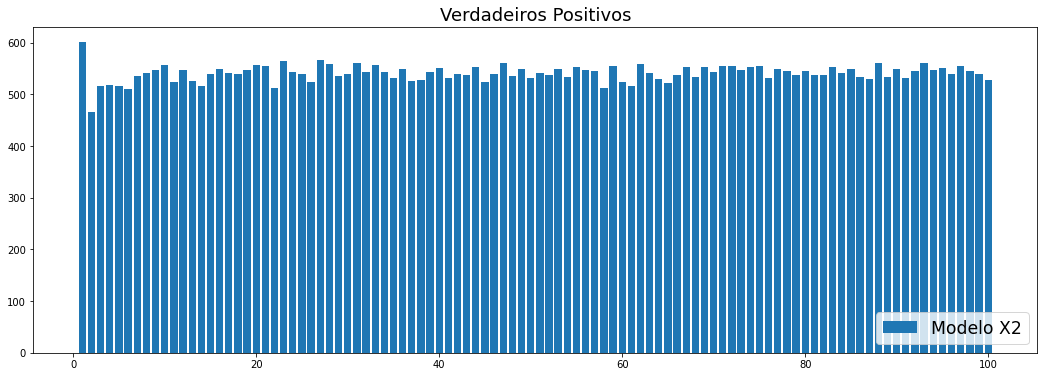

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x2.history['tp'])
plt.legend(['Modelo X2'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Verdadeiros Positivos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

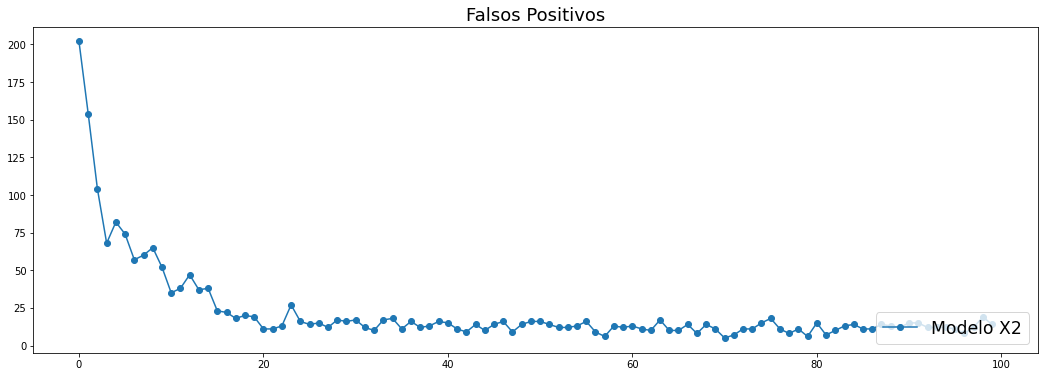

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x2.history['fp'], '-o')
plt.legend(['Modelo X2'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Falsos Positivos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

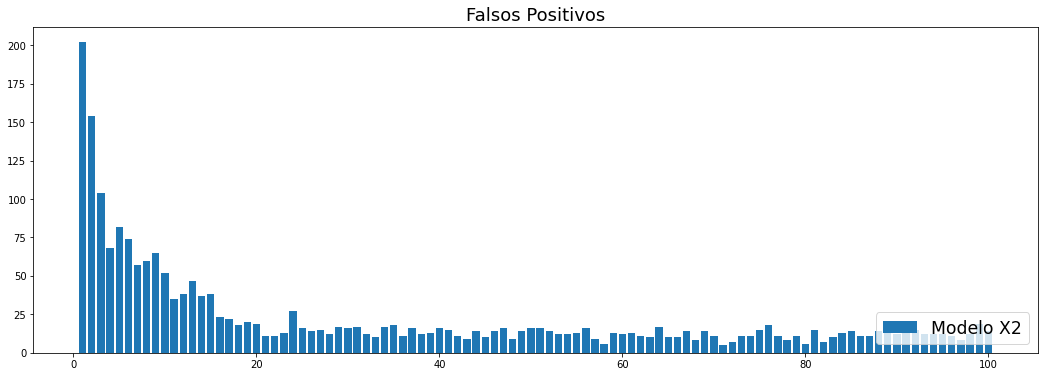

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x2.history['fp'])
plt.legend(['Modelo X2'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Falsos Positivos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

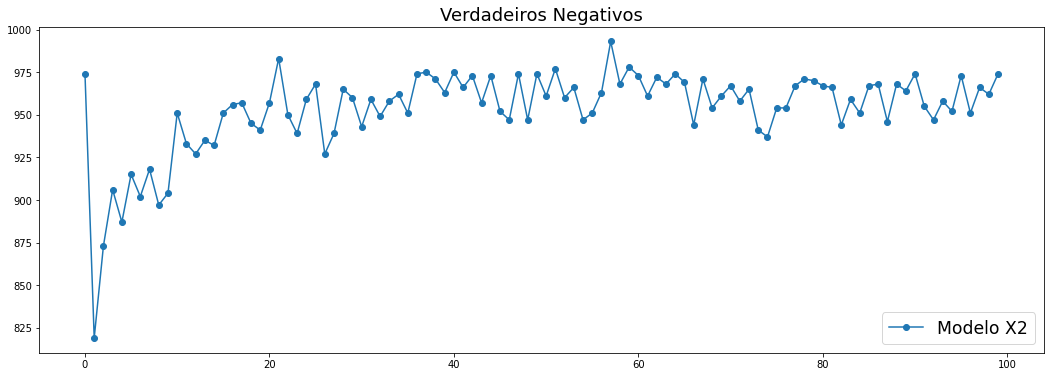

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x2.history['tn'], '-o')
plt.legend(['Modelo X2'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Verdadeiros Negativos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

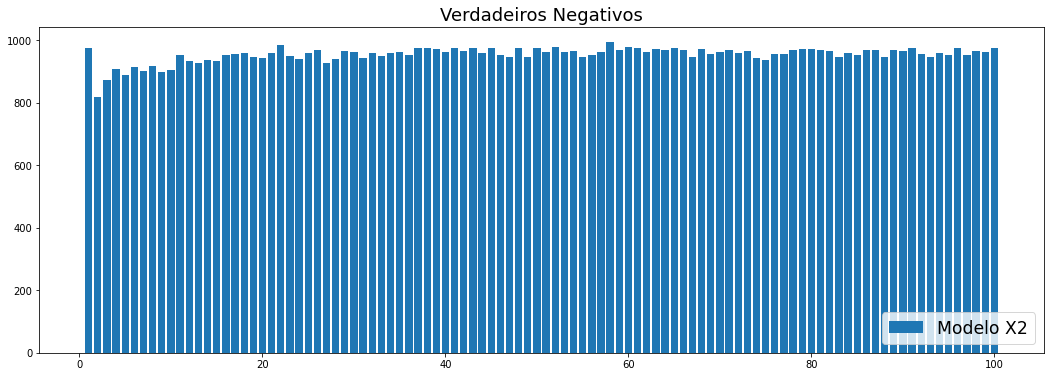

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x2.history['tn'])
plt.legend(['Modelo X2'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Verdadeiros Negativos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

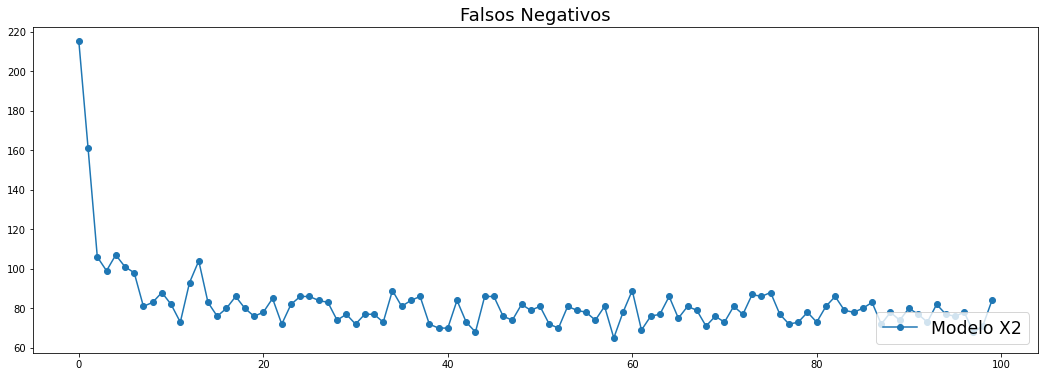

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x2.history['fn'], '-o')
plt.legend(['Modelo X2'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Falsos Negativos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

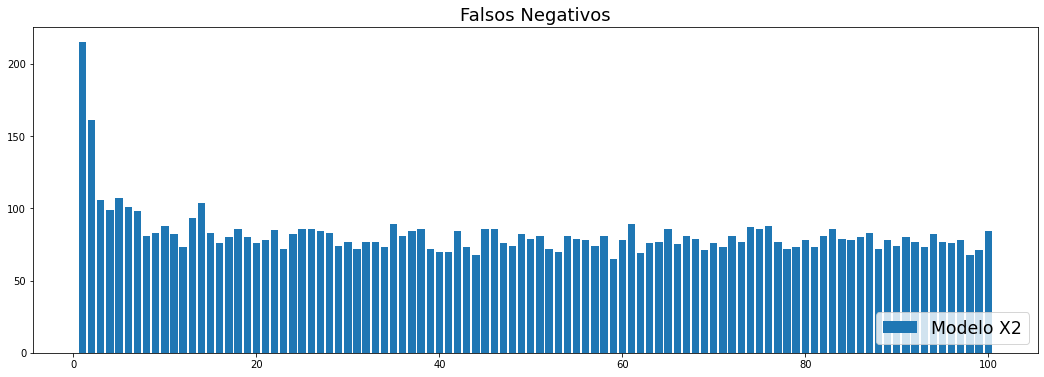

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x2.history['fn'])
plt.legend(['Modelo X2'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Falsos Negativos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

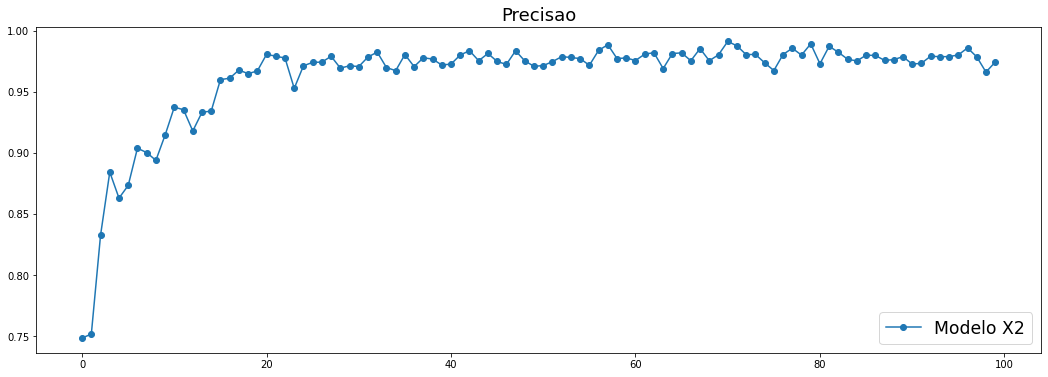

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x2.history['precision'], '-o')
plt.legend(['Modelo X2'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Precisao', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

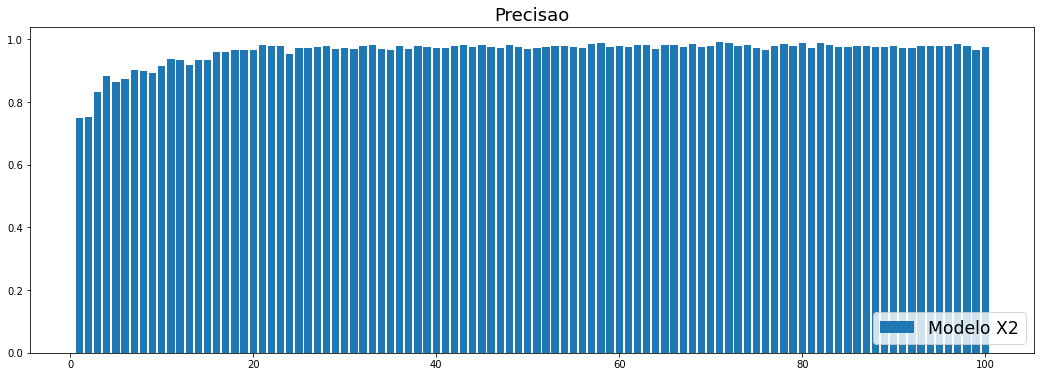

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x2.history['precision'])
plt.legend(['Modelo X2'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Precisao', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

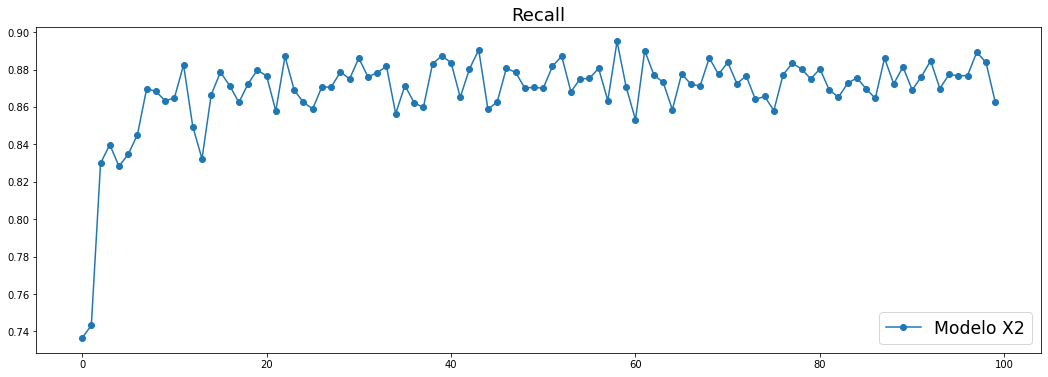

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x2.history['recall'], '-o')
plt.legend(['Modelo X2'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Recall', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

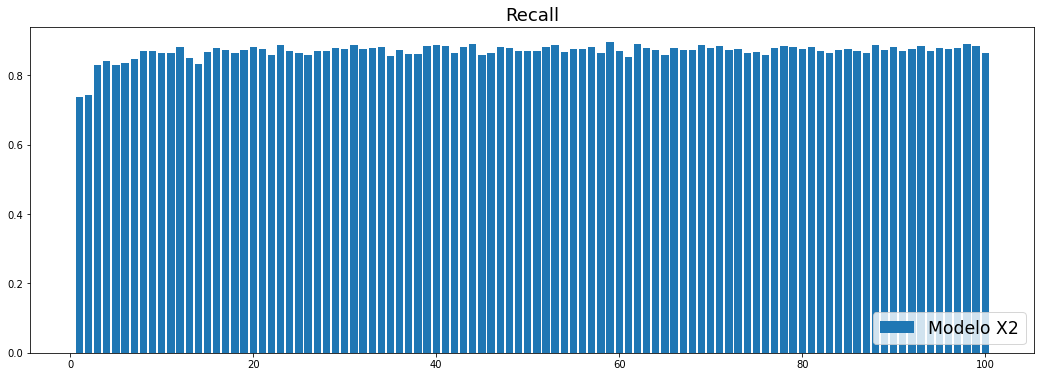

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x2.history['recall'])
plt.legend(['Modelo X2'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Recall', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

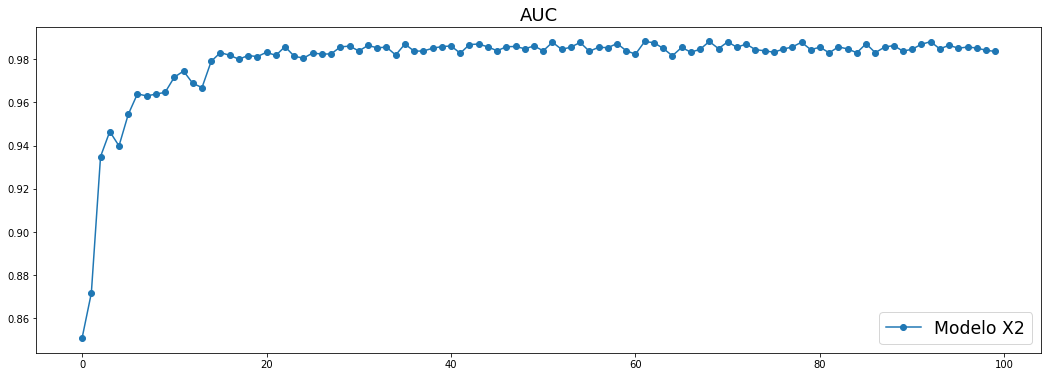

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x2.history['auc'], '-o')
plt.legend(['Modelo X2'], loc = 'lower right', fontsize = 'xx-large')
plt.title('AUC', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

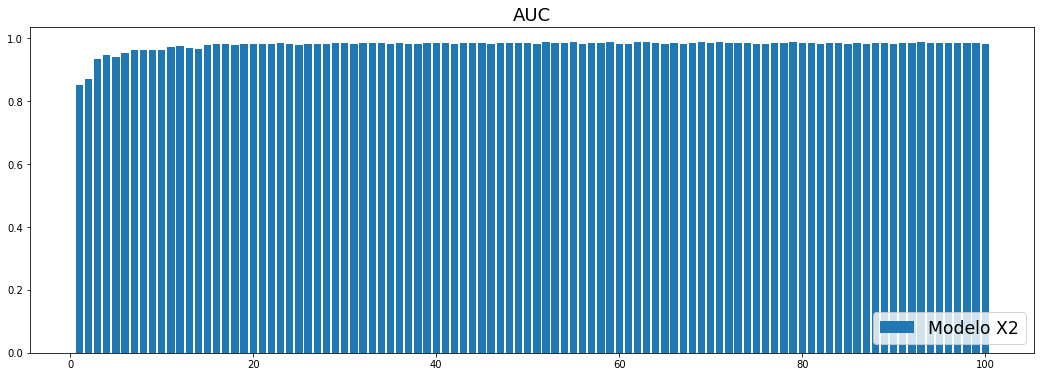

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x2.history['auc'])
plt.legend(['Modelo X2'], loc = 'lower right', fontsize = 'xx-large')
plt.title('AUC', fontsize=18)
plt.show


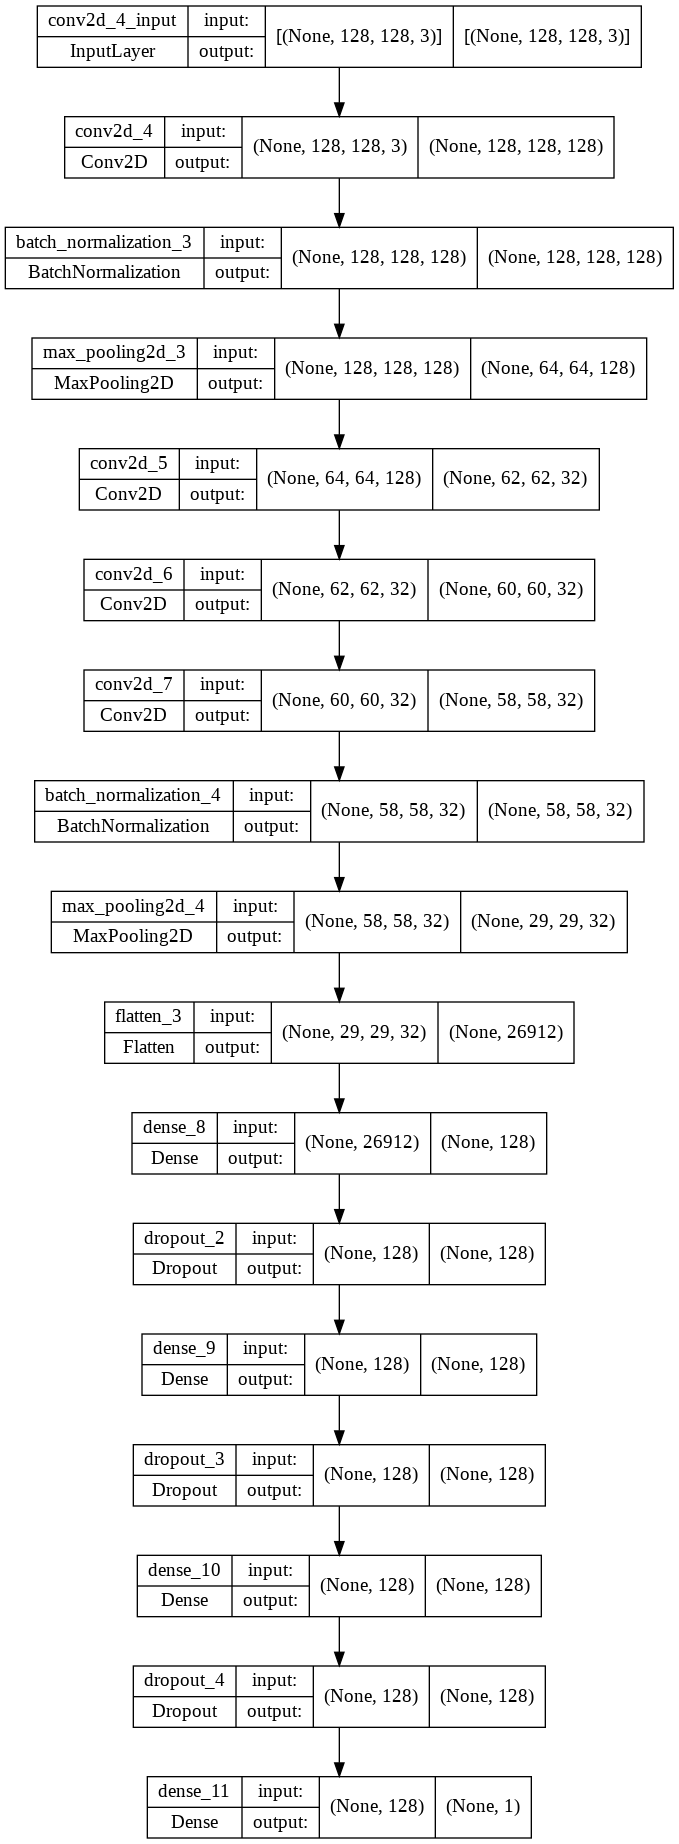

In [ ]:
plot_model(classificadorx2,
           to_file='/content/drive/MyDrive/classificador_x2.png',
           show_shapes=True,
           show_layer_names=True)


In [ ]:
FP = h_x2.history['fp'][-1]
FN = h_x2.history['fn'][-1]
TP = h_x2.history['tp'][-1]
TN = h_x2.history['tn'][-1]
LOSS = h_x2.history['loss'][-1]
ACC = h_x2.history['accuracy'][-1]
PRE = h_x2.history['precision'][-1]
REC = h_x2.history['recall'][-1]
AUC = h_x2.history['auc'][-1]
LR = h_x2.history['lr'][-1]

TPR = TP/(TP+FN) # Sensitivity, hit rate, recall, or true positive rate
TNR = TN/(TN+FP) # Specificity or true negative rate
PPV = TP/(TP+FP) # Precision or positive predictive value
NPV = TN/(TN+FN) # Negative predictive value
FPR = FP/(FP+TN) # Fall out or false positive rate
FNR = FN/(TP+FN) # False negative rate
FDR = FP/(TP+FP) # False discovery rate

OACC = (TP+TN)/(TP+FP+FN+TN) # Overall accuracy / F1-score

print("Confusion Matrix : ")
print(f"[{TP}] [{FP}]")
print(f"[{FN}] [{TN}]")

print(f'Accuracy: {ACC}')
print(f'Loss: {LOSS}')
print(f'Precision: {PRE}')
print(f'Recall: {REC}')
print(f'F1 Score: {OACC}%')
print(f'AUC: {AUC}')
print(f'Learning Rate: {LR}')
print(f'Sensitivity, hit rate, recall, or true positive rate: {TPR}%')
print(f'Specificity or true negative rate: {TNR}%')
print(f'Precision or positive predictive value: {PPV}%')
print(f'Negative predictive value: {NPV}%')
print(f'Fall out or false positive rate: {FPR}%')
print(f'False negative rate: {FNR}%')
print(f'False discovery rate: {FDR}%')


Confusion Matrix : 
[528.0] [14.0]
[84.0] [974.0]
Accuracy: 0.9387500286102295
Loss: 0.14667853713035583
Precision: 0.9741697311401367
Recall: 0.8627451062202454
F1 Score: 0.93875%
AUC: 0.9835196137428284
Learning Rate: 9.999999747378752e-06
Sensitivity, hit rate, recall, or true positive rate: 0.8627450980392157%
Specificity or true negative rate: 0.9858299595141701%
Precision or positive predictive value: 0.974169741697417%
Negative predictive value: 0.9206049149338374%
Fall out or false positive rate: 0.01417004048582996%
False negative rate: 0.13725490196078433%
False discovery rate: 0.025830258302583026%


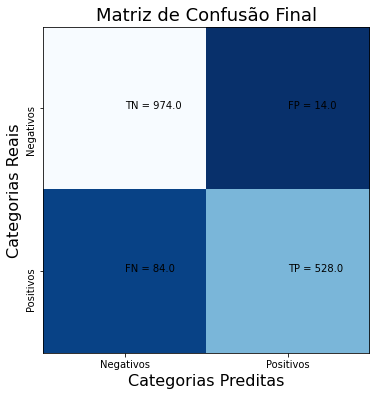

In [ ]:
data = [[TN, FP],[FN,TP]]

plt.clf()
plt.imshow(data, cmap = plt.cm.Blues_r)
classNames = ['Negativos','Positivos']
plt.title('Matriz de Confusão Final', fontsize=18)
plt.ylabel('Categorias Reais', fontsize=16)
plt.xlabel('Categorias Preditas', fontsize=16)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames, rotation=90)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(data[i][j]))
plt.show()


## Classificador x3

In [ ]:
gerador_treino = ImageDataGenerator(rescale = 1.0/255,
                                    rotation_range = 5,
                                    horizontal_flip = True,
                                    shear_range = 0.2,
                                    height_shift_range = 0.07,
                                    zoom_range = 0.2)
gerador_teste = ImageDataGenerator(rescale = 1.0/255)

base_treino = gerador_treino.flow_from_directory('/content/drive/MyDrive/Documentação - CNN Coluna/dataset/train/',
                                                 target_size = (128,128),
                                                 batch_size = 16,
                                                 class_mode = 'binary')
base_teste = gerador_teste.flow_from_directory('/content/drive/MyDrive/Documentação - CNN Coluna/dataset/test/',
                                               target_size = (128,128),
                                               batch_size = 16,
                                               class_mode = 'binary')

classificadorx3 = Sequential()
classificadorx3.add(Conv2D(128,
                         kernel_size = (3,3),
                         padding = 'same',
                         input_shape = (128,128,3),
                         activation = 'relu'))
classificadorx3.add(BatchNormalization())
classificadorx3.add(MaxPooling2D(pool_size = (2,2)))
classificadorx3.add(Conv2D(128,
                         (3,3),
                         activation = 'relu'))
classificadorx3.add(Conv2D(128,
                         (3,3),
                         activation = 'relu'))
classificadorx3.add(Conv2DTranspose(128,
                                   kernel_size = (3,3),
                                   strides = (1, 1),
                                   padding = 'valid',
                                   output_padding = None,
                                   data_format = None,
                                   dilation_rate = (1, 1),
                                   activation = None,
                                   use_bias = True,
                                   kernel_initializer = 'glorot_uniform'))
classificadorx3.add(Conv2D(128,
                         (3,3),
                         activation = 'relu'))
classificadorx3.add(Conv2DTranspose(128,
                                   kernel_size = (3,3),
                                   strides = (1, 1),
                                   padding = 'valid',
                                   output_padding = None,
                                   data_format = None,
                                   dilation_rate = (1, 1),
                                   activation = None,
                                   use_bias = True,
                                   kernel_initializer = 'glorot_uniform'))
classificadorx3.add(Conv2D(128,
                         (3,3),
                         activation = 'relu'))
classificadorx3.add(BatchNormalization())
classificadorx3.add(MaxPooling2D(pool_size = (2,2)))
classificadorx3.add(Flatten())
classificadorx3.add(Dense(units = 128,
                         activation = 'relu',
                         use_bias=True,
                         kernel_initializer='glorot_uniform',
                         bias_initializer='zeros'))
classificadorx3.add(Dropout(0.1))
classificadorx3.add(Dense(units = 256,
                         activation = 'relu',
                         use_bias=True,
                         kernel_initializer='glorot_uniform',
                         bias_initializer='zeros'))
classificadorx3.add(Dropout(0.1))
classificadorx3.add(Dense(units = 256,
                         activation = 'relu',
                         use_bias=True,
                         kernel_initializer='glorot_uniform',
                         bias_initializer='zeros'))
classificadorx3.add(Dropout(0.1))
classificadorx3.add(Dense(units = 128,
                         activation = 'relu',
                         use_bias=True,
                         kernel_initializer='glorot_uniform',
                         bias_initializer='zeros'))
classificadorx3.add(Dropout(0.1))
classificadorx3.add(Dense(units = 1,
                        activation = 'sigmoid'))
optimizer = Adam(learning_rate=0.001,
                 beta_1=0.9,
                 beta_2=0.999,
                 epsilon=1e-07,
                 amsgrad=False,
                 name="Adam")
classificadorx3.compile(optimizer = optimizer,
                      loss = 'binary_crossentropy',
                      metrics = METRICS)

epochs = 100

learning_rate = ReduceLROnPlateau(monitor='accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

h_x3 = classificadorx3.fit(base_treino,
                        steps_per_epoch = 100,
                        epochs = epochs,
                        validation_data = base_teste,
                        callbacks = [learning_rate],
                        verbose = 1,
                        validation_steps = 25)

classificadorx3.save_weights('/content/drive/MyDrive/classificador_x3_weights.h5')
classificadorx3.save('/content/drive/MyDrive/classificador_x3_model.h5')


Found 2392 images belonging to 2 classes.
Found 505 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 19s 163ms/step - loss: 1.6834 - tp: 574.0000 - fp: 244.0000 - tn: 917.0000 - fn: 257.0000 - accuracy: 0.7485 - precision: 0.7017 - recall: 0.6907 - auc: 0.8016 - val_loss: 1.0661 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 194.0000 - val_fn: 206.0000 - val_accuracy: 0.4850 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8429 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 15s 152ms/step - loss: 0.7422 - tp: 406.0000 - fp: 173.0000 - tn: 790.0000 - fn: 223.0000 - accuracy: 0.7513 - precision: 0.7012 - recall: 0.6455 - auc: 0.7965 - val_loss: 1.6615 - val_tp: 209.0000 - val_fp: 153.0000 - val_tn: 38.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.6175 - val_precision: 0.5773 - val_recall: 1.0000 - val_auc: 0.7640 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 15s 149ms/step - loss: 0.4725 -

In [ ]:
classificadorx3.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 128)     3584      
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 128)    512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 62, 62, 128)       147584    
                                                                 
 conv2d_10 (Conv2D)          (None, 60, 60, 128)       147584    
                                                                 
 conv2d_transpose (Conv2DTra  (None, 62, 62, 128)     

In [ ]:
keras2ascii(classificadorx3)


           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####    128  128    3
              Conv2D    \|/  -------------------      3584     0.0%
                relu   #####    128  128  128
  BatchNormalization    μ|σ  -------------------       512     0.0%
                       #####    128  128  128
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     64   64  128
              Conv2D    \|/  -------------------    147584     0.9%
                relu   #####     62   62  128
              Conv2D    \|/  -------------------    147584     0.9%
                relu   #####     60   60  128
     Conv2DTranspose    /|\  -------------------    147584     0.9%
                       #####     62   62  128
              Conv2D    \|/  -------------------    147584     0.9%
                relu   #####     60   60  128
     Conv2DTranspose    /|\  -------------------    147584     0.9%
              

In [ ]:
print('Acuracia do treino: {0:.2f}%'.format(max(h_x3.history['accuracy']) * 100))
print('Acuracia da validacao: {0:.2f}%'.format(max(h_x3.history['val_accuracy']) * 100))


Acuracia do treino: 96.13%
Acuracia da validacao: 100.00%


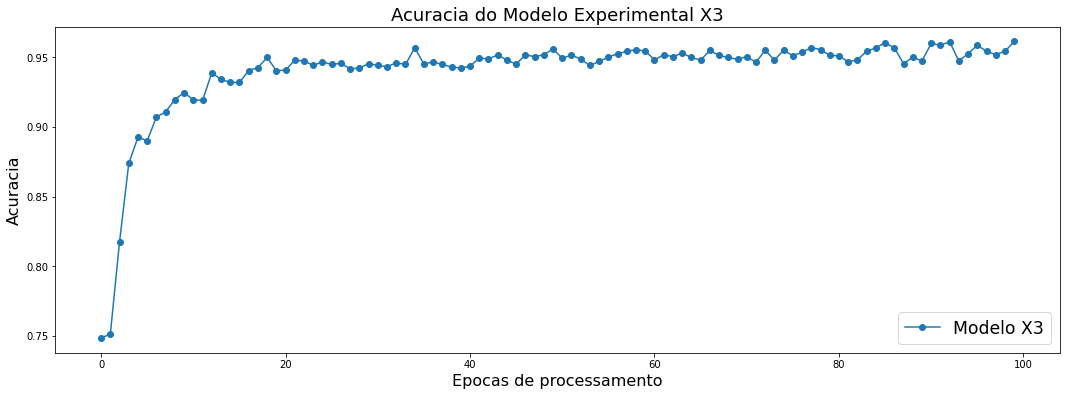

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x3.history['accuracy'], '-o')
plt.legend(['Modelo X3'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Acuracia do Modelo Experimental X3', fontsize=18)
plt.show()


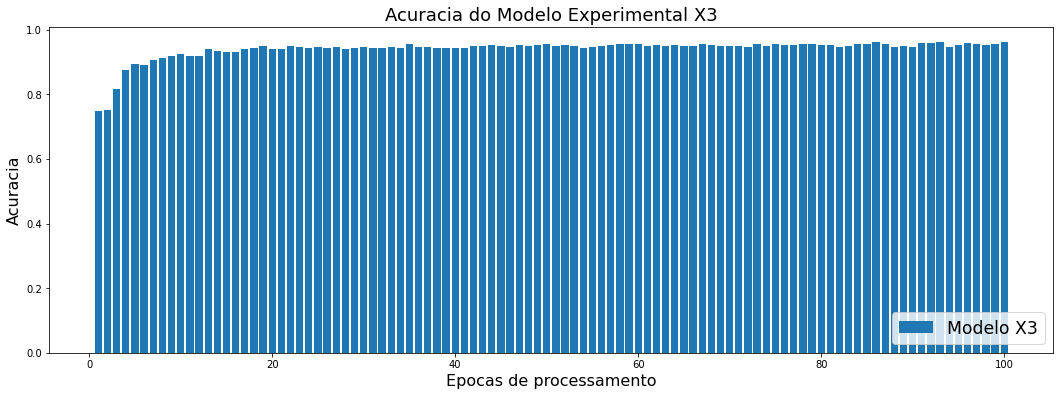

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x3.history['accuracy'])
plt.legend(['Modelo X3'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Acuracia do Modelo Experimental X3', fontsize=18)
plt.show()


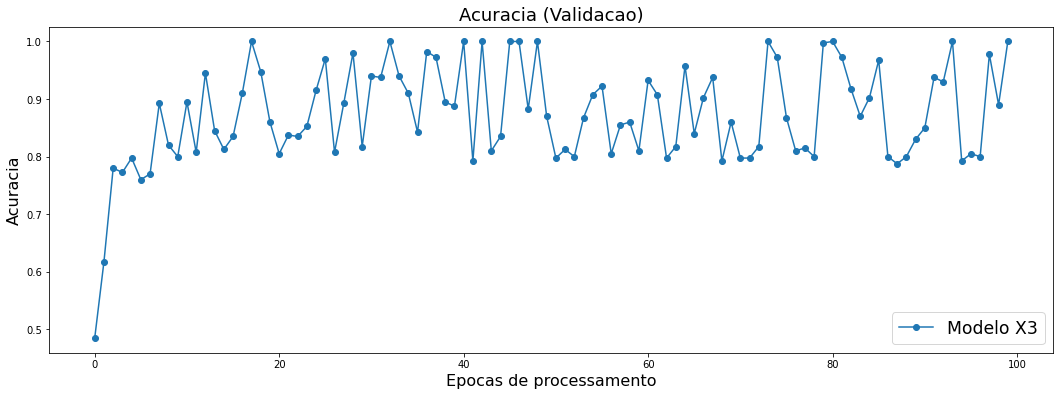

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x3.history['val_accuracy'], '-o')
plt.legend(['Modelo X3'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Acuracia (Validacao)', fontsize=18)
plt.show()


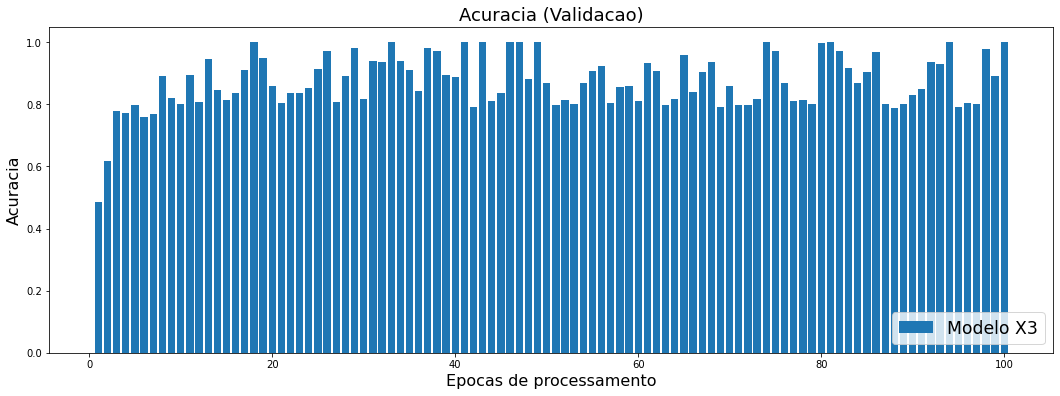

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x3.history['val_accuracy'])
plt.legend(['Modelo X3'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Acuracia (Validacao)', fontsize=18)
plt.show()


<function matplotlib.pyplot.show>

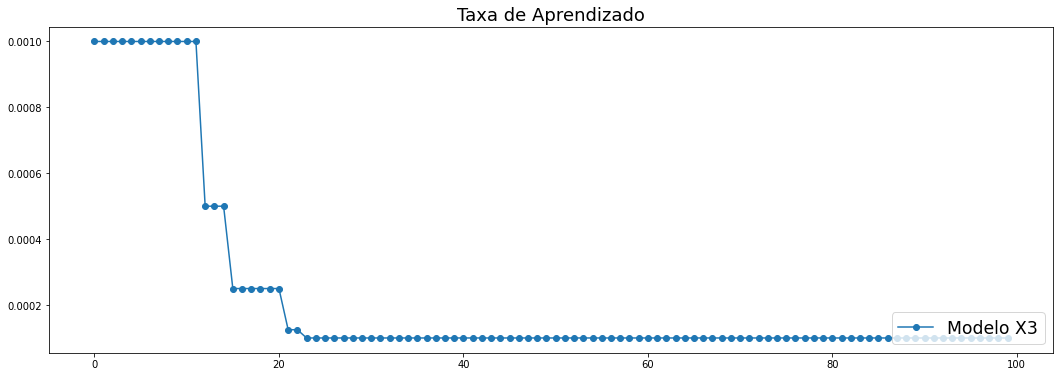

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x3.history['lr'], '-o')
plt.legend(['Modelo X3'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Taxa de Aprendizado', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

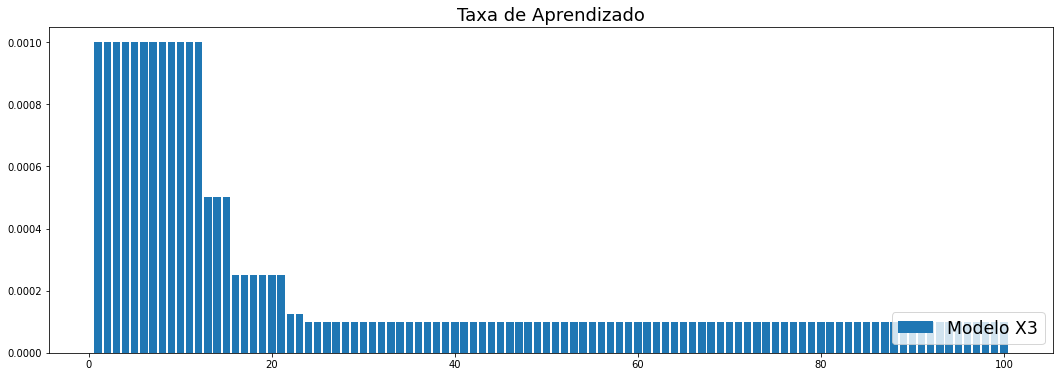

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x3.history['lr'])
plt.legend(['Modelo X3'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Taxa de Aprendizado', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

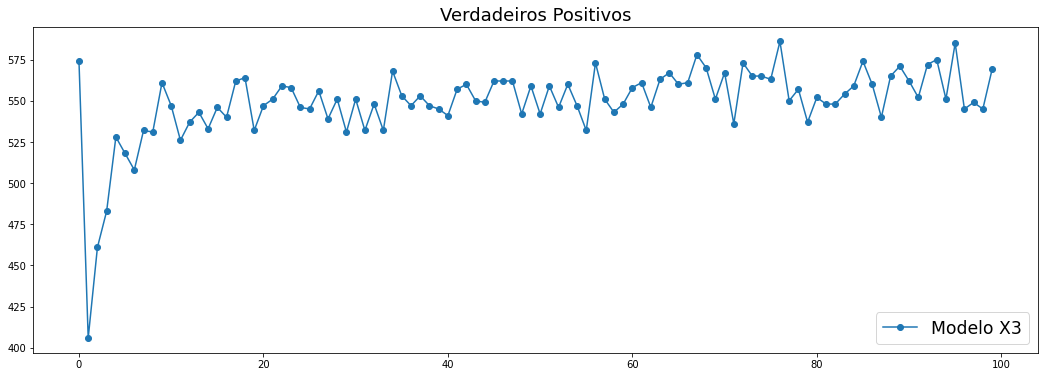

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x3.history['tp'], '-o')
plt.legend(['Modelo X3'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Verdadeiros Positivos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

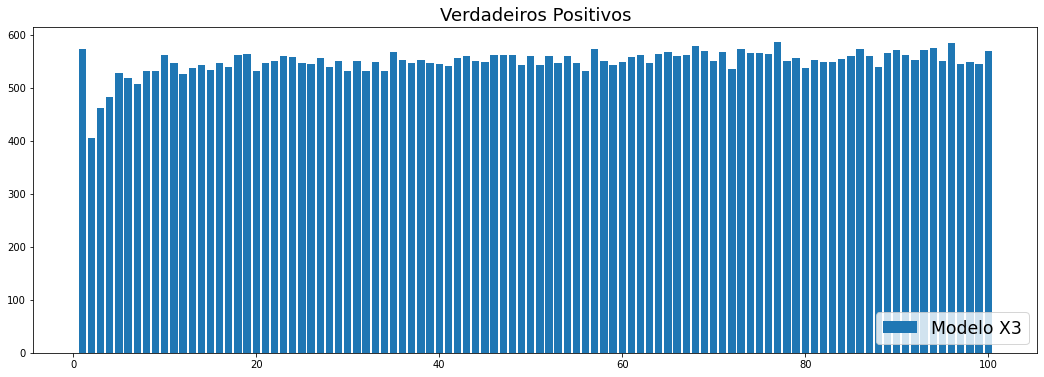

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x3.history['tp'])
plt.legend(['Modelo X3'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Verdadeiros Positivos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

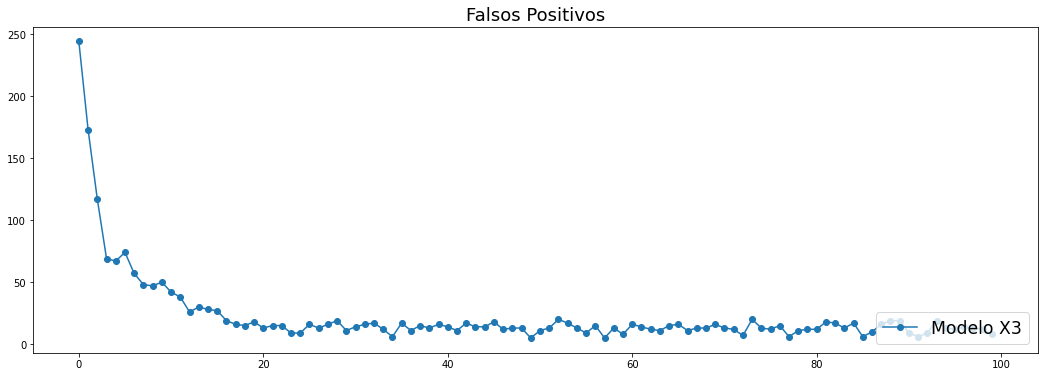

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x3.history['fp'], '-o')
plt.legend(['Modelo X3'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Falsos Positivos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

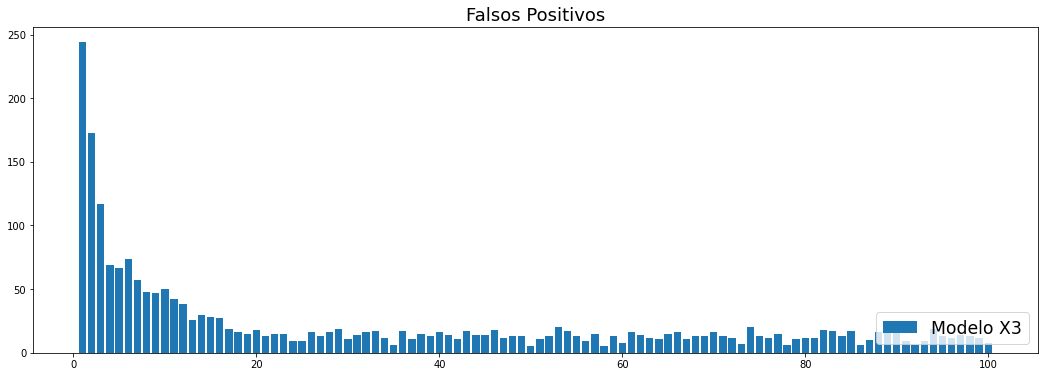

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x3.history['fp'])
plt.legend(['Modelo X3'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Falsos Positivos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

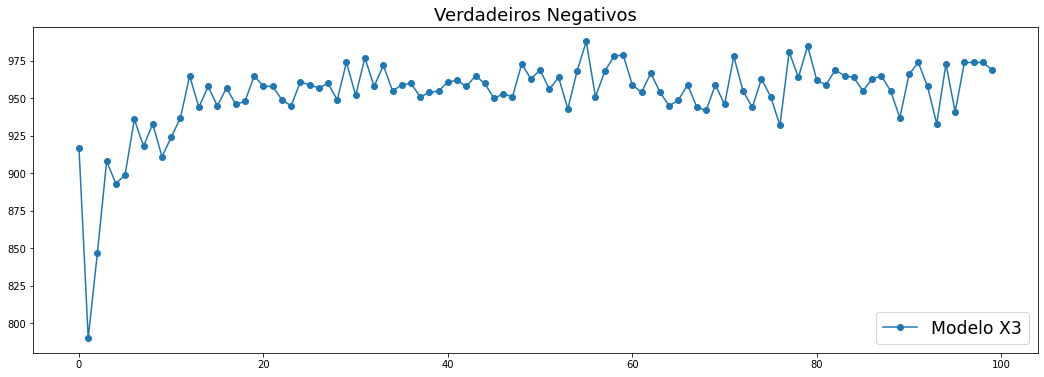

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x3.history['tn'], '-o')
plt.legend(['Modelo X3'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Verdadeiros Negativos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

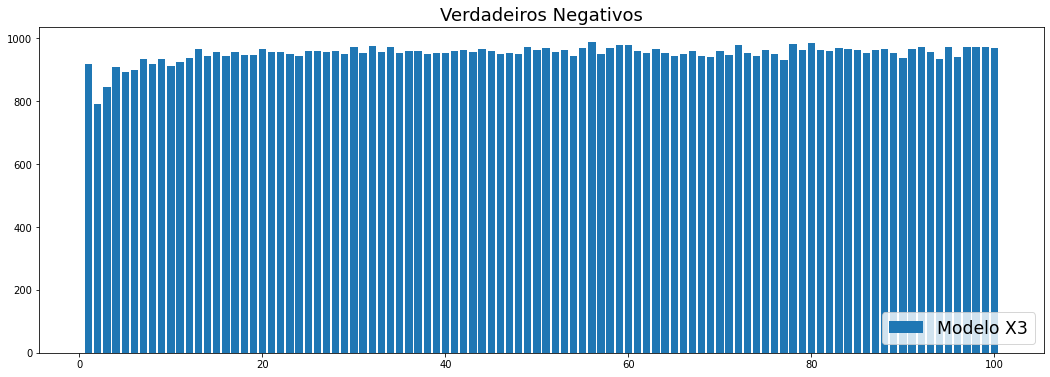

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x3.history['tn'])
plt.legend(['Modelo X3'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Verdadeiros Negativos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

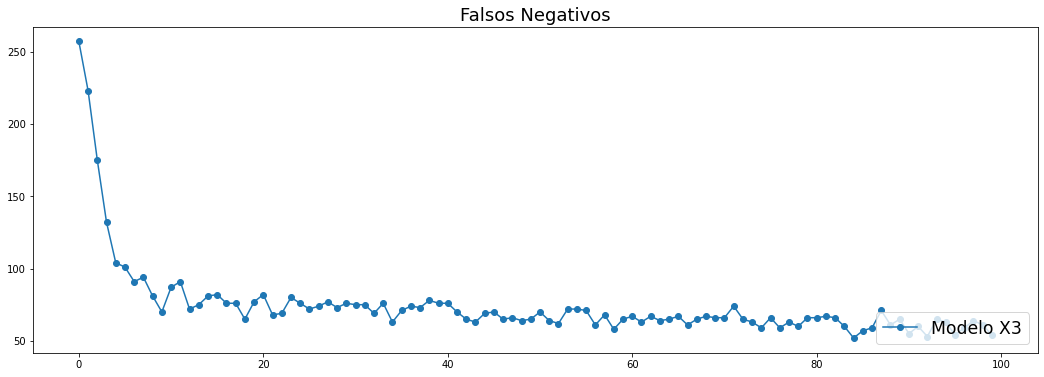

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x3.history['fn'], '-o')
plt.legend(['Modelo X3'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Falsos Negativos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

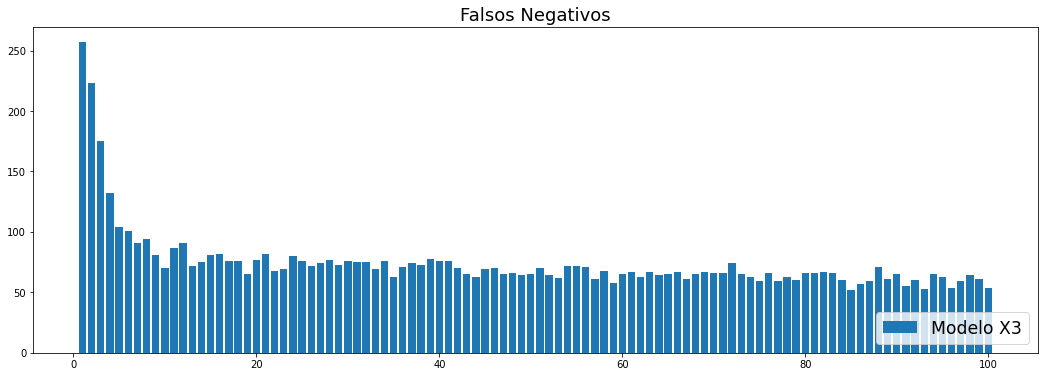

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x3.history['fn'])
plt.legend(['Modelo X3'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Falsos Negativos', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

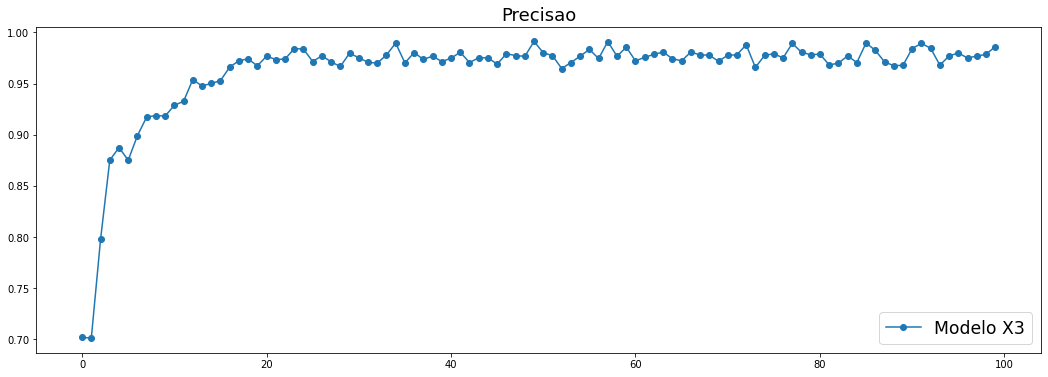

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x3.history['precision'], '-o')
plt.legend(['Modelo X3'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Precisao', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

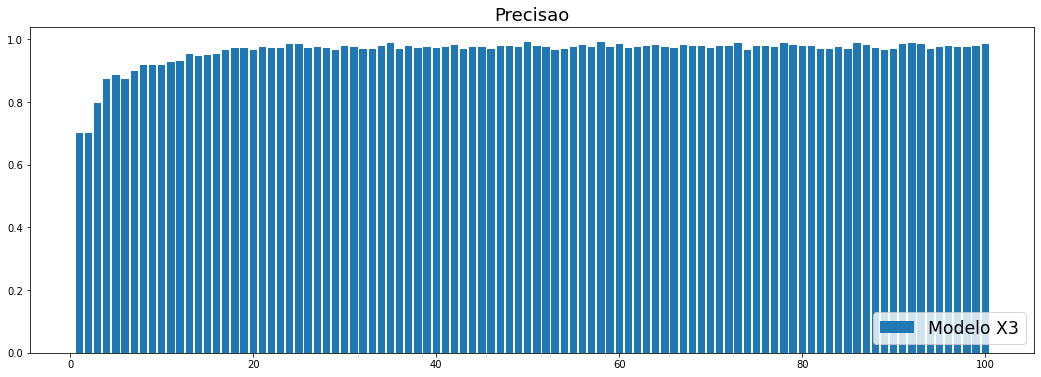

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x3.history['precision'])
plt.legend(['Modelo X3'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Precisao', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

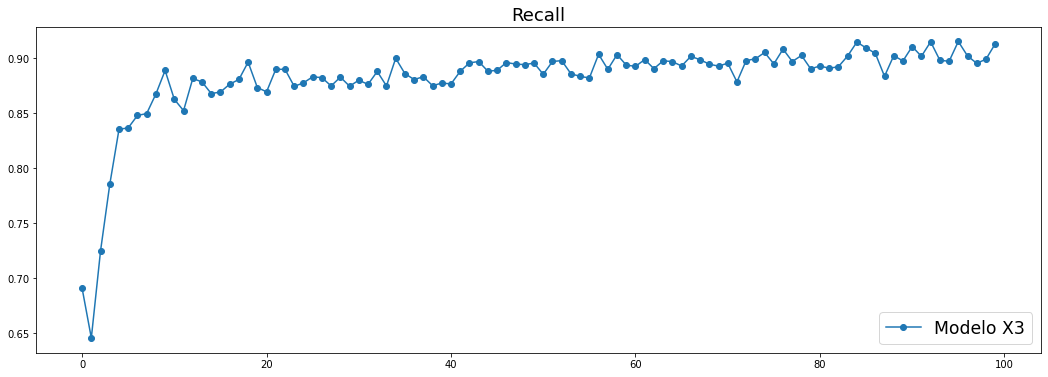

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x3.history['recall'], '-o')
plt.legend(['Modelo X3'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Recall', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

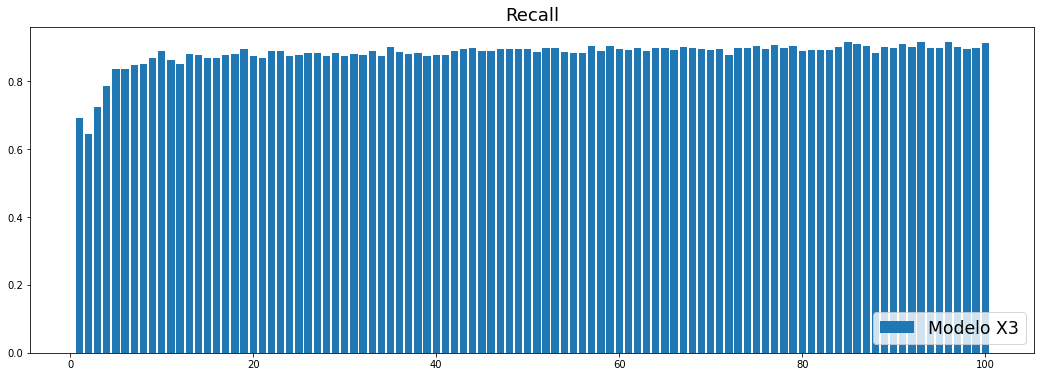

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x3.history['recall'])
plt.legend(['Modelo X3'], loc = 'lower right', fontsize = 'xx-large')
plt.title('Recall', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

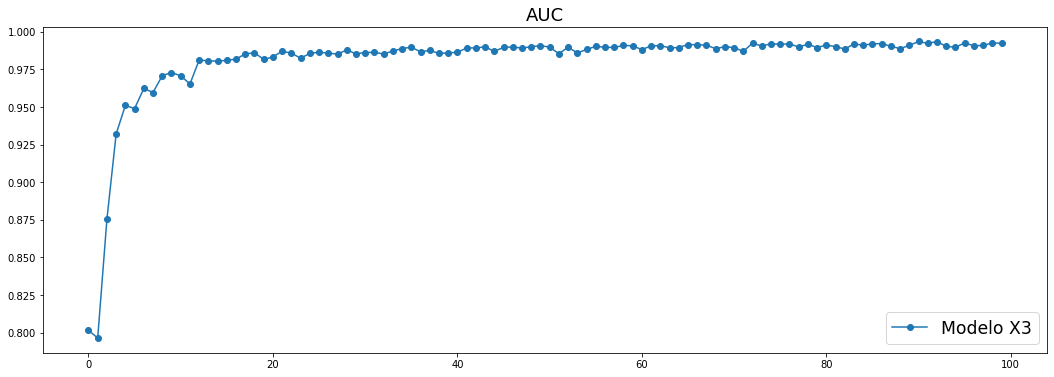

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_x3.history['auc'], '-o')
plt.legend(['Modelo X3'], loc = 'lower right', fontsize = 'xx-large')
plt.title('AUC', fontsize=18)
plt.show


<function matplotlib.pyplot.show>

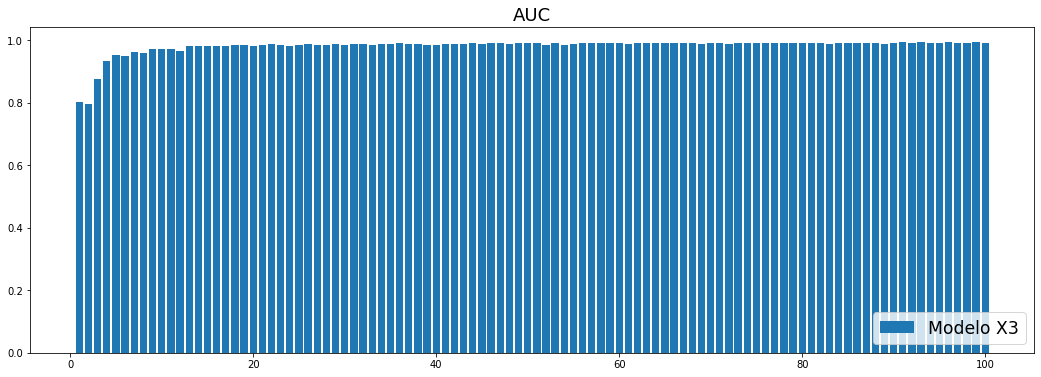

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.bar(N_epocas,h_x3.history['auc'])
plt.legend(['Modelo X3'], loc = 'lower right', fontsize = 'xx-large')
plt.title('AUC', fontsize=18)
plt.show


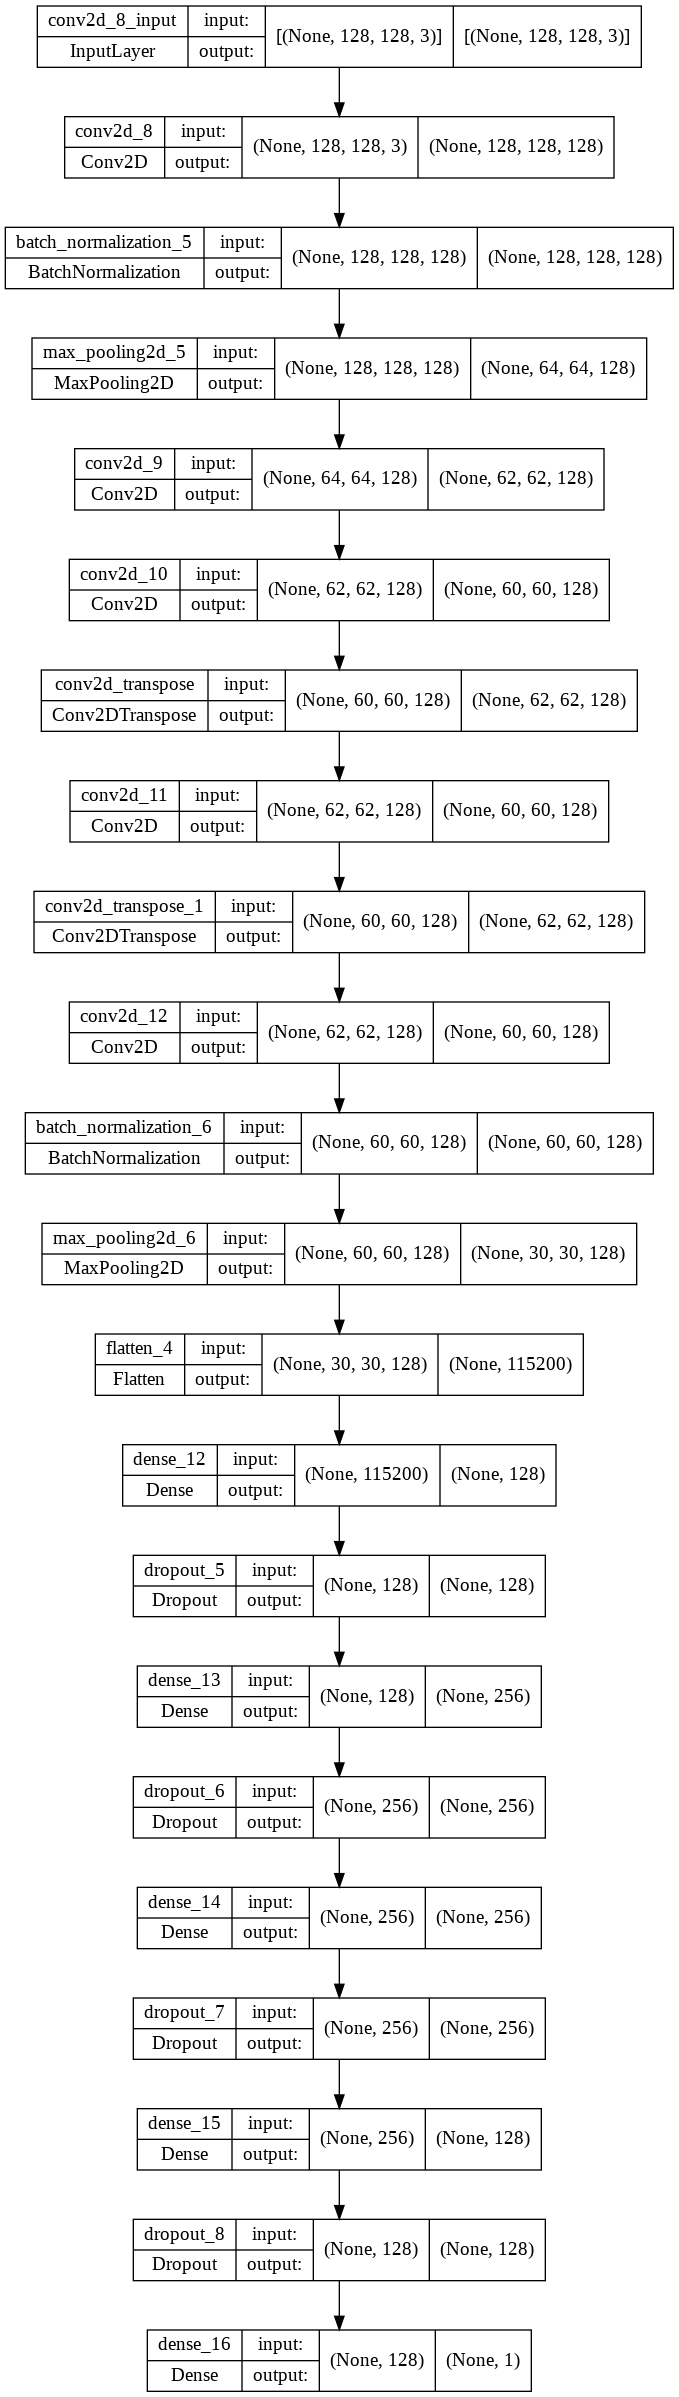

In [ ]:
plot_model(classificadorx3,
           to_file='/content/drive/MyDrive/classificador_x3.png',
           show_shapes=True,
           show_layer_names=True)


In [ ]:
FP = h_x3.history['fp'][-1]
FN = h_x3.history['fn'][-1]
TP = h_x3.history['tp'][-1]
TN = h_x3.history['tn'][-1]
LOSS = h_x3.history['loss'][-1]
ACC = h_x3.history['accuracy'][-1]
PRE = h_x3.history['precision'][-1]
REC = h_x3.history['recall'][-1]
AUC = h_x3.history['auc'][-1]
LR = h_x3.history['lr'][-1]

TPR = TP/(TP+FN) # Sensitivity, hit rate, recall, or true positive rate
TNR = TN/(TN+FP) # Specificity or true negative rate
PPV = TP/(TP+FP) # Precision or positive predictive value
NPV = TN/(TN+FN) # Negative predictive value
FPR = FP/(FP+TN) # Fall out or false positive rate
FNR = FN/(TP+FN) # False negative rate
FDR = FP/(TP+FP) # False discovery rate

OACC = (TP+TN)/(TP+FP+FN+TN) # Overall accuracy / F1-score

print("Confusion Matrix : ")
print(f"[{TP}] [{FP}]")
print(f"[{FN}] [{TN}]")

print(f'Accuracy: {ACC}')
print(f'Loss: {LOSS}')
print(f'Precision: {PRE}')
print(f'Recall: {REC}')
print(f'F1 Score: {OACC}%')
print(f'AUC: {AUC}')
print(f'Learning Rate: {LR}')
print(f'Sensitivity, hit rate, recall, or true positive rate: {TPR}%')
print(f'Specificity or true negative rate: {TNR}%')
print(f'Precision or positive predictive value: {PPV}%')
print(f'Negative predictive value: {NPV}%')
print(f'Fall out or false positive rate: {FPR}%')
print(f'False negative rate: {FNR}%')
print(f'False discovery rate: {FDR}%')


Confusion Matrix : 
[569.0] [8.0]
[54.0] [969.0]
Accuracy: 0.9612500071525574
Loss: 0.09633422642946243
Precision: 0.9861351847648621
Recall: 0.9133226275444031
F1 Score: 0.96125%
AUC: 0.9923061728477478
Learning Rate: 9.999999747378752e-05
Sensitivity, hit rate, recall, or true positive rate: 0.913322632423756%
Specificity or true negative rate: 0.9918116683725691%
Precision or positive predictive value: 0.9861351819757366%
Negative predictive value: 0.9472140762463344%
Fall out or false positive rate: 0.008188331627430911%
False negative rate: 0.08667736757624397%
False discovery rate: 0.01386481802426343%


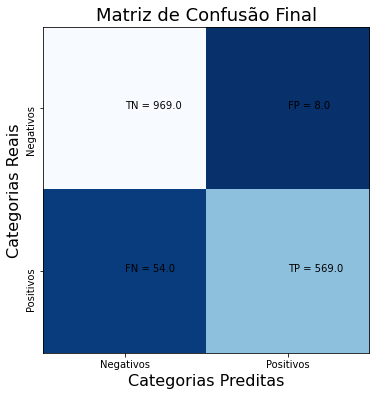

In [ ]:
data = [[TN, FP],[FN,TP]]

plt.clf()
plt.imshow(data, cmap = plt.cm.Blues_r)
classNames = ['Negativos','Positivos']
plt.title('Matriz de Confusão Final', fontsize=18)
plt.ylabel('Categorias Reais', fontsize=16)
plt.xlabel('Categorias Preditas', fontsize=16)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames, rotation=90)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(data[i][j]))
plt.show()


## Comparativo entre todos os modelos

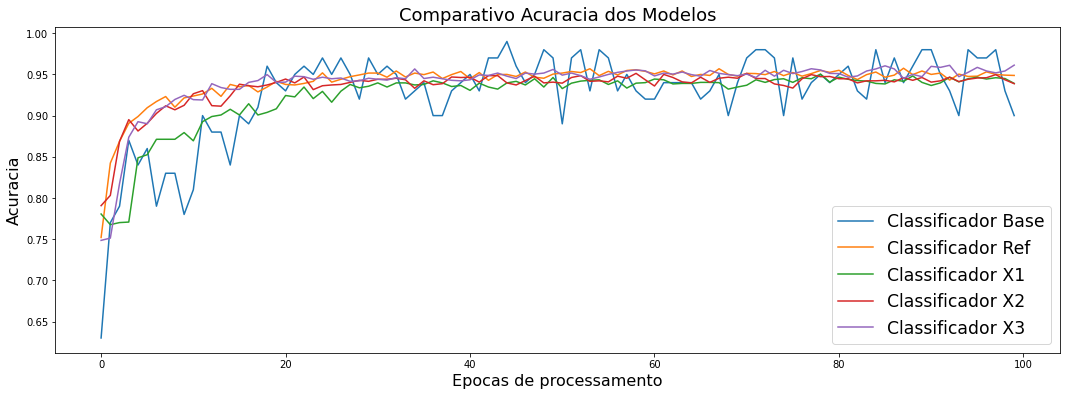

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_0.history['accuracy'])
plt.plot(h_1.history['accuracy'])
plt.plot(h_x1.history['accuracy'])
plt.plot(h_x2.history['accuracy'])
plt.plot(h_x3.history['accuracy'])
plt.legend(['Classificador Base',
            'Classificador Ref',
            'Classificador X1',
            'Classificador X2',
            'Classificador X3'],
           loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Comparativo Acuracia dos Modelos', fontsize=18)
plt.show()


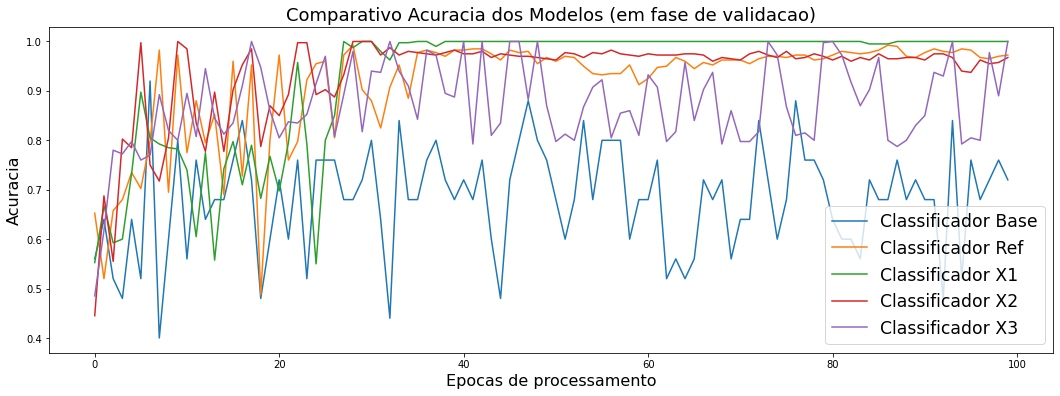

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_0.history['val_accuracy'])
plt.plot(h_1.history['val_accuracy'])
plt.plot(h_x1.history['val_accuracy'])
plt.plot(h_x2.history['val_accuracy'])
plt.plot(h_x3.history['val_accuracy'])
plt.legend(['Classificador Base', 'Classificador Ref', 'Classificador X1', 'Classificador X2', 'Classificador X3'],
           loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Comparativo Acuracia dos Modelos (em fase de validacao)', fontsize=18)
plt.show()


<function matplotlib.pyplot.show>

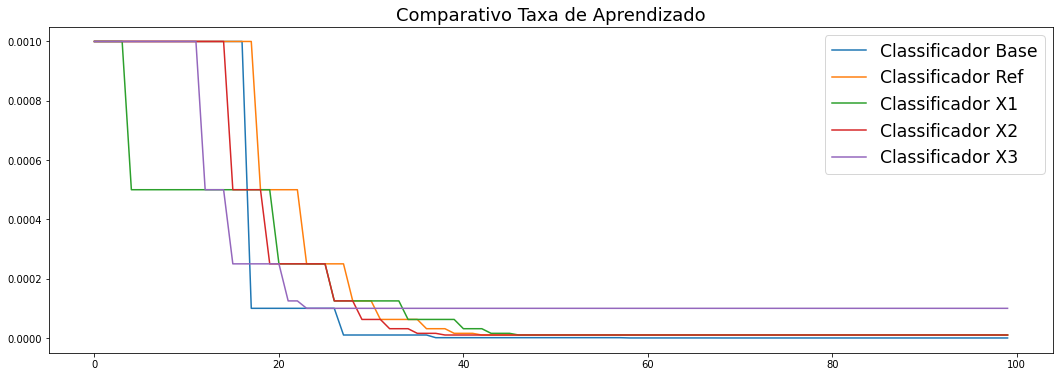

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_0.history['lr'])
plt.plot(h_1.history['lr'])
plt.plot(h_x1.history['lr'])
plt.plot(h_x2.history['lr'])
plt.plot(h_x3.history['lr'])
plt.legend(['Classificador Base', 'Classificador Ref', 'Classificador X1', 'Classificador X2', 'Classificador X3'],
           loc = 'upper right', fontsize = 'xx-large')
plt.title('Comparativo Taxa de Aprendizado', fontsize=18)
plt.show


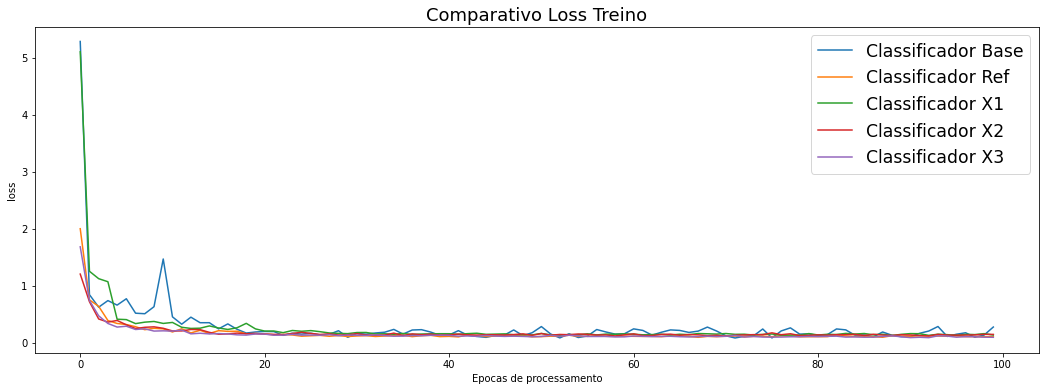

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_0.history['loss'])
plt.plot(h_1.history['loss'])
plt.plot(h_x1.history['loss'])
plt.plot(h_x2.history['loss'])
plt.plot(h_x3.history['loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('Epocas de processamento')
plt.legend(['Classificador Base', 'Classificador Ref', 'Classificador X1', 'Classificador X2', 'Classificador X3'],
           loc='upper right', fontsize = 'xx-large')
plt.title('Comparativo Loss Treino', fontsize=18)
plt.show()


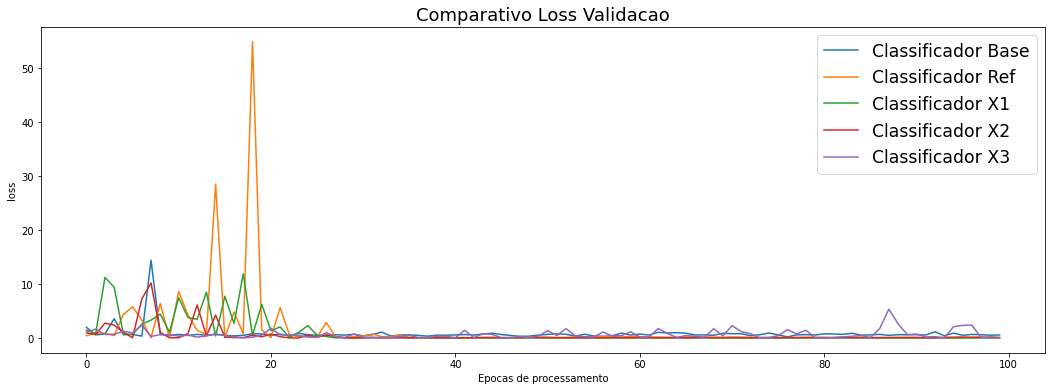

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_0.history['val_loss'])
plt.plot(h_1.history['val_loss'])
plt.plot(h_x1.history['val_loss'])
plt.plot(h_x2.history['val_loss'])
plt.plot(h_x3.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('Epocas de processamento')
plt.legend(['Classificador Base', 'Classificador Ref', 'Classificador X1', 'Classificador X2', 'Classificador X3'],
           loc='upper right', fontsize = 'xx-large')
plt.title('Comparativo Loss Validacao', fontsize=18)
plt.show()


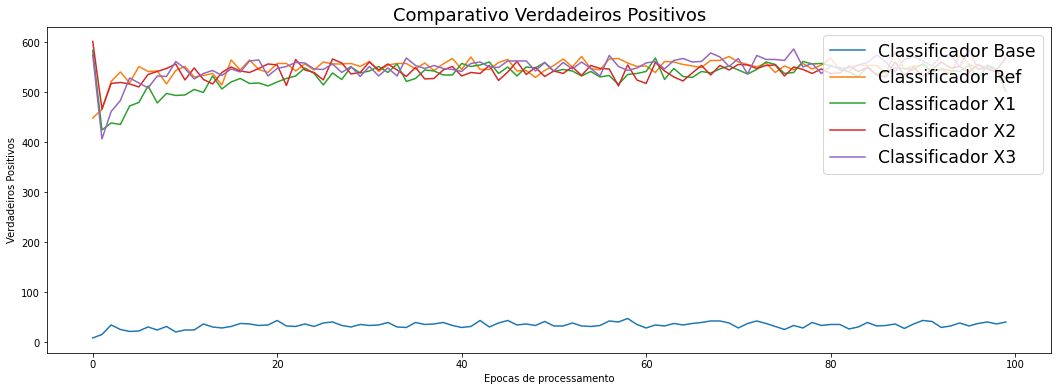

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_0.history['tp'])
plt.plot(h_1.history['tp'])
plt.plot(h_x1.history['tp'])
plt.plot(h_x2.history['tp'])
plt.plot(h_x3.history['tp'])
plt.title('Verdadeiros Positivos')
plt.ylabel('Verdadeiros Positivos')
plt.xlabel('Epocas de processamento')
plt.legend(['Classificador Base', 'Classificador Ref', 'Classificador X1', 'Classificador X2', 'Classificador X3'],
           loc='upper right', fontsize = 'xx-large')
plt.title('Comparativo Verdadeiros Positivos', fontsize=18)
plt.show()


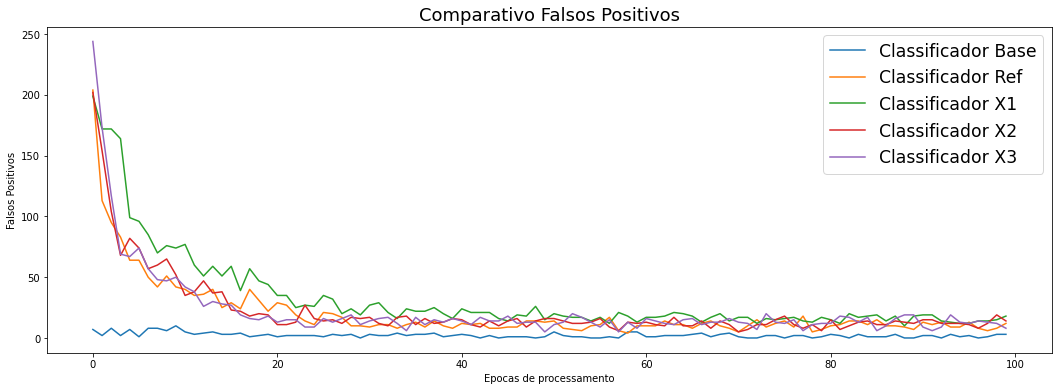

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_0.history['fp'])
plt.plot(h_1.history['fp'])
plt.plot(h_x1.history['fp'])
plt.plot(h_x2.history['fp'])
plt.plot(h_x3.history['fp'])
plt.title('Falsos Positivos')
plt.ylabel('Falsos Positivos')
plt.xlabel('Epocas de processamento')
plt.legend(['Classificador Base', 'Classificador Ref', 'Classificador X1', 'Classificador X2', 'Classificador X3'],
           loc='upper right', fontsize = 'xx-large')
plt.title('Comparativo Falsos Positivos', fontsize=18)
plt.show()


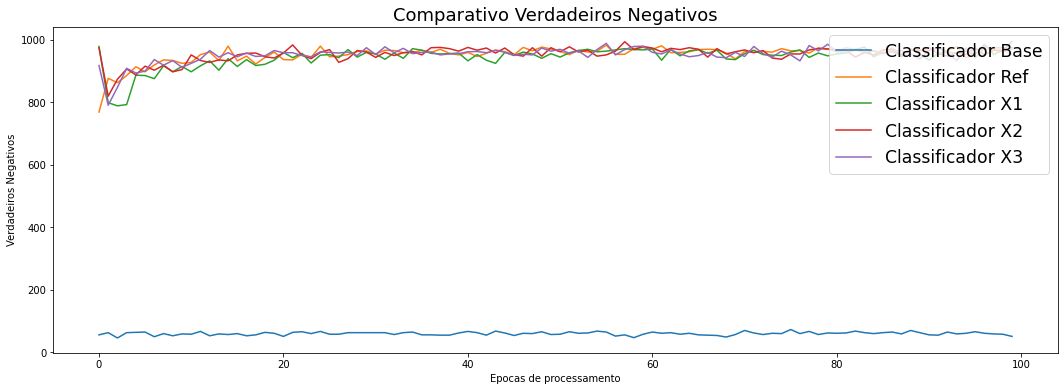

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_0.history['tn'])
plt.plot(h_1.history['tn'])
plt.plot(h_x1.history['tn'])
plt.plot(h_x2.history['tn'])
plt.plot(h_x3.history['tn'])
plt.title('Verdadeiros Negativos')
plt.ylabel('Verdadeiros Negativos')
plt.xlabel('Epocas de processamento')
plt.legend(['Classificador Base', 'Classificador Ref', 'Classificador X1', 'Classificador X2', 'Classificador X3'],
           loc='upper right', fontsize = 'xx-large')
plt.title('Comparativo Verdadeiros Negativos', fontsize=18)
plt.show()


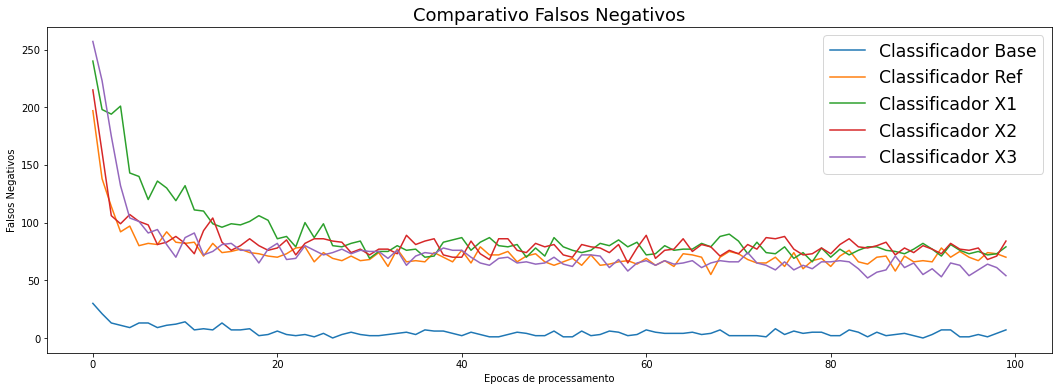

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_0.history['fn'])
plt.plot(h_1.history['fn'])
plt.plot(h_x1.history['fn'])
plt.plot(h_x2.history['fn'])
plt.plot(h_x3.history['fn'])
plt.title('Falsos Negativos')
plt.ylabel('Falsos Negativos')
plt.xlabel('Epocas de processamento')
plt.legend(['Classificador Base', 'Classificador Ref', 'Classificador X1', 'Classificador X2', 'Classificador X3'],
           loc='upper right', fontsize = 'xx-large')
plt.title('Comparativo Falsos Negativos', fontsize=18)
plt.show()


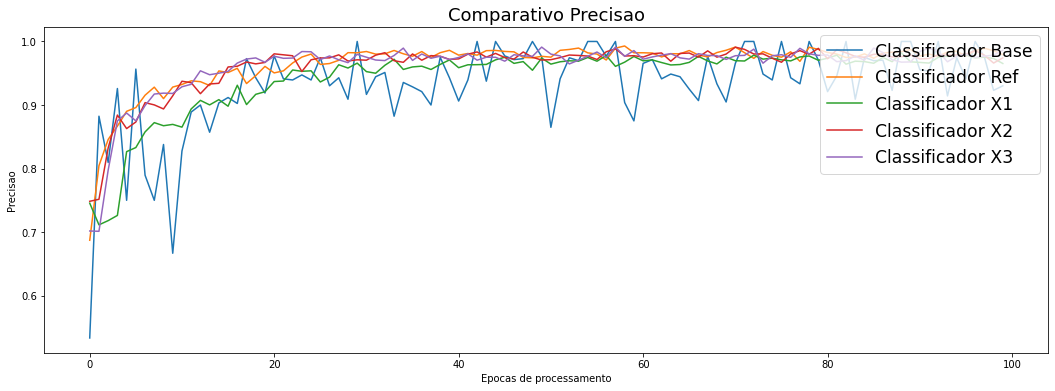

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_0.history['precision'])
plt.plot(h_1.history['precision'])
plt.plot(h_x1.history['precision'])
plt.plot(h_x2.history['precision'])
plt.plot(h_x3.history['precision'])
plt.title('Precisao')
plt.ylabel('Precisao')
plt.xlabel('Epocas de processamento')
plt.legend(['Classificador Base', 'Classificador Ref', 'Classificador X1', 'Classificador X2', 'Classificador X3'],
           loc='upper right', fontsize = 'xx-large')
plt.title('Comparativo Precisao', fontsize=18)
plt.show()


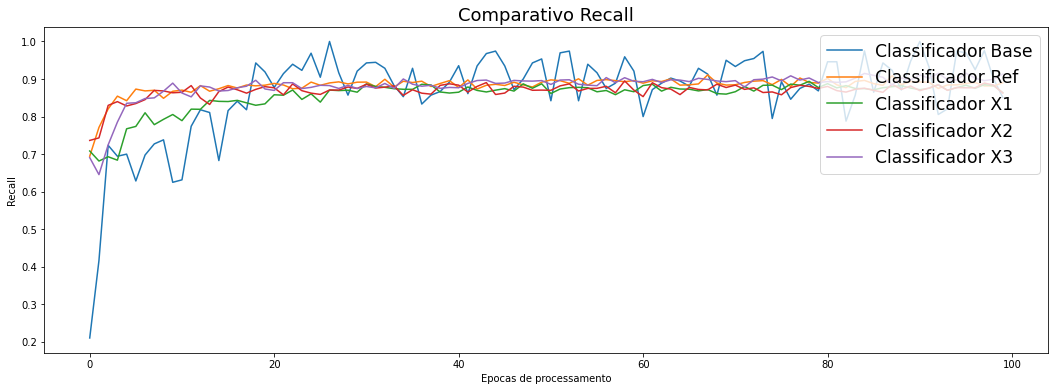

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_0.history['recall'])
plt.plot(h_1.history['recall'])
plt.plot(h_x1.history['recall'])
plt.plot(h_x2.history['recall'])
plt.plot(h_x3.history['recall'])
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('Epocas de processamento')
plt.legend(['Classificador Base', 'Classificador Ref', 'Classificador X1', 'Classificador X2', 'Classificador X3'],
           loc='upper right', fontsize = 'xx-large')
plt.title('Comparativo Recall', fontsize=18)
plt.show()


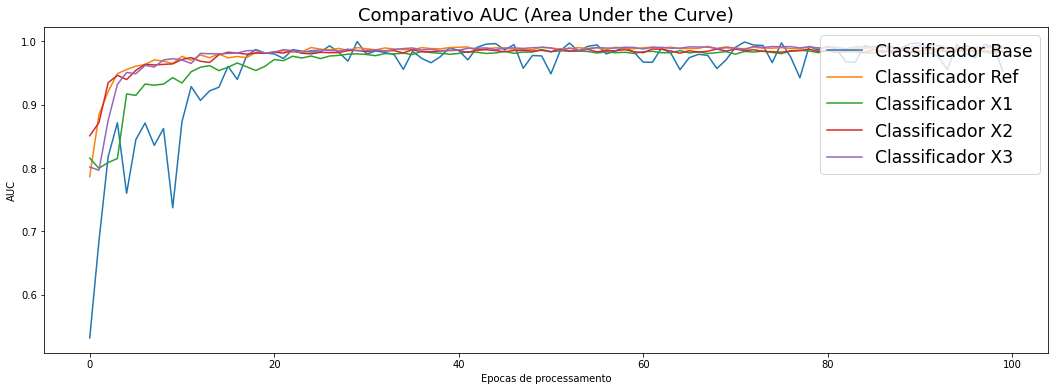

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.plot(h_0.history['auc'])
plt.plot(h_1.history['auc'])
plt.plot(h_x1.history['auc'])
plt.plot(h_x2.history['auc'])
plt.plot(h_x3.history['auc'])
plt.title('AUC')
plt.ylabel('AUC')
plt.xlabel('Epocas de processamento')
plt.legend(['Classificador Base', 'Classificador Ref', 'Classificador X1', 'Classificador X2', 'Classificador X3'],
           loc='upper right', fontsize = 'xx-large')
plt.title('Comparativo AUC (Area Under the Curve)', fontsize=18)
plt.show()


## Testes aplicados em amostras

Classificador Referência

In [ ]:
model = Sequential()
model = load_model('/content/drive/MyDrive/classificador_model.h5')


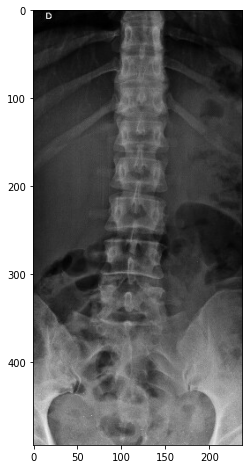

In [ ]:
img_teste = load_img('/content/drive/MyDrive/Documentação - CNN Coluna/dataset/amostras_teste/NORMAL(2398).jpg',
                           target_size = (128, 128))

img_plot = PIL.Image.open('/content/drive/MyDrive/Documentação - CNN Coluna/dataset/amostras_teste/NORMAL(2398).jpg')

plt.figure(figsize=(8,8))
plt.imshow(img_plot)
plt.show()

img_teste = image.img_to_array(img_teste)
img_teste /= 255
img_teste = np.expand_dims(img_teste,
                           axis = 0)

resultado_teste = model.predict(img_teste)

resultado_final = resultado_teste


In [ ]:
if resultado_final[0] < 0.5:
    print('Radiografia de Coluna Lombar com aspecto NORMAL.')
else:
    print('Radiografia de Coluna Lombar com aspecto de ESCOLIOSE.')


Radiografia de Coluna Lombar com aspecto NORMAL.


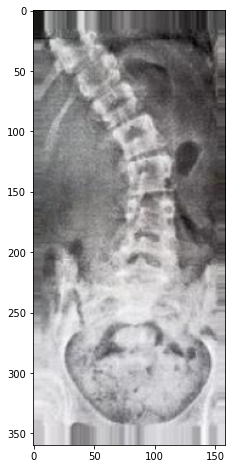

In [ ]:
img_teste = load_img('/content/drive/MyDrive/Documentação - CNN Coluna/dataset/amostras_teste/PATOLOGICA_0_8131.jpeg',
                           target_size = (128, 128))

img_plot = PIL.Image.open('/content/drive/MyDrive/Documentação - CNN Coluna/dataset/amostras_teste/PATOLOGICA_0_8131.jpeg')

plt.figure(figsize=(8,8))
plt.imshow(img_plot)
plt.show()

img_teste = image.img_to_array(img_teste)
img_teste /= 255
img_teste = np.expand_dims(img_teste,
                           axis = 0)

resultado_teste = model.predict(img_teste)

resultado_final = resultado_teste


In [ ]:
if resultado_final[0] < 0.5:
    print('Radiografia de Coluna Lombar com aspecto NORMAL.')
else:
    print('Radiografia de Coluna Lombar com aspecto de ESCOLIOSE.')


Radiografia de Coluna Lombar com aspecto de ESCOLIOSE.


Classificador Modelo X1

In [ ]:
model = Sequential()
model = load_model('/content/drive/MyDrive/classificador_x1_model.h5')


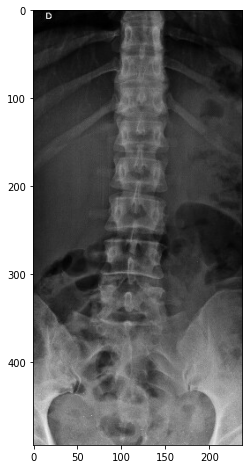

In [ ]:
img_teste = load_img('/content/drive/MyDrive/Documentação - CNN Coluna/dataset/amostras_teste/NORMAL(2398).jpg',
                           target_size = (128, 128))

img_plot = PIL.Image.open('/content/drive/MyDrive/Documentação - CNN Coluna/dataset/amostras_teste/NORMAL(2398).jpg')

plt.figure(figsize=(8,8))
plt.imshow(img_plot)
plt.show()

img_teste = image.img_to_array(img_teste)
img_teste /= 255
img_teste = np.expand_dims(img_teste,
                           axis = 0)

resultado_teste = model.predict(img_teste)

resultado_final = resultado_teste


In [ ]:
if resultado_final[0] < 0.5:
    print('Radiografia de Coluna Lombar com aspecto NORMAL.')
else:
    print('Radiografia de Coluna Lombar com aspecto de ESCOLIOSE.')


Radiografia de Coluna Lombar com aspecto de ESCOLIOSE.


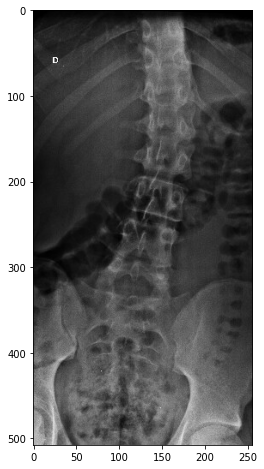

In [ ]:
img_teste = load_img('/content/drive/MyDrive/Documentação - CNN Coluna/dataset/amostras_teste/PATOLOGICA(92943).jpg',
                           target_size = (128, 128))

img_plot = PIL.Image.open('/content/drive/MyDrive/Documentação - CNN Coluna/dataset/amostras_teste/PATOLOGICA(92943).jpg')

plt.figure(figsize=(8,8))
plt.imshow(img_plot)
plt.show()

img_teste = image.img_to_array(img_teste)
img_teste /= 255
img_teste = np.expand_dims(img_teste,
                           axis = 0)

resultado_teste = model.predict(img_teste)

resultado_final = resultado_teste


In [ ]:
if resultado_final[0] < 0.5:
    print('Radiografia de Coluna Lombar com aspecto NORMAL.')
else:
    print('Radiografia de Coluna Lombar com aspecto de ESCOLIOSE.')


Radiografia de Coluna Lombar com aspecto de ESCOLIOSE.


Classificador Modelo X2

In [ ]:
model = Sequential()
model = load_model('/content/drive/MyDrive/classificador_x2_model.h5')


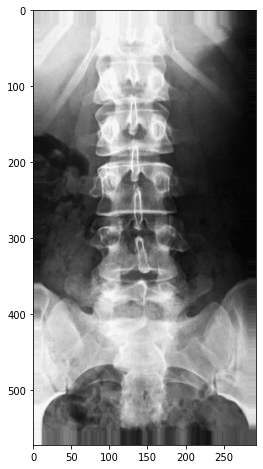

In [ ]:
img_teste = load_img('/content/drive/MyDrive/Documentação - CNN Coluna/dataset/amostras_teste/NORMAL_0_7911.jpeg',
                           target_size = (128, 128))

img_plot = PIL.Image.open('/content/drive/MyDrive/Documentação - CNN Coluna/dataset/amostras_teste/NORMAL_0_7911.jpeg')


plt.figure(figsize=(8,8))
plt.imshow(img_plot)
plt.show()

img_teste = image.img_to_array(img_teste)
img_teste /= 255
img_teste = np.expand_dims(img_teste,
                           axis = 0)

resultado_teste = model.predict(img_teste)

resultado_final = resultado_teste


In [ ]:
if resultado_final[0] < 0.5:
    print('Radiografia de Coluna Lombar com aspecto NORMAL.')
else:
    print('Radiografia de Coluna Lombar com aspecto de ESCOLIOSE.')


Radiografia de Coluna Lombar com aspecto NORMAL.


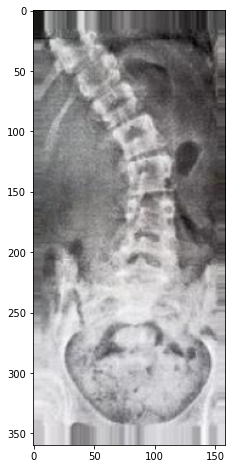

In [ ]:
img_teste = load_img('/content/drive/MyDrive/Documentação - CNN Coluna/dataset/amostras_teste/PATOLOGICA_0_8131.jpeg',
                           target_size = (128, 128))

img_plot = PIL.Image.open('/content/drive/MyDrive/Documentação - CNN Coluna/dataset/amostras_teste/PATOLOGICA_0_8131.jpeg')

plt.figure(figsize=(8,8))
plt.imshow(img_plot)
plt.show()

img_teste = image.img_to_array(img_teste)
img_teste /= 255
img_teste = np.expand_dims(img_teste,
                           axis = 0)

resultado_teste = model.predict(img_teste)

resultado_final = resultado_teste


In [ ]:
if resultado_final[0] < 0.5:
    print('Radiografia de Coluna Lombar com aspecto NORMAL.')
else:
    print('Radiografia de Coluna Lombar com aspecto de ESCOLIOSE.')


Radiografia de Coluna Lombar com aspecto de ESCOLIOSE.


Classificador Modelo X3

In [ ]:
model = Sequential()
model = load_model('/content/drive/MyDrive/classificador_x3_model.h5')


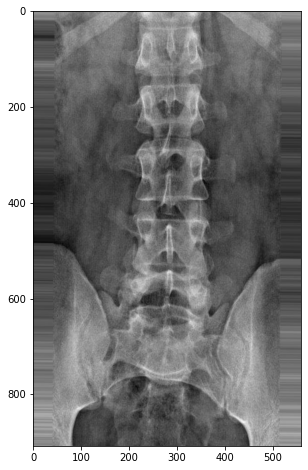

In [ ]:
img_teste = load_img('/content/drive/MyDrive/Documentação - CNN Coluna/dataset/amostras_teste/NORMAL_0_8550.jpeg',
                           target_size = (128, 128))

img_plot = PIL.Image.open('/content/drive/MyDrive/Documentação - CNN Coluna/dataset/amostras_teste/NORMAL_0_8550.jpeg')

plt.figure(figsize=(8,8))
plt.imshow(img_plot)
plt.show()

img_teste = image.img_to_array(img_teste)
img_teste /= 255
img_teste = np.expand_dims(img_teste,
                           axis = 0)

resultado_teste = model.predict(img_teste)

resultado_final = resultado_teste


In [ ]:
if resultado_final[0] < 0.5:
    print('Radiografia de Coluna Lombar com aspecto NORMAL.')
else:
    print('Radiografia de Coluna Lombar com aspecto de ESCOLIOSE.')


Radiografia de Coluna Lombar com aspecto NORMAL.


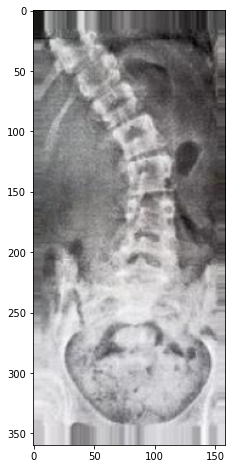

In [ ]:
img_teste = load_img('/content/drive/MyDrive/Documentação - CNN Coluna/dataset/amostras_teste/PATOLOGICA_0_8131.jpeg',
                           target_size = (128, 128))

img_plot = PIL.Image.open('/content/drive/MyDrive/Documentação - CNN Coluna/dataset/amostras_teste/PATOLOGICA_0_8131.jpeg')

plt.figure(figsize=(8,8))
plt.imshow(img_plot)
plt.show()

img_teste = image.img_to_array(img_teste)
img_teste /= 255
img_teste = np.expand_dims(img_teste,
                           axis = 0)

resultado_teste = model.predict(img_teste)

resultado_final = resultado_teste


In [ ]:
if resultado_final[0] < 0.5:
    print('Radiografia de Coluna Lombar com aspecto NORMAL.')
else:
    print('Radiografia de Coluna Lombar com aspecto de ESCOLIOSE.')


Radiografia de Coluna Lombar com aspecto de ESCOLIOSE.


## Resultados dos testes

In [ ]:
# Acurácia | Testes

acuracia_modelos = [h_0.history['accuracy'],
                    h_1.history['accuracy'],
                    h_x1.history['accuracy'],
                    h_x2.history['accuracy'],
                    h_x3.history['accuracy']]

melhor_acuracia = max(acuracia_modelos)

if melhor_acuracia == acuracia_modelos[0]:
    print('Melhor acurácia obtida pelo modelo Base: {0:.2f}%'.format(max(h_0.history['accuracy']) * 100))
if melhor_acuracia == acuracia_modelos[1]:
    print('Melhor acurácia obtida pelo modelo Referência: {0:.2f}%'.format(max(h_1.history['accuracy']) * 100))
if melhor_acuracia == acuracia_modelos[2]:
    print('Melhor acurácia obtida pelo modelo Classificador X1: {0:.2f}%'.format(max(h_x1.history['accuracy']) * 100))
if melhor_acuracia == acuracia_modelos[3]:
    print('Melhor acurácia obtida pelo modelo Classificador X2: {0:.2f}%'.format(max(h_x2.history['accuracy']) * 100))
if melhor_acuracia == acuracia_modelos[4]:
    print('Melhor acurácia obtida pelo modelo Classificador X3: {0:.2f}%'.format(max(h_x3.history['accuracy']) * 100))


Melhor acurácia obtida pelo modelo Classificador X2: 95.13%


In [ ]:
# Acurácia | Validação

acuracia_modelos = [h_0.history['val_accuracy'],
                    h_1.history['val_accuracy'],
                    h_x1.history['val_accuracy'],
                    h_x2.history['val_accuracy'],
                    h_x3.history['val_accuracy']]

melhor_acuracia_validacao = max(acuracia_modelos)
#print(melhor_acuracia_validacao)

if melhor_acuracia_validacao == acuracia_modelos[0]:
    print('Melhor acurácia (validação) obtida pelo modelo Base: {0:.2f}%'.format(max(h_0.history['val_accuracy']) * 100))
if melhor_acuracia_validacao == acuracia_modelos[1]:
    print('Melhor acurácia (validação) obtida pelo modelo Referência: {0:.2f}%'.format(max(h_1.history['val_accuracy']) * 100))
if melhor_acuracia_validacao == acuracia_modelos[2]:
    print('Melhor acurácia (validação) obtida pelo modelo Classificador X1: {0:.2f}%'.format(max(h_x1.history['val_accuracy']) * 100))
if melhor_acuracia_validacao == acuracia_modelos[3]:
    print('Melhor acurácia (validação) obtida pelo modelo Classificador X2: {0:.2f}%'.format(max(h_x2.history['val_accuracy']) * 100))
if melhor_acuracia_validacao == acuracia_modelos[4]:
    print('Melhor acurácia (validação) obtida pelo modelo Classificador X3: {0:.2f}%'.format(max(h_x3.history['val_accuracy']) * 100))


Melhor acurácia (validação) obtida pelo modelo Referência: 99.25%


In [ ]:
# Taxa de Aprendizado

taxa_aprendizado_modelos = [h_0.history['lr'],
                            h_1.history['lr'],
                            h_x1.history['lr'],
                            h_x2.history['lr'],
                            h_x3.history['lr']]

melhor_taxa_aprendizado = min(acuracia_modelos)
#print(melhor_taxa_aprendizado)

if melhor_taxa_aprendizado == acuracia_modelos[0]:
    print('Melhor taxa de aprendizado obtida pelo modelo Base: {0:.0f}%'.format(max(h_0.history['val_accuracy']) * 100 - 1))
if melhor_taxa_aprendizado == acuracia_modelos[1]:
    print('Melhor taxa de aprendizado obtida pelo modelo Referência: {0:.0f}%'.format(max(h_1.history['val_accuracy']) * 100 - 1))
if melhor_taxa_aprendizado == acuracia_modelos[2]:
    print('Melhor taxa de aprendizado obtida pelo modelo Classificador X1: {0:.0f}%'.format(max(h_x1.history['val_accuracy']) * 100 - 1))
if melhor_taxa_aprendizado == acuracia_modelos[3]:
    print('Melhor taxa de aprendizado obtida pelo modelo Classificador X2: {0:.0f}%'.format(max(h_x2.history['val_accuracy']) * 100 - 1))
if melhor_taxa_aprendizado == acuracia_modelos[4]:
    print('Melhor taxa de aprendizado obtida pelo modelo Classificador X3: {0:.0f}%'.format(max(h_x3.history['val_accuracy']) * 100 - 1))


Melhor taxa de aprendizado obtida pelo modelo Classificador X2: 99%


In [ ]:
# Loss

taxa_perda_modelos = [h_0.history['loss'],
                            h_1.history['loss'],
                            h_x1.history['loss'],
                            h_x2.history['loss'],
                            h_x3.history['loss']]

melhor_taxa_perda = min(acuracia_modelos)
#print(melhor_taxa_aprendizado)

if melhor_taxa_perda == acuracia_modelos[0]:
    print('Melhor taxa de perda obtida pelo modelo Base: {0:.0f}%'.format(max(h_0.history['loss'])))
if melhor_taxa_perda == acuracia_modelos[1]:
    print('Melhor taxa de perda obtida pelo modelo Referência: {0:.0f}%'.format(max(h_1.history['loss'])))
if melhor_taxa_perda == acuracia_modelos[2]:
    print('Melhor taxa de perda obtida pelo modelo Classificador X1: {0:.0f}%'.format(max(h_x1.history['loss'])))
if melhor_taxa_perda == acuracia_modelos[3]:
    print('Melhor taxa de perda obtida pelo modelo Classificador X2: {0:.0f}%'.format(max(h_x2.history['loss'])))
if melhor_taxa_perda == acuracia_modelos[4]:
    print('Melhor taxa de perda obtida pelo modelo Classificador X3: {0:.0f}%'.format(max(h_x3.history['loss'])))


Melhor taxa de perda obtida pelo modelo Classificador X2: 1%


In [ ]:
print('MODELO BASE')
print('Acuracia do treino: {0:.2f}%'.format(max(h_0.history['accuracy']) * 100))
print('Acuracia da validacao: {0:.0f}%'.format(max(h_0.history['val_accuracy']) * 100))
print('_________________________________________________________________________')
print('CLASSIFICADOR REFERÊNCIA')
print('Acuracia do treino: {0:.2f}%'.format(max(h_1.history['accuracy']) * 100))
print('Acuracia da validacao: {0:.0f}%'.format(max(h_1.history['val_accuracy']) * 100))
print('_________________________________________________________________________')
print('CLASSIFICADOR X1')
print('Acuracia do treino: {0:.2f}%'.format(max(h_x1.history['accuracy']) * 100))
print('Acuracia da validacao: {0:.0f}%'.format(max(h_x1.history['val_accuracy']) * 100))
print('_________________________________________________________________________')
print('CLASSIFICADOR X2')
print('Acuracia do treino: {0:.2f}%'.format(max(h_x2.history['accuracy']) * 100))
print('Acuracia da validacao: {0:.0f}%'.format(max(h_x2.history['val_accuracy']) * 100))
print('_________________________________________________________________________')
print('CLASSIFICADOR X3')
print('Acuracia do treino: {0:.2f}%'.format(max(h_x3.history['accuracy']) * 100))
print('Acuracia da validacao: {0:.0f}%'.format(max(h_x3.history['val_accuracy']) * 100))
print('_________________________________________________________________________')


MODELO BASE
Acuracia do treino: 99.00%
Acuracia da validacao: 92%
_________________________________________________________________________
CLASSIFICADOR REFERÊNCIA
Acuracia do treino: 95.75%
Acuracia da validacao: 99%
_________________________________________________________________________
CLASSIFICADOR X1
Acuracia do treino: 95.04%
Acuracia da validacao: 100%
_________________________________________________________________________
CLASSIFICADOR X2
Acuracia do treino: 95.13%
Acuracia da validacao: 100%
_________________________________________________________________________
CLASSIFICADOR X3
Acuracia do treino: 96.13%
Acuracia da validacao: 100%
_________________________________________________________________________


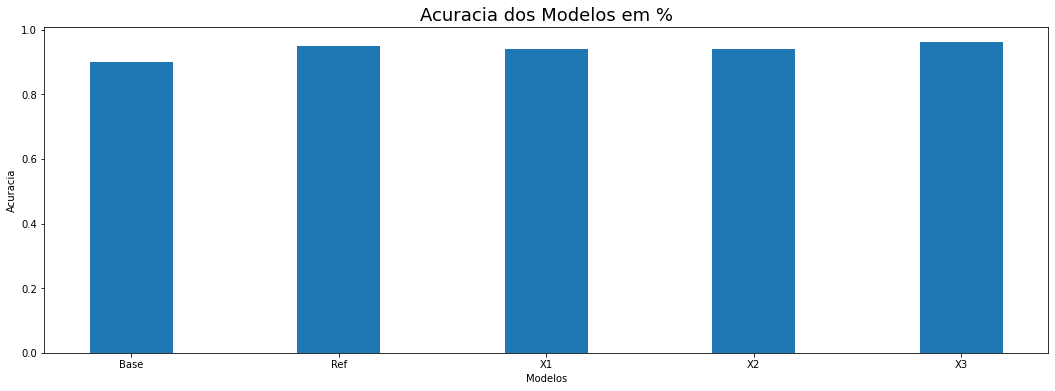

In [ ]:
indice_h_0 = len(h_0.history['accuracy'])-1
indice_h_1 = len(h_1.history['accuracy'])-1
indice_h_x1 = len(h_x1.history['accuracy'])-1
indice_h_x2 = len(h_x1.history['accuracy'])-1
indice_h_x3 = len(h_x1.history['accuracy'])-1

data = {'Base':h_0.history['accuracy'][indice_h_0],
        'Ref':h_1.history['accuracy'][indice_h_1],
        'X1':h_x1.history['accuracy'][indice_h_x1],
        'X2':h_x2.history['accuracy'][indice_h_x2],
        'X3':h_x3.history['accuracy'][indice_h_x3]}

modelos = list(data.keys())
valores = list(data.values())
  
fig = plt.figure(figsize = (18, 6))
plt.bar(modelos, valores, width = 0.4)
plt.xlabel("Modelos")
plt.ylabel("Acuracia")
plt.title('Acuracia dos Modelos em %', fontsize=18)
plt.show()


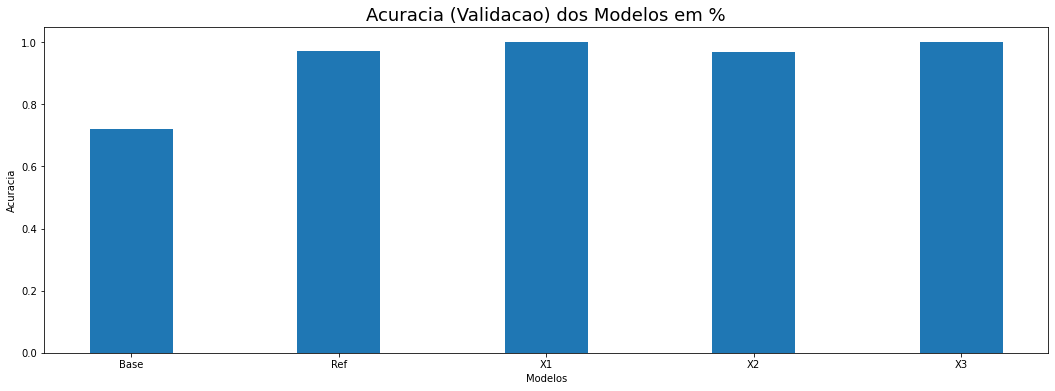

In [ ]:
indice_h_0 = len(h_0.history['val_accuracy'])-1
indice_h_1 = len(h_1.history['val_accuracy'])-1
indice_h_x1 = len(h_x1.history['val_accuracy'])-1
indice_h_x2 = len(h_x1.history['val_accuracy'])-1
indice_h_x3 = len(h_x1.history['val_accuracy'])-1

data = {'Base':h_0.history['val_accuracy'][indice_h_0],
        'Ref':h_1.history['val_accuracy'][indice_h_1],
        'X1':h_x1.history['val_accuracy'][indice_h_x1],
        'X2':h_x2.history['val_accuracy'][indice_h_x2],
        'X3':h_x3.history['val_accuracy'][indice_h_x3]}

modelos = list(data.keys())
valores = list(data.values())
  
fig = plt.figure(figsize = (18, 6))
plt.bar(modelos, valores, width = 0.4)
plt.xlabel("Modelos")
plt.ylabel("Acuracia")
plt.title('Acuracia (Validacao) dos Modelos em %', fontsize=18)
plt.show()


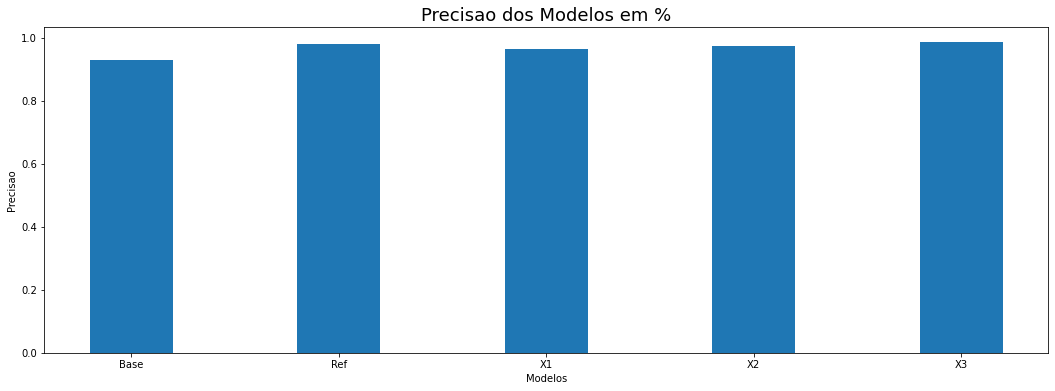

In [ ]:
indice_h_0 = len(h_0.history['precision'])-1
indice_h_1 = len(h_1.history['precision'])-1
indice_h_x1 = len(h_x1.history['precision'])-1
indice_h_x2 = len(h_x1.history['precision'])-1
indice_h_x3 = len(h_x1.history['precision'])-1

data = {'Base':h_0.history['precision'][indice_h_0],
        'Ref':h_1.history['precision'][indice_h_1],
        'X1':h_x1.history['precision'][indice_h_x1],
        'X2':h_x2.history['precision'][indice_h_x2],
        'X3':h_x3.history['precision'][indice_h_x3]}

modelos = list(data.keys())
valores = list(data.values())
  
fig = plt.figure(figsize = (18, 6))
plt.bar(modelos, valores, width = 0.4)
plt.xlabel("Modelos")
plt.ylabel("Precisao")
plt.title('Precisao dos Modelos em %', fontsize=18)
plt.show()
